In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

!git clone https://github.com/HuthLab/speechmodeltutorial.git


# !git clone https://github.com/gallantlab/pycortex.git
# %cd pycortex
# !python setup.py install
# !pip install wget
# !pip install numpy Cython scipy h5py nibabel matplotlib Pillow numexpr tornado lxml networkx


In [ ]:
#@title Libraries
# import logging
import numpy as np
import os
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import random
import time
from matplotlib import pylab
from sklearn.preprocessing import StandardScaler

from nilearn import datasets
from nilearn import plotting

from __future__ import print_function

import ipywidgets

from google.colab import widgets
from google.colab import output
from six.moves import zip
# import cortex as cx
fsaverage = datasets.fetch_surf_fsaverage()
# logging.basicConfig(level=logging.DEBUG)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
# @title Figure Settings
import ipywidgets as wid
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
--2021-08-18 20:07:42--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/agxyxntrbwko7t1/participants_data.zip [following]
--2021-08-18 20:07:42--  https://www.dropbox.com/s/dl/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45e3c9f39d6f07a19fbbac0920.dl.dropboxusercontent.com/cd/0/get/BUdej90E8EfmjtBqfHRqBS_AAmk4I302zm7spwbi3CPbVYCgi1-ZARd2h-TZo0pKR1z6g0CKCsbQurn87BKmHID3yJX3Mdy1ec-nIDqKDur_WmFPEDq5FhmjFwXBog7cVFvdwT3n08GLlKPJbiMrX8NB/file?dl=1# [following]
--2021-08-18 20:07:43--  https://uc45e3c9f39d6f07a19fbbac0920.dl.dropboxusercontent.com/c

In [ ]:
!rm -rf '/content/pycortex'

In [ ]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
    fmri_dir = '/home/yamin/NMA/participants_data/participants_data_v2021' 
    track = "full_track"
    results_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/BaselineRun'
    track_dir = os.path.join(fmri_dir, track) 
    sub_fmri_dir = os.path.join(track_dir, sub)
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
    brain_mask = '/content/example.nii'
    nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [ ]:
#@title Ridge regression function with bootstraping
import scipy
from functools import reduce
import logging
import itertools as itools
logging.basicConfig(filename='info.log')

def mult_diag(d, mtx, left=True):
    """Multiply a full matrix by a diagonal matrix.
    This function should always be faster than dot.

    Input:
      d -- 1D (N,) array (contains the diagonal elements)
      mtx -- 2D (N,N) array

    Output:
      mult_diag(d, mts, left=True) == dot(diag(d), mtx)
      mult_diag(d, mts, left=False) == dot(mtx, diag(d))
    
    By Pietro Berkes
    From http://mail.scipy.org/pipermail/numpy-discussion/2007-March/026807.html
    """
    if left:
        return (d*mtx.T).T
    else:
        return d*mtx


def counter(iterable, countevery=100, total=None, logger=logging.getLogger("counter")):
    """Logs a status and timing update to [logger] every [countevery] draws from [iterable].
    If [total] is given, log messages will include the estimated time remaining.
    """
    start_time = time.time()

    ## Check if the iterable has a __len__ function, use it if no total length is supplied
    if total is None:
        if hasattr(iterable, "__len__"):
            total = len(iterable)
    
    for count, thing in enumerate(iterable):
        yield thing
        
        if not count%countevery:
            current_time = time.time()
            rate = float(count+1)/(current_time-start_time)

            if rate>1: ## more than 1 item/second
                ratestr = "%0.2f items/second"%rate
            else: ## less than 1 item/second
                ratestr = "%0.2f seconds/item"%(rate**-1)
            
            if total is not None:
                remitems = total-(count+1)
                remtime = remitems/rate
                timestr = ", %s remaining" % time.strftime('%H:%M:%S', time.gmtime(remtime))
                itemstr = "%d/%d"%(count+1, total)
            else:
                timestr = ""
                itemstr = "%d"%(count+1)

            formatted_str = "%s items complete (%s%s)"%(itemstr,ratestr,timestr)
            if logger is None:
                print (formatted_str)
            else:
                logger.info(formatted_str)

zs = lambda v: (v-v.mean(0))/v.std(0) ## z-score function


def ridge_corr(Rstim, Pstim, Rresp, Presp, alphas, normalpha=False, dtype=np.single, corrmin=0.2,
               singcutoff=1e-10, use_corr=True, logger=logging.getLogger("ridge_corr")):
    """Uses ridge regression to find a linear transformation of [Rstim] that approximates [Rresp].
    Then tests by comparing the transformation of [Pstim] to [Presp]. This procedure is repeated
    for each regularization parameter alpha in [alphas]. The correlation between each prediction and
    each response for each alpha is returned. Note that the regression weights are NOT returned.
    Parameters
    ----------
    Rstim : array_like, shape (TR, N)
        Training stimuli with TR time points and N features. Each feature should be Z-scored across time.
    Pstim : array_like, shape (TP, N)
        Test stimuli with TP time points and N features. Each feature should be Z-scored across time.
    Rresp : array_like, shape (TR, M)
        Training responses with TR time points and M responses (voxels, neurons, what-have-you).
        Each response should be Z-scored across time.
    Presp : array_like, shape (TP, M)
        Test responses with TP time points and M responses.
    alphas : list or array_like, shape (A,)
        Ridge parameters to be tested. Should probably be log-spaced. np.logspace(0, 3, 20) works well.
    normalpha : boolean
        Whether ridge parameters should be normalized by the Frobenius norm of Rstim. Good for
        comparing models with different numbers of parameters.
    dtype : np.dtype
        All data will be cast as this dtype for computation. np.single is used by default for memory
        efficiency.
    corrmin : float in [0..1]
        Purely for display purposes. After each alpha is tested, the number of responses with correlation
        greater than corrmin minus the number of responses with correlation less than negative corrmin
        will be printed. For long-running regressions this vague metric of non-centered skewness can
        give you a rough sense of how well the model is working before it's done.
    singcutoff : float
        The first step in ridge regression is computing the singular value decomposition (SVD) of the
        stimulus Rstim. If Rstim is not full rank, some singular values will be approximately equal
        to zero and the corresponding singular vectors will be noise. These singular values/vectors
        should be removed both for speed (the fewer multiplications the better!) and accuracy. Any
        singular values less than singcutoff will be removed.
    use_corr : boolean
        If True, this function will use correlation as its metric of model fit. If False, this function
        will instead use variance explained (R-squared) as its metric of model fit. For ridge regression
        this can make a big difference -- highly regularized solutions will have very small norms and
        will thus explain very little variance while still leading to high correlations, as correlation
        is scale-free while R**2 is not.
    Returns
    -------
    Rcorrs : array_like, shape (A, M)
        The correlation between each predicted response and each column of Presp for each alpha.
    
    """
    ## Calculate SVD of stimulus matrix
    logger.info("Doing SVD...")
    try:
        U,S,Vh = np.linalg.svd(Rstim, full_matrices=False)
    except np.linalg.LinAlgError as e:
        logger.info("NORMAL SVD FAILED, trying more robust dgesvd..")
        from text.regression.svd_dgesvd import svd_dgesvd
        U,S,Vh = svd_dgesvd(Rstim, full_matrices=False)

    ## Truncate tiny singular values for speed
    origsize = S.shape[0]
    ngoodS = np.sum(S>singcutoff)
    nbad = origsize-ngoodS
    U = U[:,:ngoodS]
    S = S[:ngoodS]
    Vh = Vh[:ngoodS]
    logger.info("Dropped %d tiny singular values.. (U is now %s)"%(nbad, str(U.shape)))

    ## Normalize alpha by the Frobenius norm
    #frob = np.sqrt((S**2).sum()) ## Frobenius!
    frob = S[0]
    #frob = S.sum()
    logger.info("Training stimulus has Frobenius norm: %0.03f"%frob)
    if normalpha:
        nalphas = alphas * frob
    else:
        nalphas = alphas

    ## Precompute some products for speed
    UR = np.dot(U.T, Rresp) ## Precompute this matrix product for speed
    PVh = np.dot(Pstim, Vh.T) ## Precompute this matrix product for speed
    
    #Prespnorms = np.apply_along_axis(np.linalg.norm, 0, Presp) ## Precompute test response norms
    zPresp = zs(Presp)
    Prespvar = Presp.var(0)
    Rcorrs = [] ## Holds training correlations for each alpha
    for na, a in zip(nalphas, alphas):
        #D = np.diag(S/(S**2+a**2)) ## Reweight singular vectors by the ridge parameter 
        D = S/(S**2+na**2) ## Reweight singular vectors by the (normalized?) ridge parameter
        
        pred = np.dot(mult_diag(D, PVh, left=False), UR) ## Best (1.75 seconds to prediction in test)
        # pred = np.dot(mult_diag(D, np.dot(Pstim, Vh.T), left=False), UR) ## Better (2.0 seconds to prediction in test)
        
        # pvhd = reduce(np.dot, [Pstim, Vh.T, D]) ## Pretty good (2.4 seconds to prediction in test)
        # pred = np.dot(pvhd, UR)
        
        # wt = reduce(np.dot, [Vh.T, D, UR]).astype(dtype) ## Bad (14.2 seconds to prediction in test)
        # wt = reduce(np.dot, [Vh.T, D, U.T, Rresp]).astype(dtype) ## Worst
        # pred = np.dot(Pstim, wt) ## Predict test responses

        if use_corr:
            #prednorms = np.apply_along_axis(np.linalg.norm, 0, pred) ## Compute predicted test response norms
            #Rcorr = np.array([np.corrcoef(Presp[:,ii], pred[:,ii].ravel())[0,1] for ii in range(Presp.shape[1])]) ## Slowly compute correlations
            #Rcorr = np.array(np.sum(np.multiply(Presp, pred), 0)).squeeze()/(prednorms*Prespnorms) ## Efficiently compute correlations
            Rcorr = (zPresp*zs(pred)).mean(0)
        else:
            ## Compute variance explained
            resvar = (Presp-pred).var(0)
            Rcorr = np.clip(1-(resvar/Prespvar), 0, 1)
            
        Rcorr[np.isnan(Rcorr)] = 0
        Rcorrs.append(Rcorr)
        
        log_template = "Training: alpha=%0.3f, mean corr=%0.5f, max corr=%0.5f, over-under(%0.2f)=%d"
        log_msg = log_template % (a,
                                  np.mean(Rcorr),
                                  np.max(Rcorr),
                                  corrmin,
                                  (Rcorr>corrmin).sum()-(-Rcorr>corrmin).sum())
        if logger is not None:
            logger.info(log_msg)
        else:
            print (log_msg)
    
    return Rcorrs


def bootstrap_ridge(Rstim, Rresp, Pstim, Presp, alphas, nboots, chunklen, nchunks, dtype=np.single,
                    corrmin=0.2, joined=None, singcutoff=1e-10, normalpha=False, single_alpha=False,
                    use_corr=True, logger=logging.getLogger("ridge_corr")):
    """Uses ridge regression with a bootstrapped held-out set to get optimal alpha values for each response.
    [nchunks] random chunks of length [chunklen] will be taken from [Rstim] and [Rresp] for each regression
    run.  [nboots] total regression runs will be performed.  The best alpha value for each response will be
    averaged across the bootstraps to estimate the best alpha for that response.
    
    If [joined] is given, it should be a list of lists where the STRFs for all the voxels in each sublist 
    will be given the same regularization parameter (the one that is the best on average).
    
    Parameters
    ----------
    Rstim : array_like, shape (TR, N)
        Training stimuli with TR time points and N features. Each feature should be Z-scored across time.
    Rresp : array_like, shape (TR, M)
        Training responses with TR time points and M different responses (voxels, neurons, what-have-you).
        Each response should be Z-scored across time.
    Pstim : array_like, shape (TP, N)
        Test stimuli with TP time points and N features. Each feature should be Z-scored across time.
    Presp : array_like, shape (TP, M)
        Test responses with TP time points and M different responses. Each response should be Z-scored across
        time.
    alphas : list or array_like, shape (A,)
        Ridge parameters that will be tested. Should probably be log-spaced. np.logspace(0, 3, 20) works well.
    nboots : int
        The number of bootstrap samples to run. 15 to 30 works well.
    chunklen : int
        On each sample, the training data is broken into chunks of this length. This should be a few times 
        longer than your delay/STRF. e.g. for a STRF with 3 delays, I use chunks of length 10.
    nchunks : int
        The number of training chunks held out to test ridge parameters for each bootstrap sample. The product
        of nchunks and chunklen is the total number of training samples held out for each sample, and this 
        product should be about 20 percent of the total length of the training data.
    dtype : np.dtype
        All data will be cast as this dtype for computation. np.single is used by default for memory efficiency,
        as using np.double will thrash most machines on a big problem. If you want to do regression on 
        complex variables, this should be changed to np.complex128.
    corrmin : float in [0..1]
        Purely for display purposes. After each alpha is tested for each bootstrap sample, the number of 
        responses with correlation greater than this value will be printed. For long-running regressions this
        can give a rough sense of how well the model works before it's done.
    joined : None or list of array_like indices
        If you want the STRFs for two (or more) responses to be directly comparable, you need to ensure that
        the regularization parameter that they use is the same. To do that, supply a list of the response sets
        that should use the same ridge parameter here. For example, if you have four responses, joined could
        be [np.array([0,1]), np.array([2,3])], in which case responses 0 and 1 will use the same ridge parameter
        (which will be parameter that is best on average for those two), and likewise for responses 2 and 3.
    singcutoff : float
        The first step in ridge regression is computing the singular value decomposition (SVD) of the
        stimulus Rstim. If Rstim is not full rank, some singular values will be approximately equal
        to zero and the corresponding singular vectors will be noise. These singular values/vectors
        should be removed both for speed (the fewer multiplications the better!) and accuracy. Any
        singular values less than singcutoff will be removed.
    normalpha : boolean
        Whether ridge parameters (alphas) should be normalized by the Frobenius norm of Rstim. Good for rigorously
        comparing models with different numbers of parameters.
    single_alpha : boolean
        Whether to use a single alpha for all responses. Good for identification/decoding.
    use_corr : boolean
        If True, this function will use correlation as its metric of model fit. If False, this function
        will instead use variance explained (R-squared) as its metric of model fit. For ridge regression
        this can make a big difference -- highly regularized solutions will have very small norms and
        will thus explain very little variance while still leading to high correlations, as correlation
        is scale-free while R**2 is not.
    
    Returns
    -------
    wt : array_like, shape (N, M)
        Regression weights for N features and M responses.
    corrs : array_like, shape (M,)
        Validation set correlations. Predicted responses for the validation set are obtained using the regression
        weights: pred = np.dot(Pstim, wt), and then the correlation between each predicted response and each 
        column in Presp is found.
    alphas : array_like, shape (M,)
        The regularization coefficient (alpha) selected for each voxel using bootstrap cross-validation.
    bootstrap_corrs : array_like, shape (A, M, B)
        Correlation between predicted and actual responses on randomly held out portions of the training set,
        for each of A alphas, M voxels, and B bootstrap samples.
    valinds : array_like, shape (TH, B)
        The indices of the training data that were used as "validation" for each bootstrap sample.
    """
    nresp, nvox = Rresp.shape
    bestalphas = np.zeros((nboots, nvox))  ## Will hold the best alphas for each voxel
    valinds = [] ## Will hold the indices into the validation data for each bootstrap
    
    Rcmats = []
    for bi in counter(range(nboots), countevery=1, total=nboots):
        logger.info("Selecting held-out test set..")
        allinds = range(nresp)
        indchunks = list(zip(*[iter(allinds)]*chunklen))
        random.shuffle(indchunks)
        heldinds = list(itools.chain(*indchunks[:nchunks]))
        notheldinds = list(set(allinds)-set(heldinds))
        valinds.append(heldinds)
        
        RRstim = Rstim[notheldinds,:]
        PRstim = Rstim[heldinds,:]
        RRresp = Rresp[notheldinds,:]
        PRresp = Rresp[heldinds,:]
        
        ## Run ridge regression using this test set
        Rcmat = ridge_corr(RRstim, PRstim, RRresp, PRresp, alphas,
                           dtype=dtype, corrmin=corrmin, singcutoff=singcutoff,
                           normalpha=normalpha, use_corr=use_corr)
        
        Rcmats.append(Rcmat)
    
    ## Find weights for each voxel
    try:
        U,S,Vh = np.linalg.svd(Rstim, full_matrices=False)
    except np.linalg.LinAlgError as e:
        logger.info("NORMAL SVD FAILED, trying more robust dgesvd..")
        from text.regression.svd_dgesvd import svd_dgesvd
        U,S,Vh = svd_dgesvd(Rstim, full_matrices=False)

    ## Normalize alpha by the Frobenius norm
    #frob = np.sqrt((S**2).sum()) ## Frobenius!
    frob = S[0]
    #frob = S.sum()
    logger.info("Total training stimulus has Frobenius norm: %0.03f"%frob)
    if normalpha:
        nalphas = alphas * frob
    else:
        nalphas = alphas

    allRcorrs = np.dstack(Rcmats)
    if not single_alpha:
        logger.info("Finding best alpha for each response..")
        if joined is None:
            ## Find best alpha for each voxel
            meanbootcorrs = allRcorrs.mean(2)
            bestalphainds = np.argmax(meanbootcorrs, 0)
            valphas = nalphas[bestalphainds]
        else:
            ## Find best alpha for each group of voxels
            valphas = np.zeros((nvox,))
            for jl in joined:
                jcorrs = allRcorrs[:,jl,:].mean(1).mean(1) ## Mean across voxels in the set, then mean across bootstraps
                bestalpha = np.argmax(jcorrs)
                valphas[jl] = nalphas[bestalpha]
    else:
        logger.info("Finding single best alpha..")
        meanbootcorr = allRcorrs.mean(2).mean(1)
        bestalphaind = np.argmax(meanbootcorr)
        bestalpha = alphas[bestalphaind]
        valphas = np.array([bestalpha]*nvox)
        logger.info("Best alpha = %0.3f"%bestalpha)

    logger.info("Computing weights for each response using entire training set..")
    UR = np.dot(U.T, np.nan_to_num(Rresp))
    pred = np.zeros(Presp.shape)
    wt = np.zeros((Rstim.shape[1], Rresp.shape[1]))
    for ai,alpha in enumerate(nalphas):
        selvox = np.nonzero(valphas==alpha)[0]
        awt = reduce(np.dot, [Vh.T, np.diag(S/(S**2+alpha**2)), UR[:,selvox]])
        pred[:,selvox] = np.dot(Pstim, awt)
        wt[:,selvox] = awt

    ## Find test correlations
    nnpred = np.nan_to_num(pred)
    corrs = np.nan_to_num(np.array([np.corrcoef(Presp[:,ii], nnpred[:,ii].ravel())[0,1] for ii in range(Presp.shape[1])]))

    return wt, corrs, valphas, allRcorrs, valinds, bestalpha


In [ ]:
def perform_encoding(activation_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks):
  feature_data = os.path.join(activations_dir, f'train_{layer}.npy')
  ##### Load fMRI data #################
  if ROI == "WB":
    track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      data, mask = get_fmri(sub_fmri_dir,ROI)
  else:
      data = get_fmri(sub_fmri_dir,ROI)
  # num_voxels = data.shape[1]
  ######################################
  
  # data, mask = get_fmri(fmri_data.format(subject),'WB')
  y_train = data[:900,:]
  y_test = data[900:,:]
  features = np.load(feature_data)
  scaler = StandardScaler()

  #Transform the feature matrix     
  #     x_train = scaler.fit_transform(features[:900,:])
  #     x_test = scaler.fit_transform(features[900:,:])
  x_train = features[:900,:]
  x_test = features[900:,:]
  
  wt, corrs, valphas, allRcorrs, valinds, bestalpha = bootstrap_ridge(x_train, y_train, x_test, y_test,alphas,
                                                                  nboots, chunklen, nchunks,singcutoff=1e-10, single_alpha=True)
  return wt, corrs, valphas, allRcorrs, valinds, bestalpha
  # print('bets lambda:', bestalpha)
  # print('maximum correlation:' , corrs.max())
    
  # f = plt.figure()
  # ax = f.add_subplot(1,1,1)
  # ax.semilogx(np.logspace(1, 3, 15), allRcorrs.mean(2).mean(1), 'o-')
  # plt.show()
  
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[mask==1]= corrs
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, f'correlations_{sub}_{layer}.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                            title='fMRI Correlation',plot_abs=False,
                            display_mode='lyr',colorbar=True,cmap = 'hot',
                            symmetric_cbar = True, vmin=0, vmax=1)
  plt.show()

  # print(x_test.shape)
  # print(y_test.shape)
  # print(x_train.shape)
  # print(y_train.shape)

In [ ]:
def show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs):
  with tab.output_to(layer):
    if grid_ind < 5:
      row = 1
    elif grid_ind >=10:
      row = 3
      grid_ind -= 10
    else:
      row = 2
      grid_ind -=5
    with grid.output_to(row, grid_ind):
      print(f'{ROI}')
      plt.figure(figsize=(4,4))
      plt.semilogx(alphas, allRcorrs.mean(2).mean(1), 'o-')
      print('Best lambda: %d' %bestalpha)
      print('Max Corr: %d' %corrs.max())
      time.sleep(0.5)
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/plots_{layer}.png')
    plt.show()

# def visualise_act(corrs):
#   visual_mask_3D = np.zeros((78,93,71))
#   visual_mask_3D[mask==1]= corrs
#   brain_mask = '/content/example.nii'
#   nii_save_path =  os.path.join(results_dir, f'correlations_{sub}_{layer}.nii')
#   saveasnii(brain_mask,nii_save_path,visual_mask_3D)
#   plotting.plot_glass_brain(nii_save_path,
#                             title='fMRI Correlation',plot_abs=False,
#                             display_mode='lyr',colorbar=True,cmap = 'hot',
#                             symmetric_cbar = True, vmin=0, vmax=1)
#   plt.show()

In [ ]:
#@title final run
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub01"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 2)
alphas =  # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting sub:  sub02
Starting ROI:  WB  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1389
Max Corr: 0


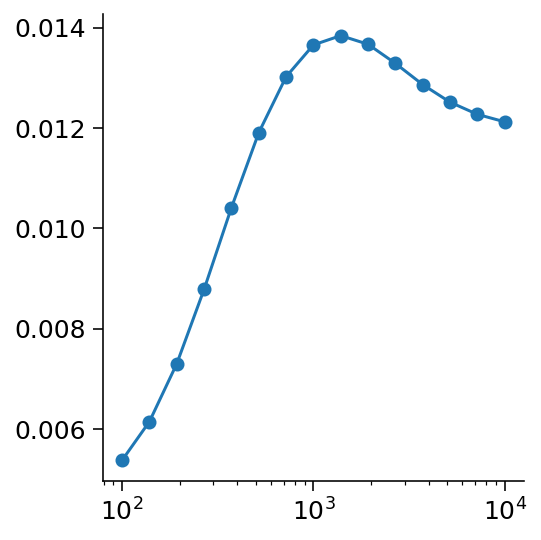

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 5179
Max Corr: 0


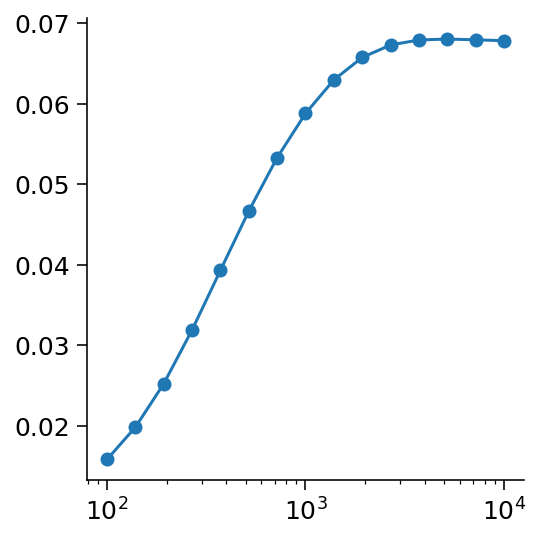

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 2682
Max Corr: 0


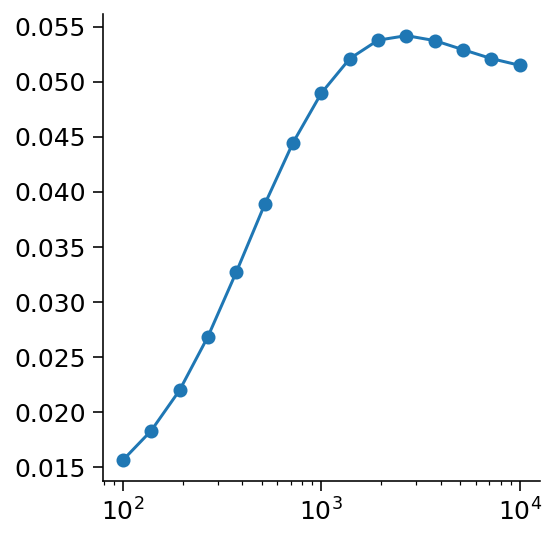

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 2682
Max Corr: 0


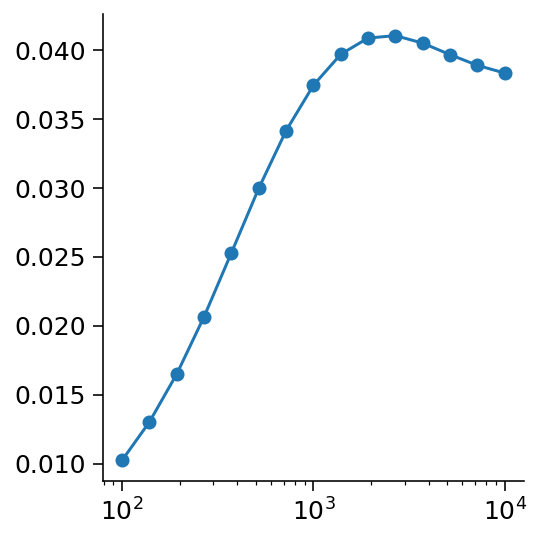

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 3727
Max Corr: 0


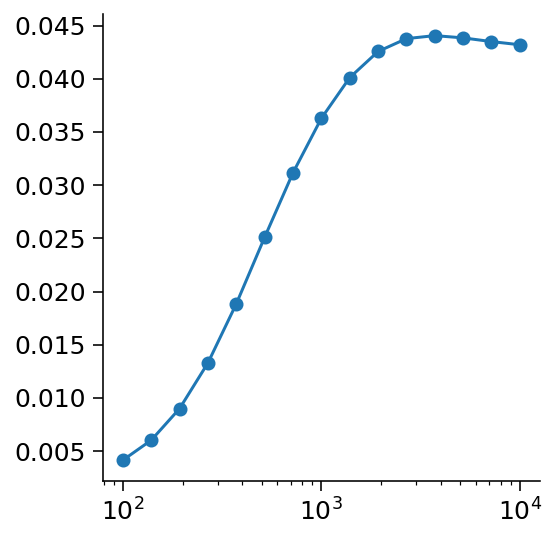

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1930
Max Corr: 0


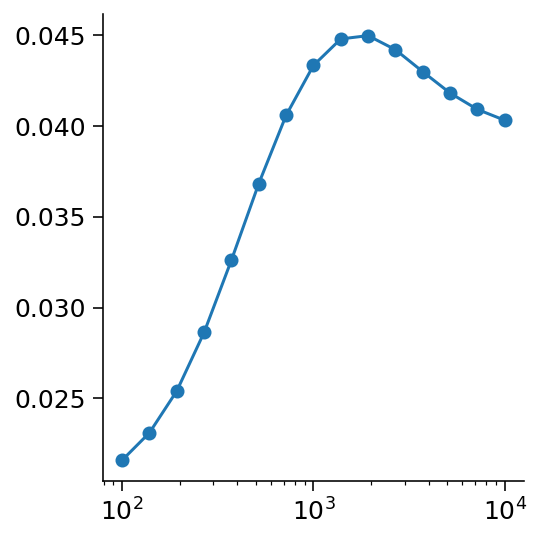

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


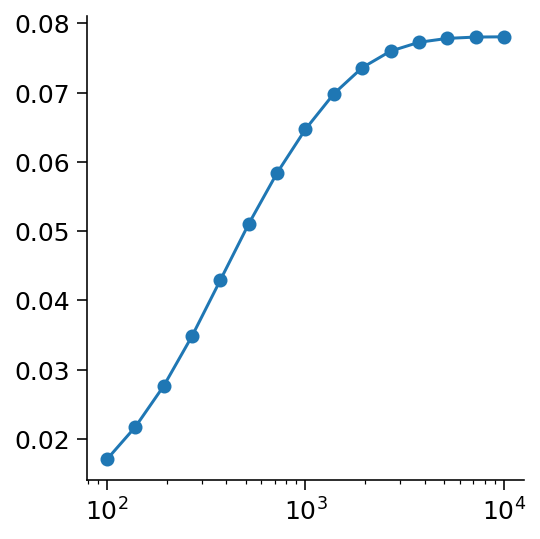

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


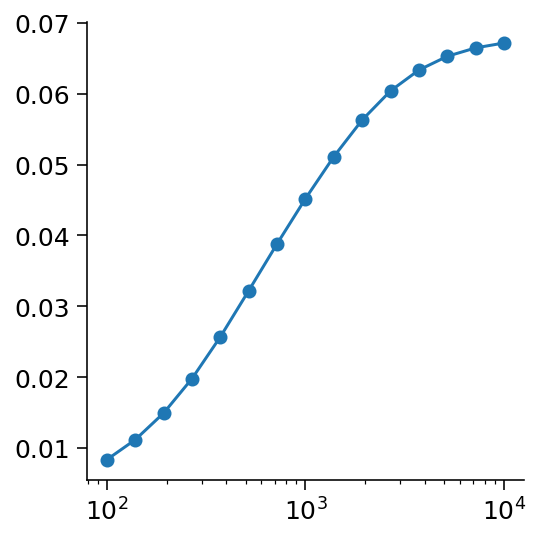

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


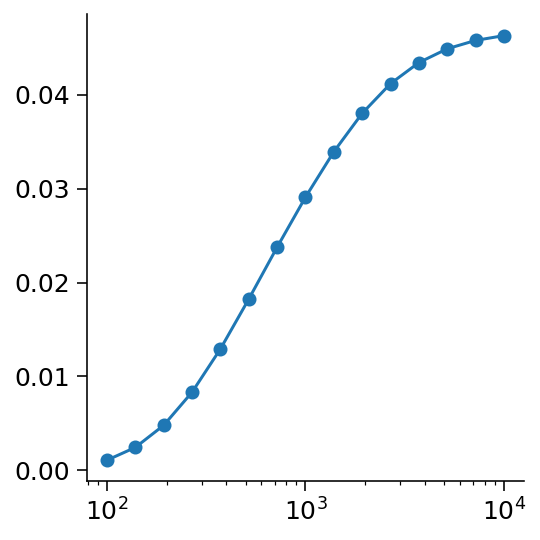

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 2682
Max Corr: 0


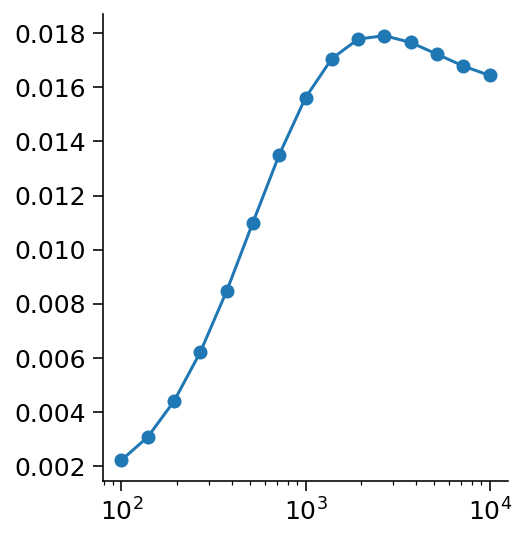

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


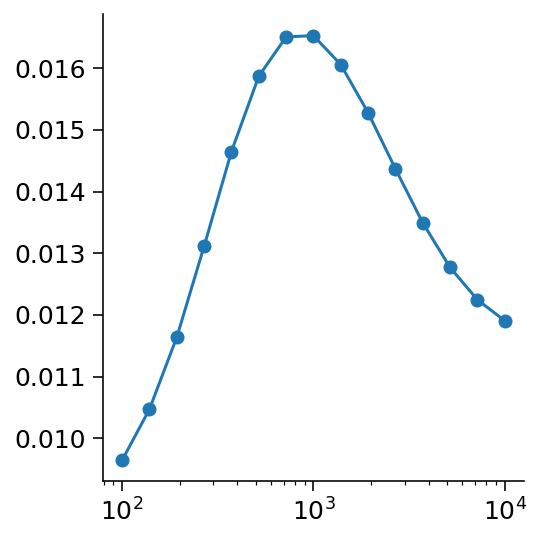

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1389
Max Corr: 0


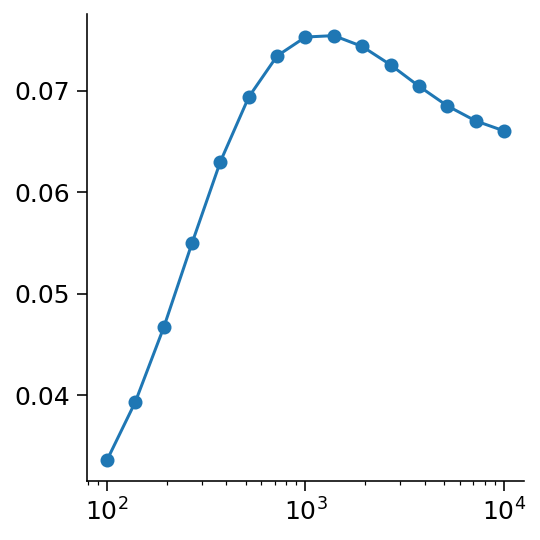

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


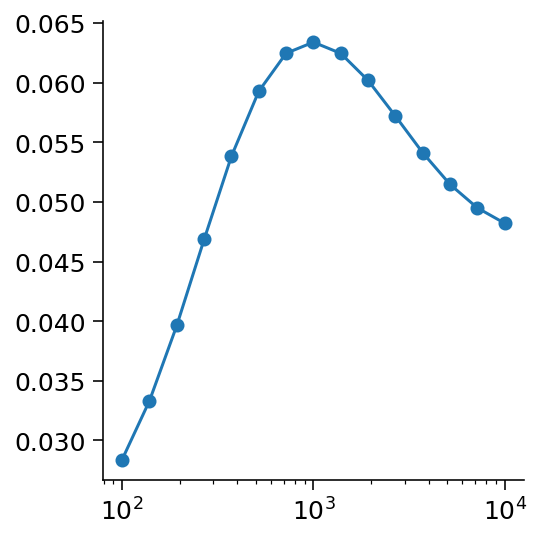

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


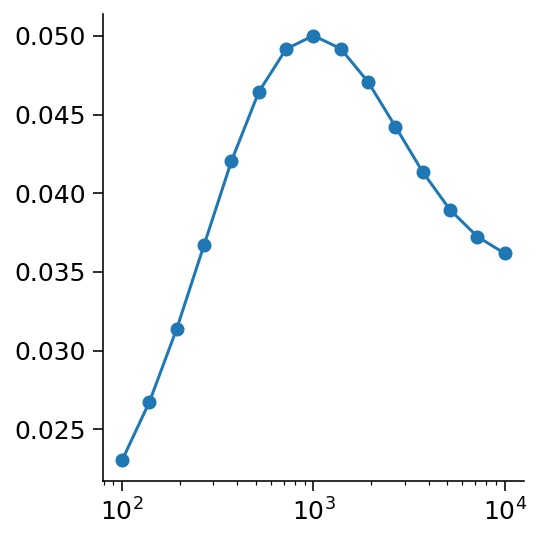

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1389
Max Corr: 0


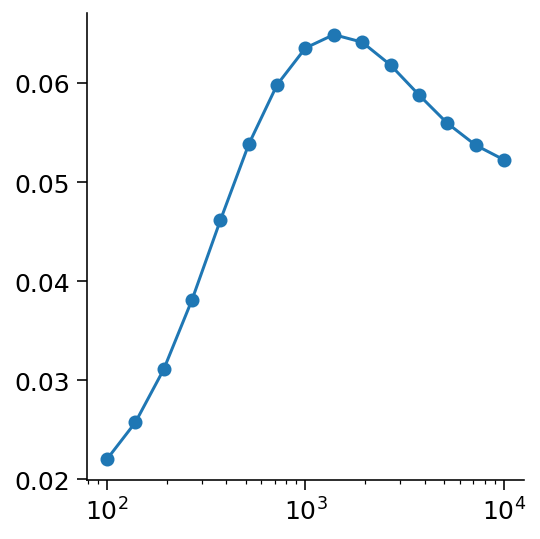

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


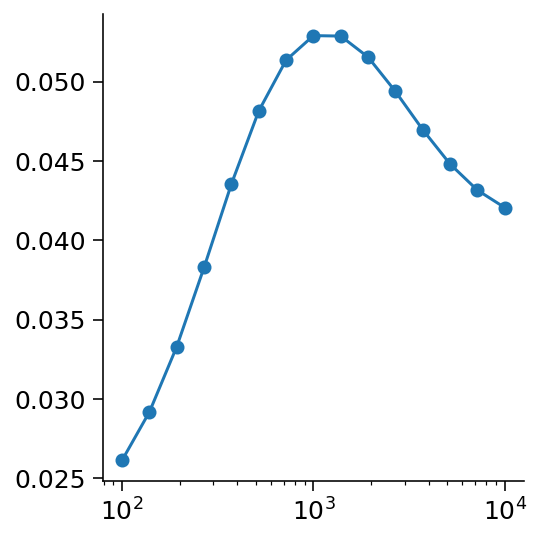

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1930
Max Corr: 0


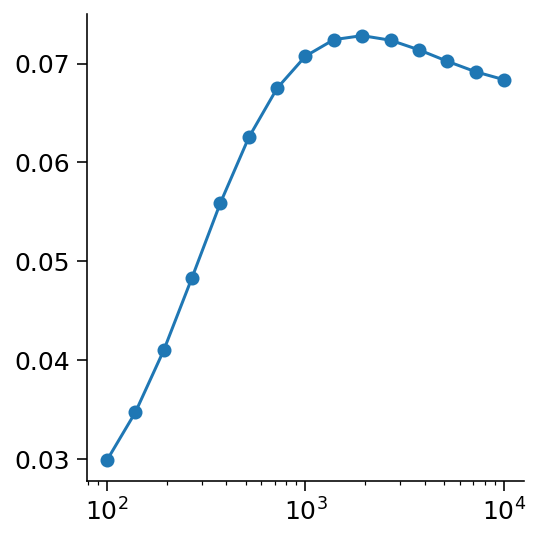

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 3727
Max Corr: 0


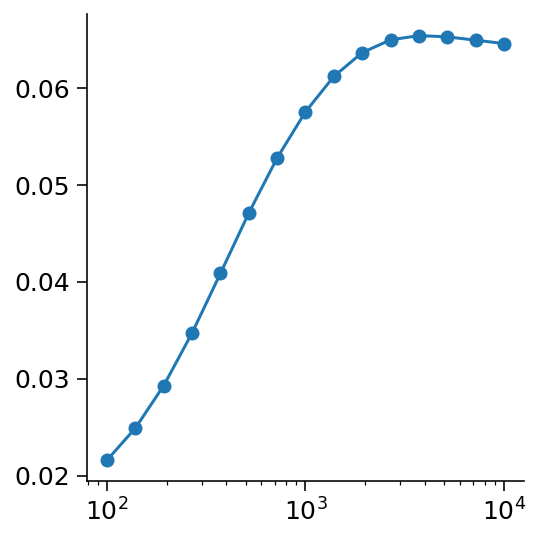

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 5179
Max Corr: 0


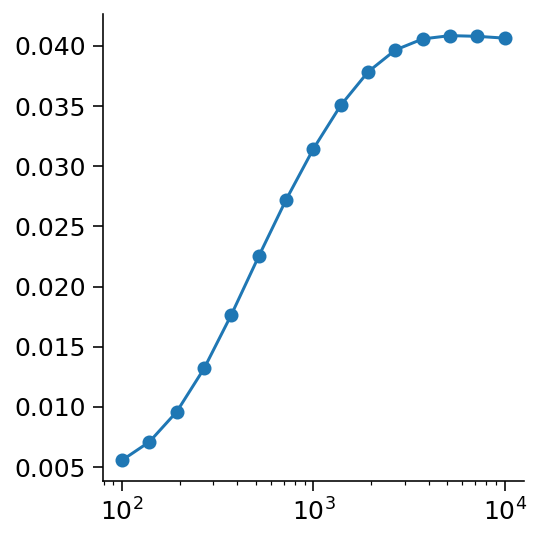

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1000
Max Corr: 0


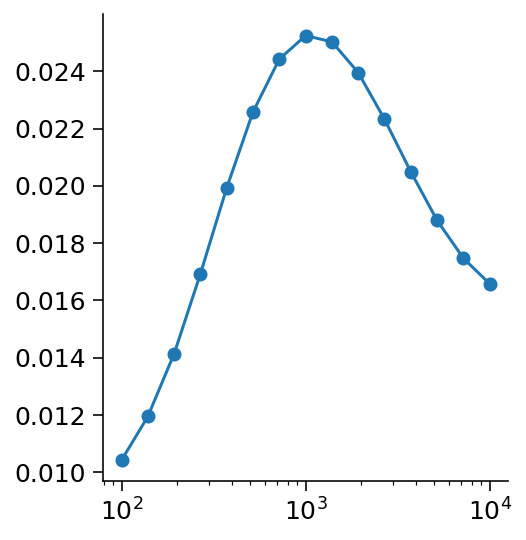

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


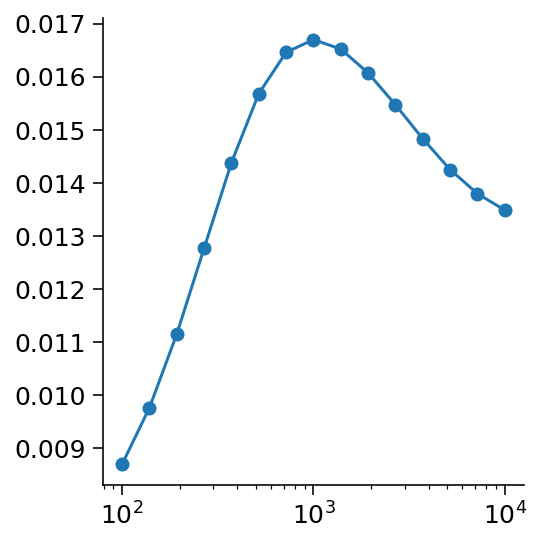

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1389
Max Corr: 0


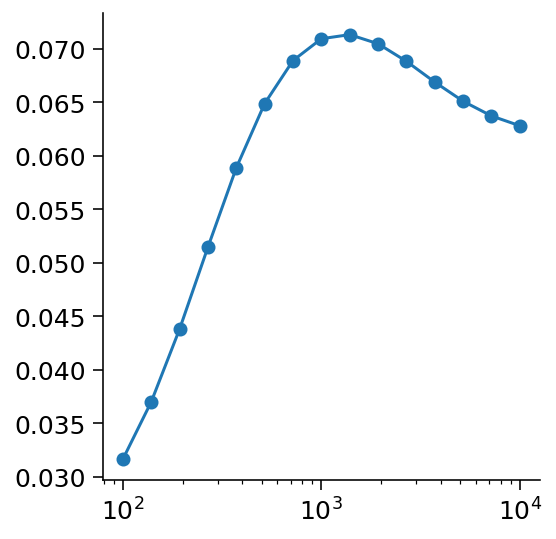

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


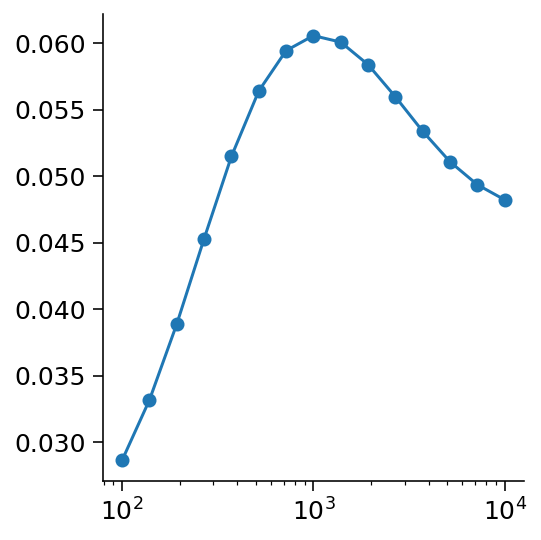

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


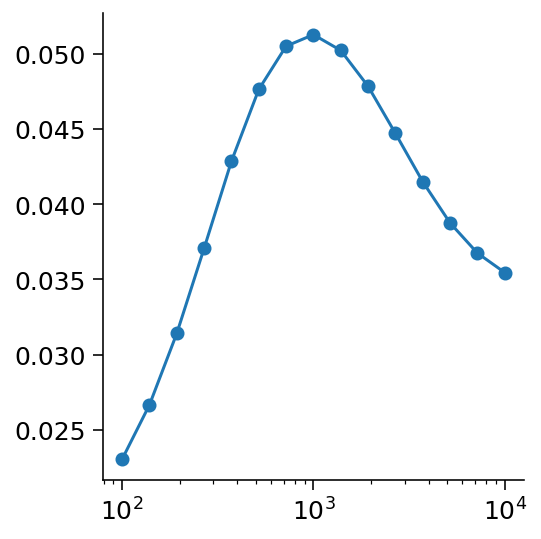

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1389
Max Corr: 0


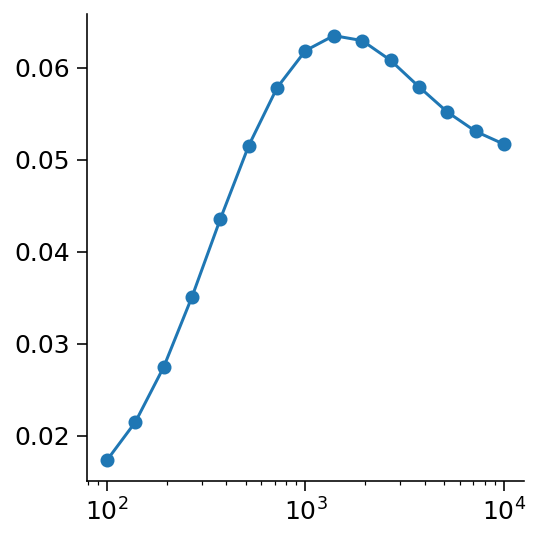

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


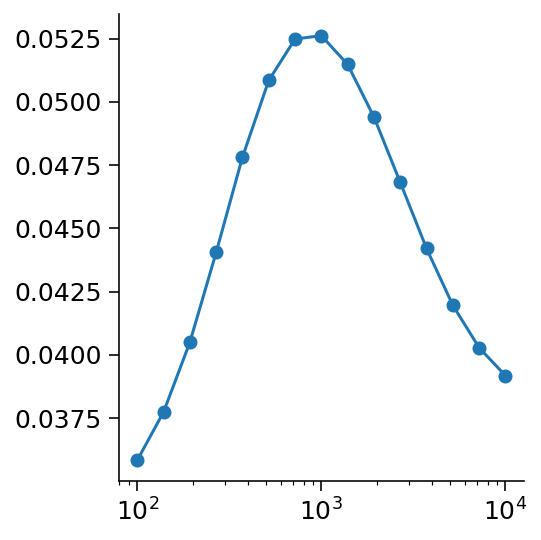

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1930
Max Corr: 0


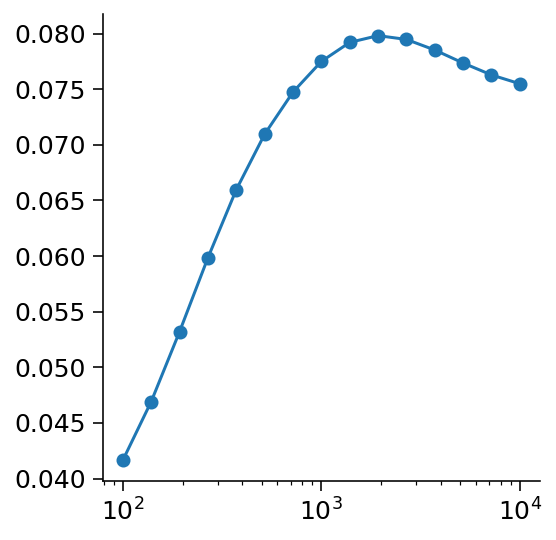

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 5179
Max Corr: 0


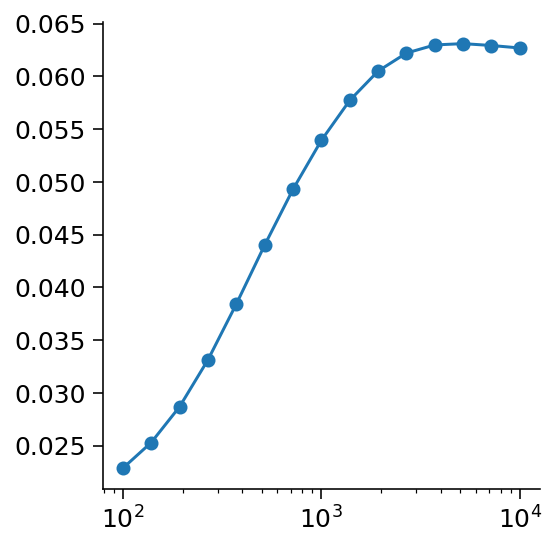

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 7196
Max Corr: 0


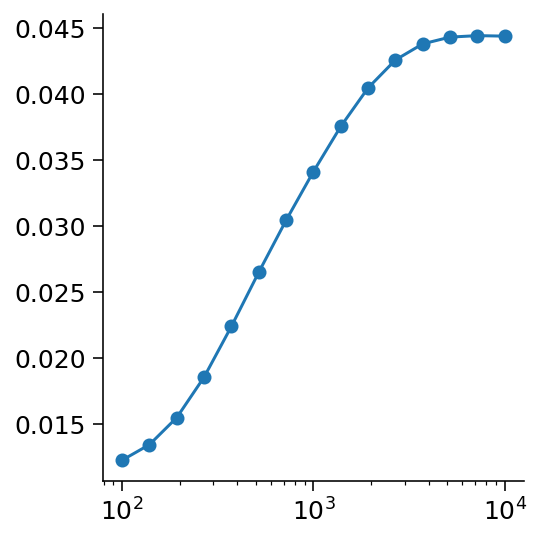

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1000
Max Corr: 0


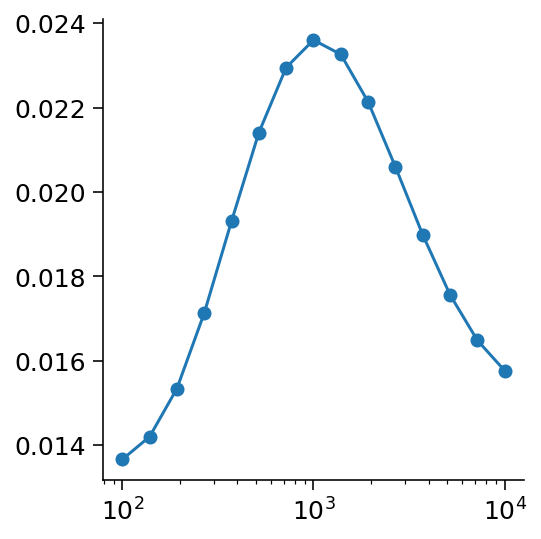

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


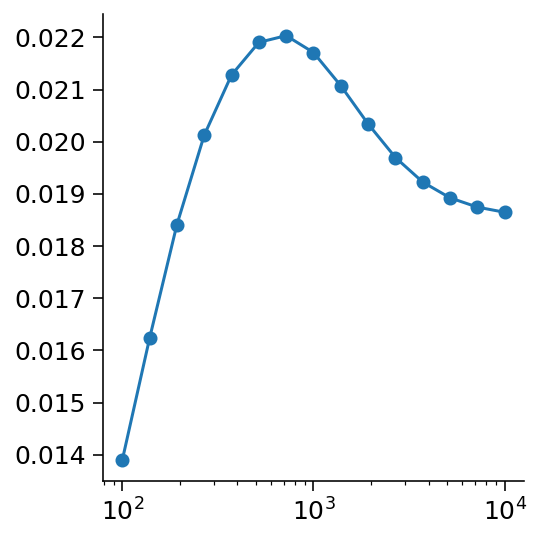

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


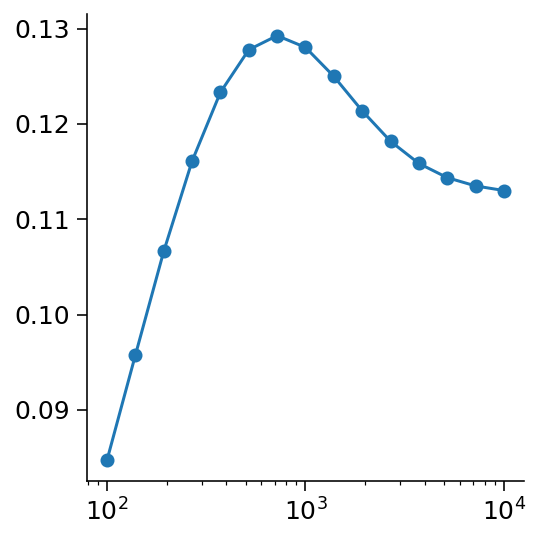

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


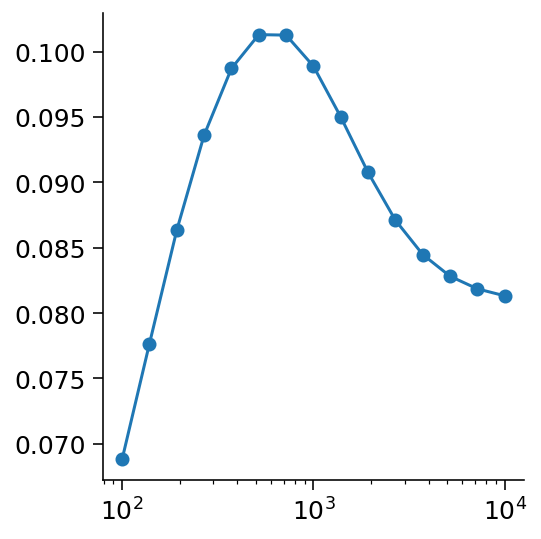

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


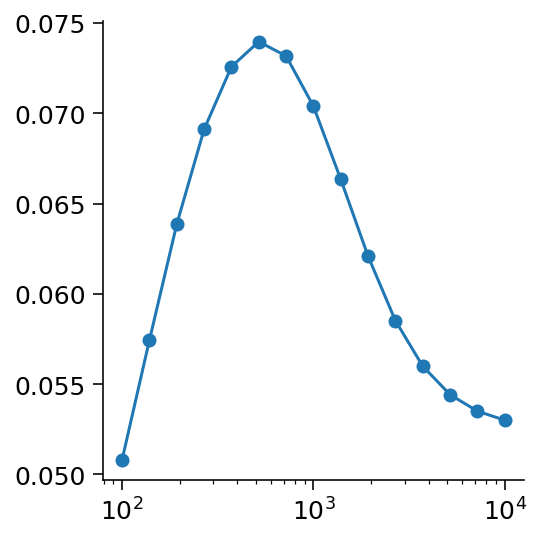

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


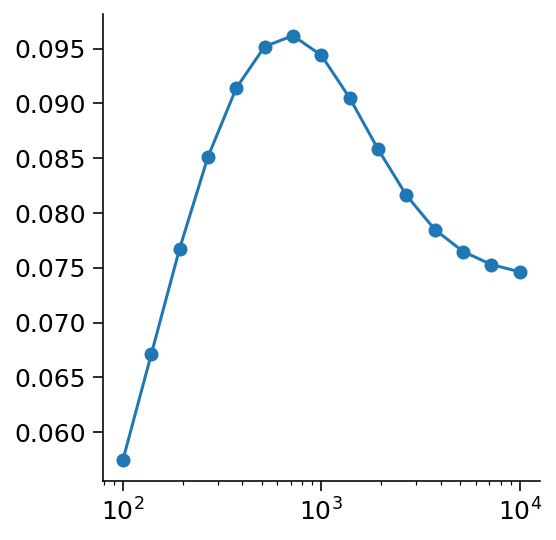

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 517
Max Corr: 0


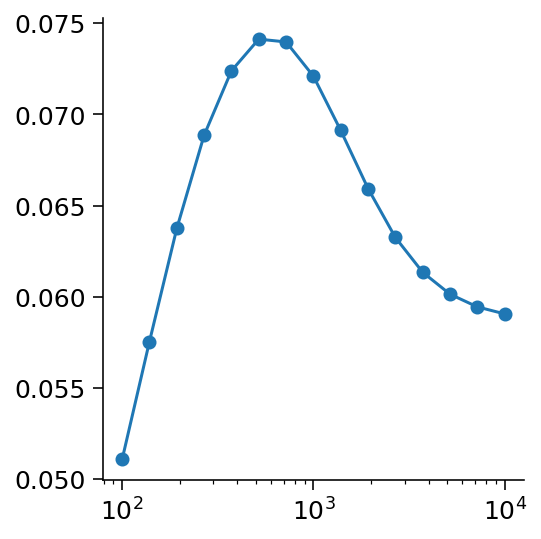

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1000
Max Corr: 0


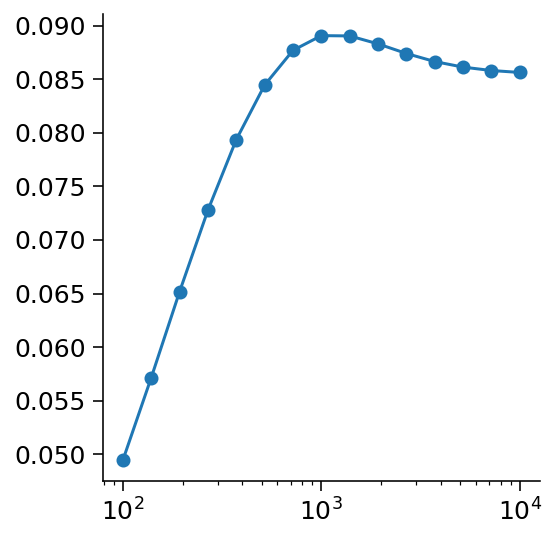

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


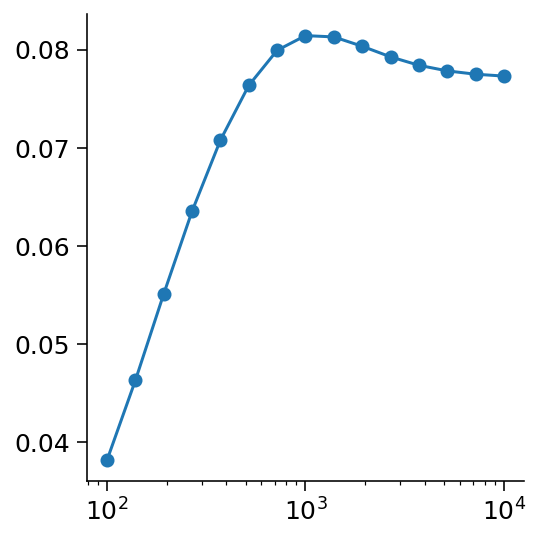

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


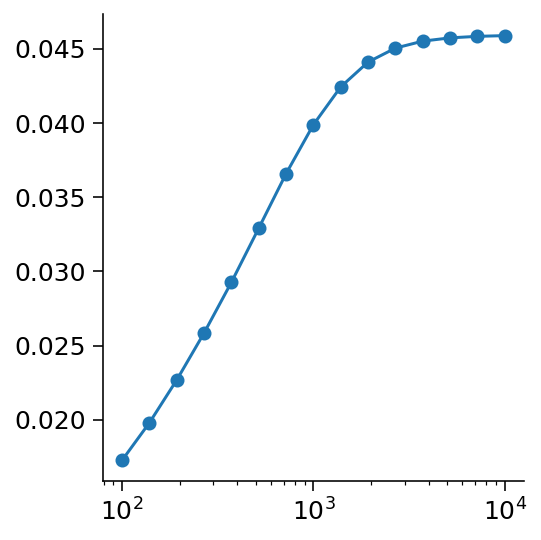

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


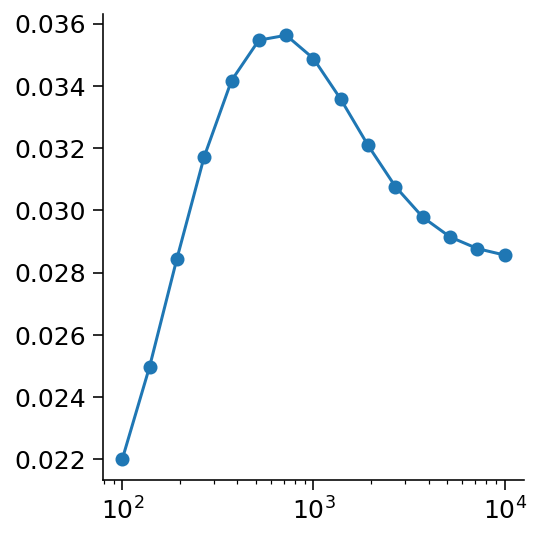

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1389
Max Corr: 0


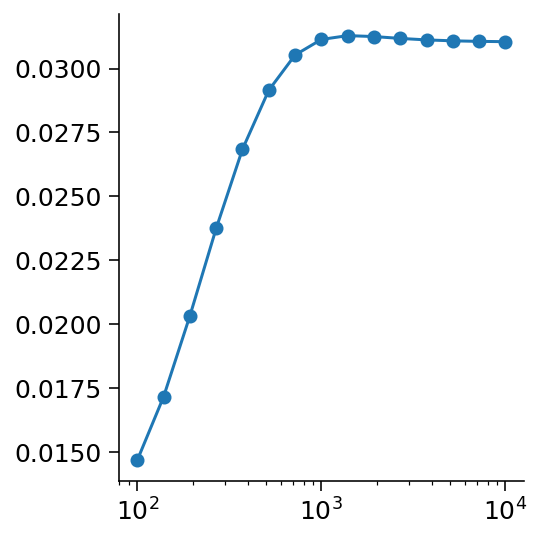

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1000
Max Corr: 0


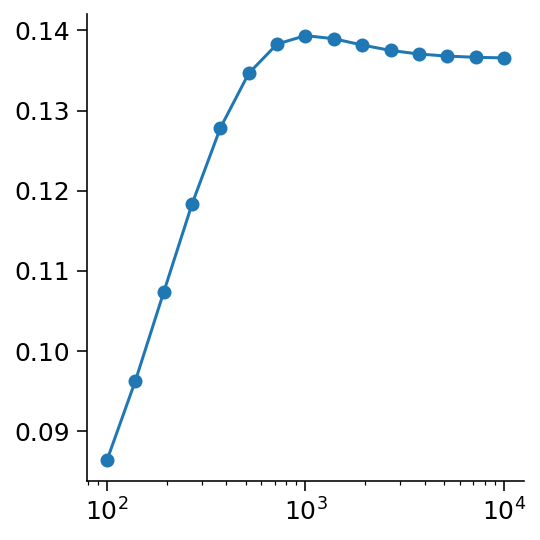

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


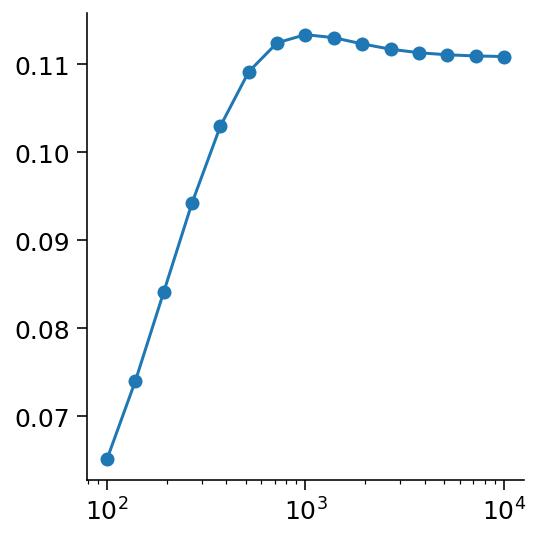

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


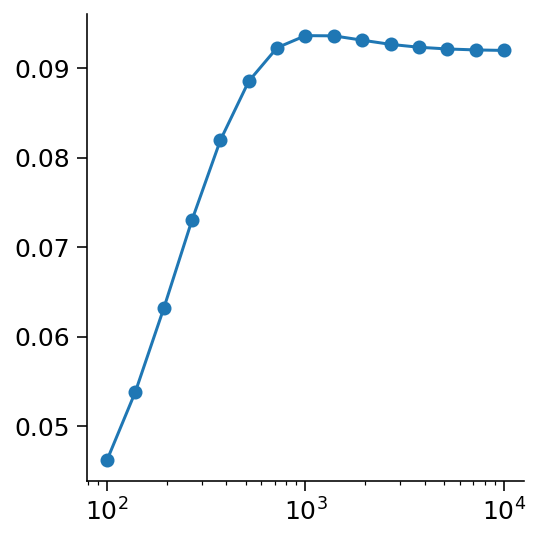

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1389
Max Corr: 0


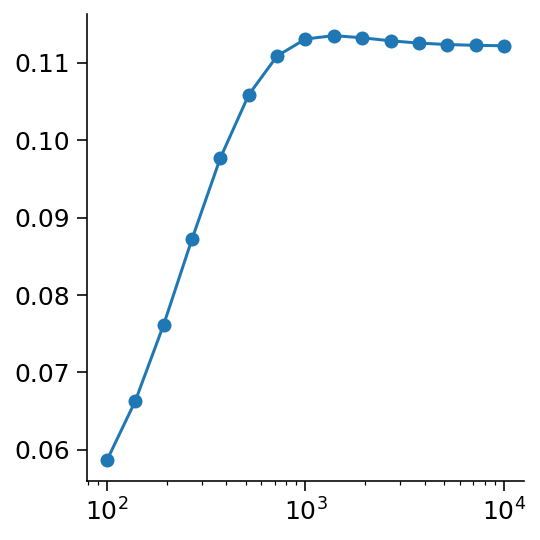

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1389
Max Corr: 0


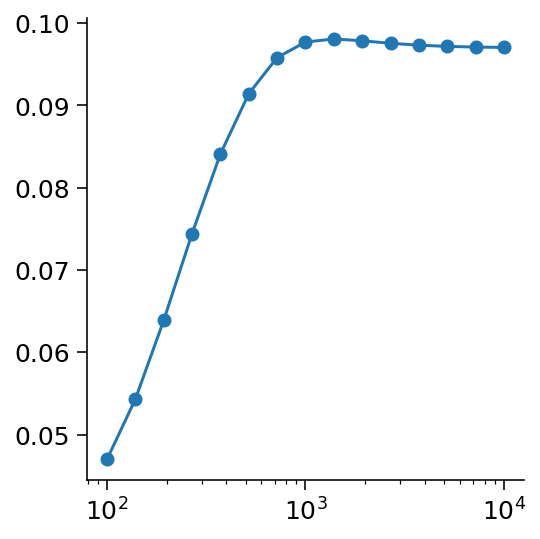

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


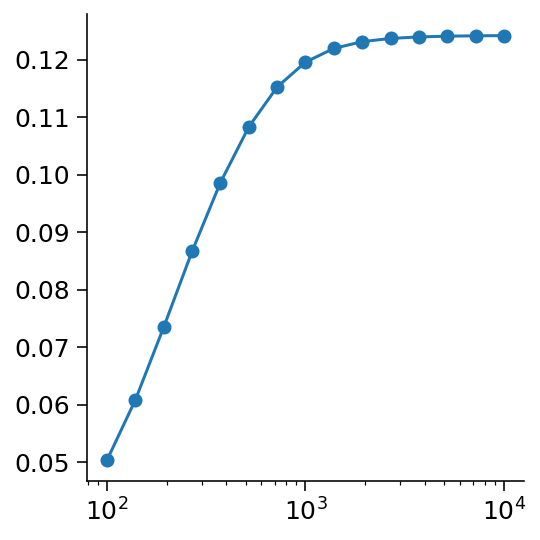

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


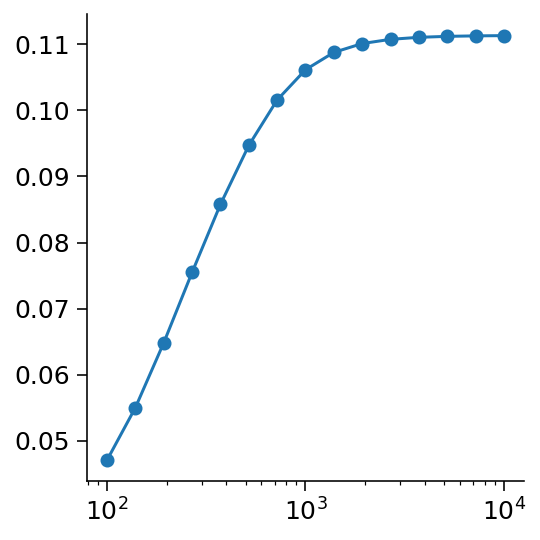

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


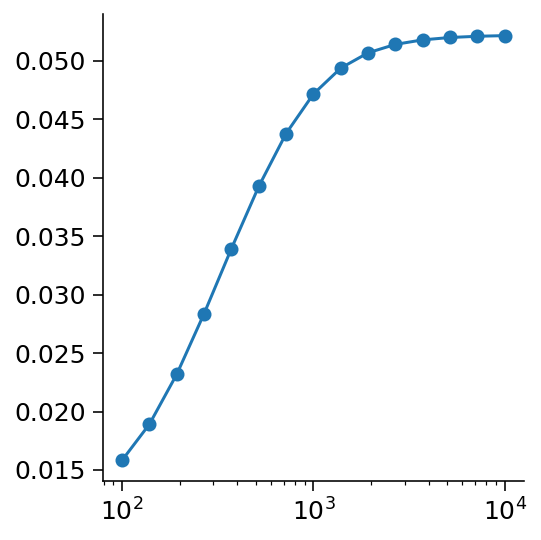

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


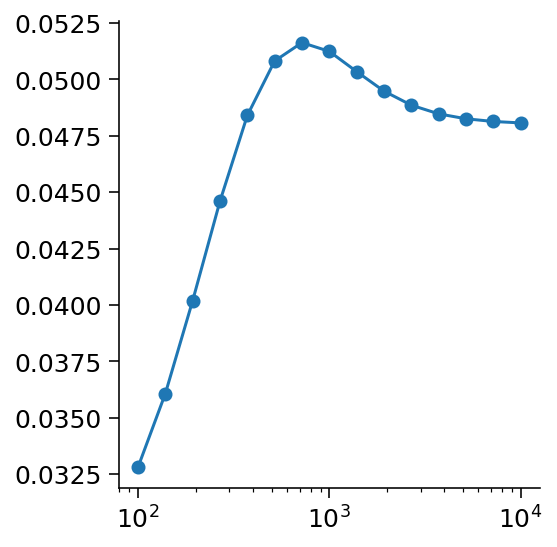

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 10000
Max Corr: 0


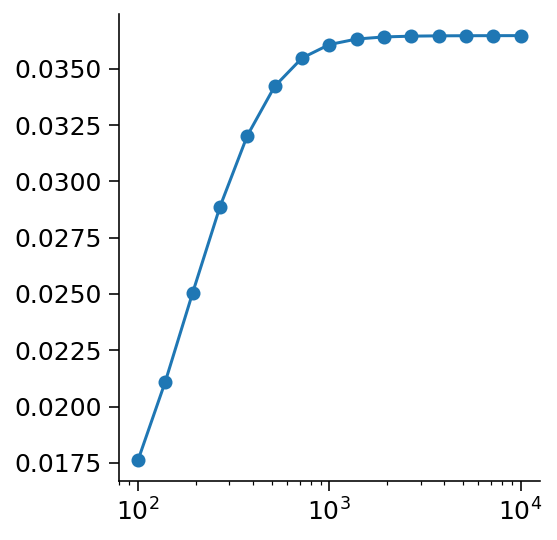

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


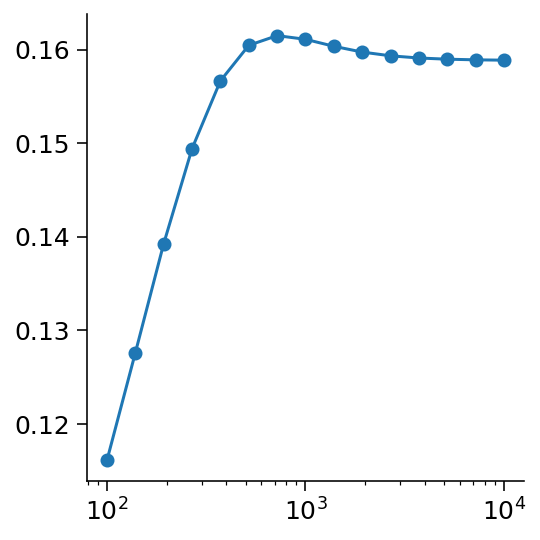

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


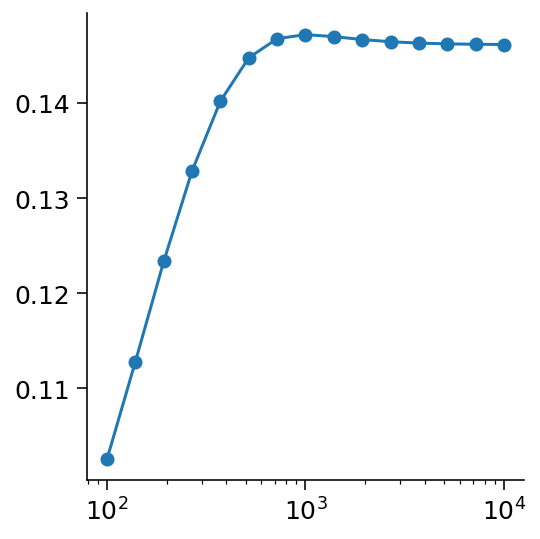

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1389
Max Corr: 0


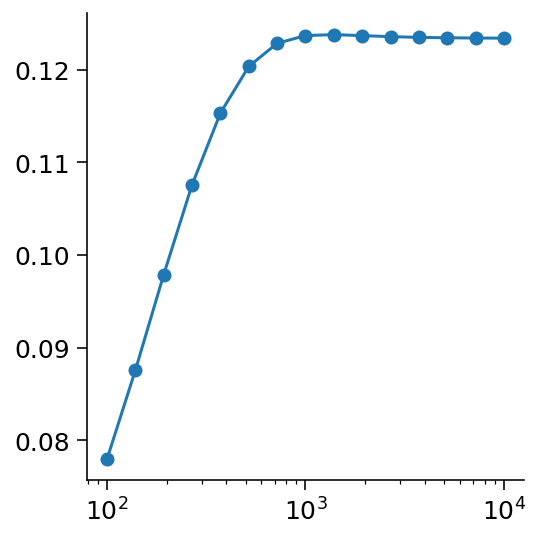

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1930
Max Corr: 0


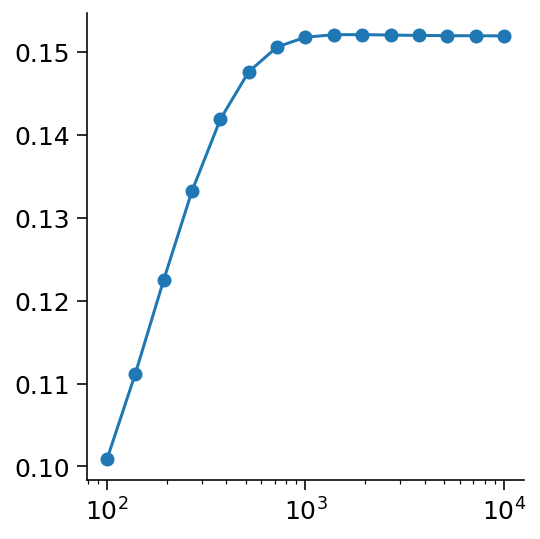

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1930
Max Corr: 0


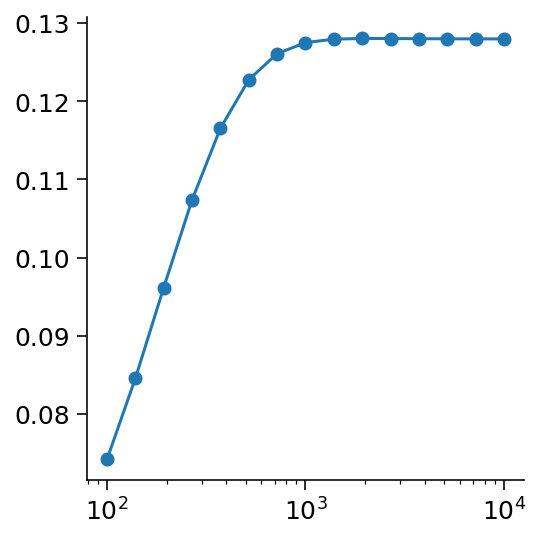

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


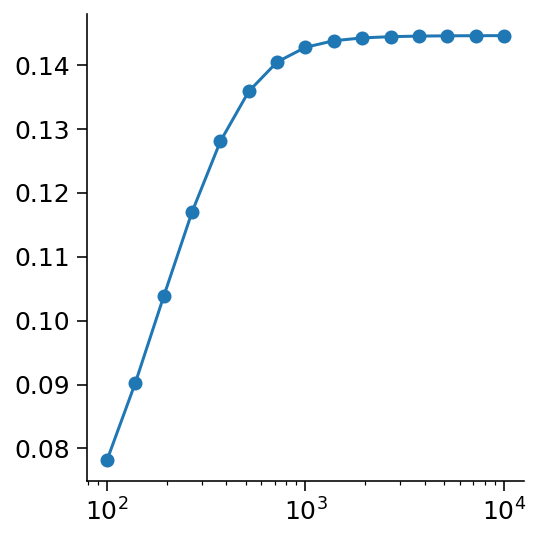

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


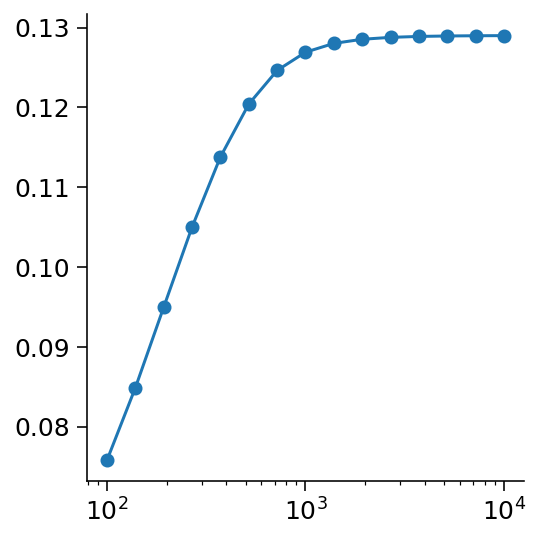

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


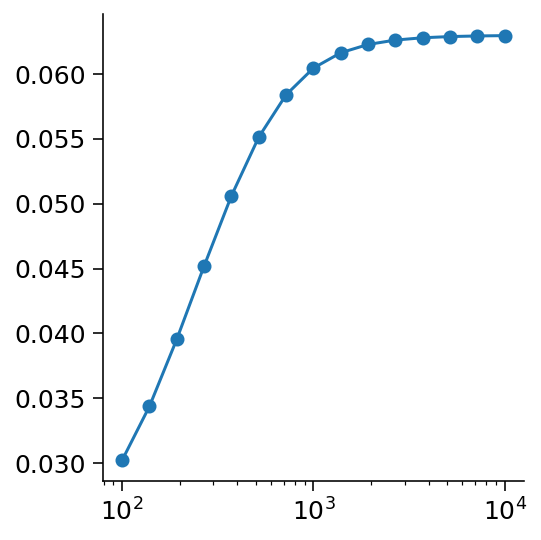

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


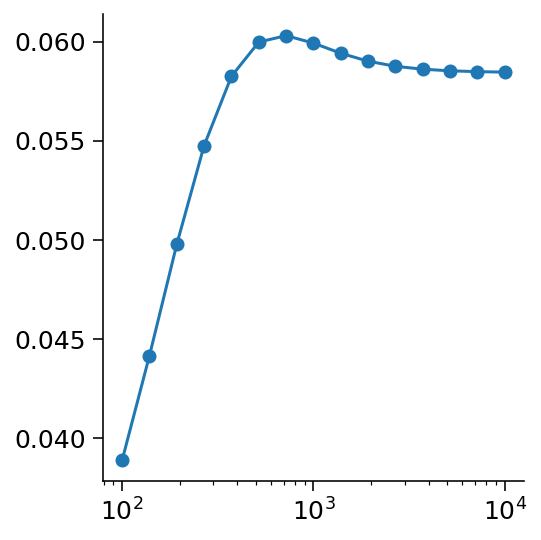

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1930
Max Corr: 0


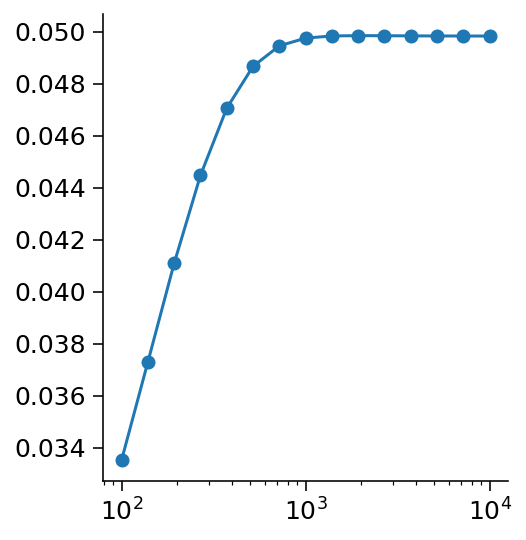

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 517
Max Corr: 0


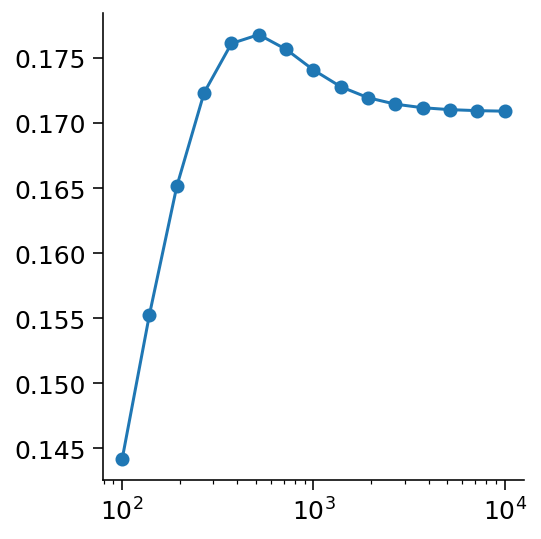

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


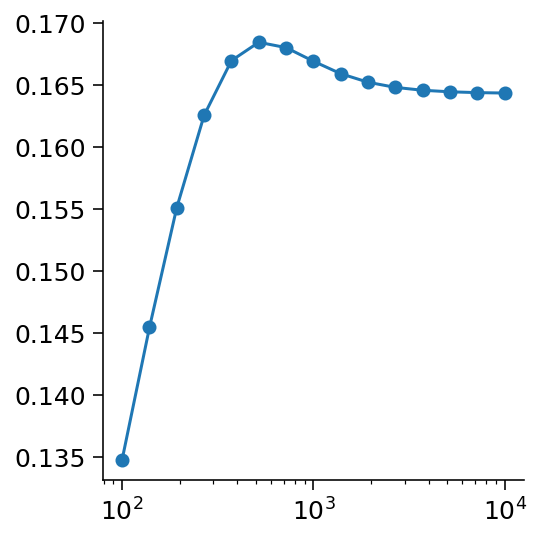

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 719
Max Corr: 0


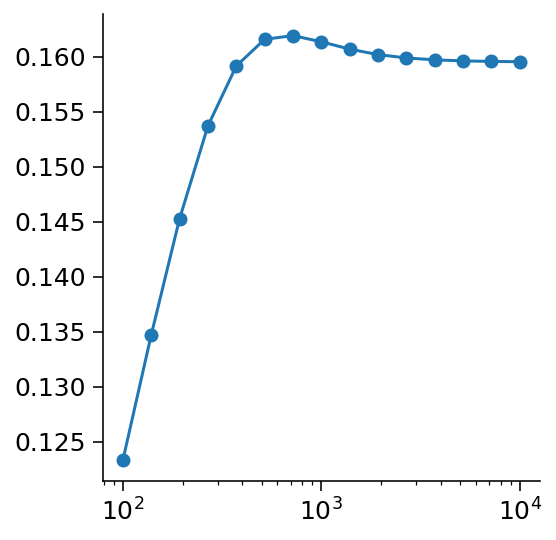

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


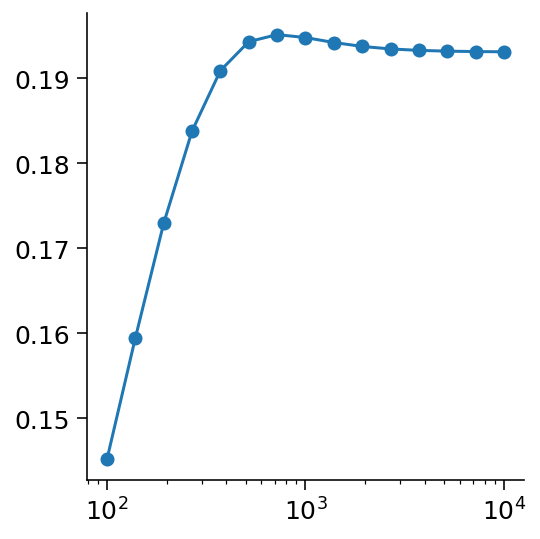

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


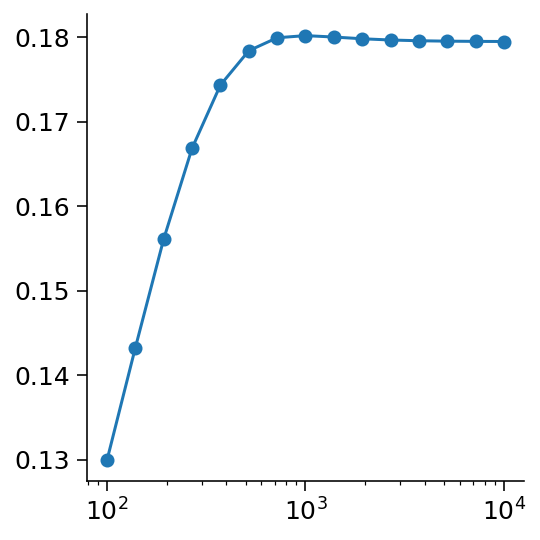

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 517
Max Corr: 0


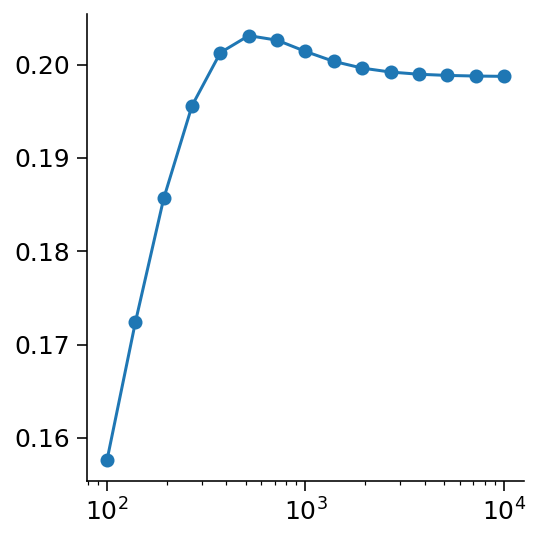

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


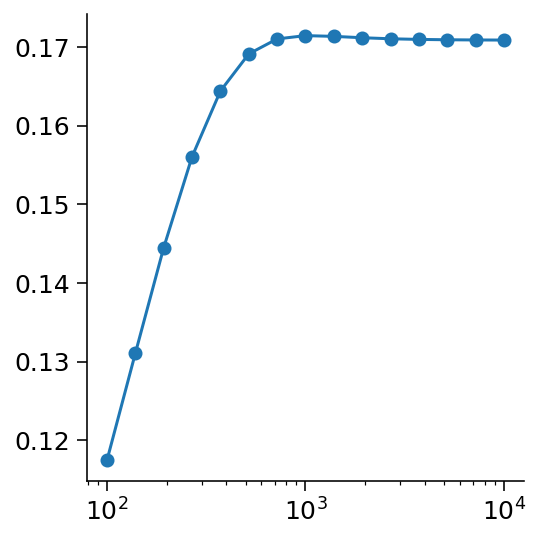

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


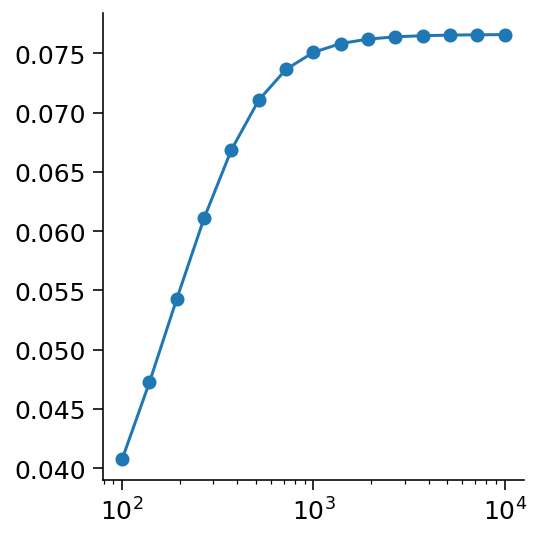

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 517
Max Corr: 0


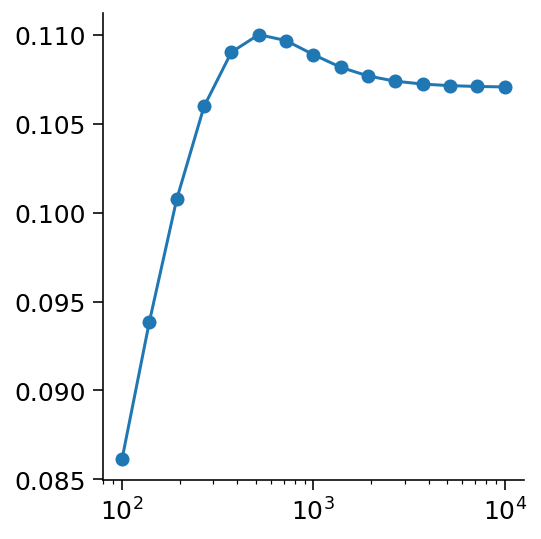

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


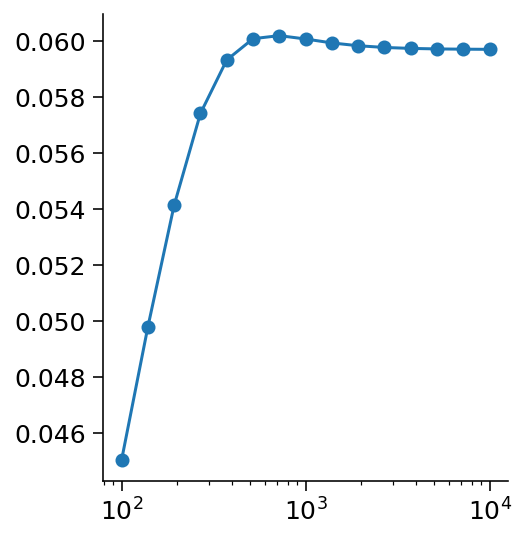

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 517
Max Corr: 0


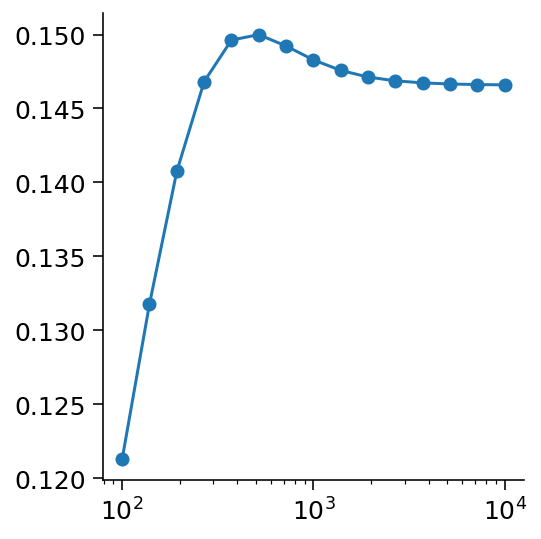

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


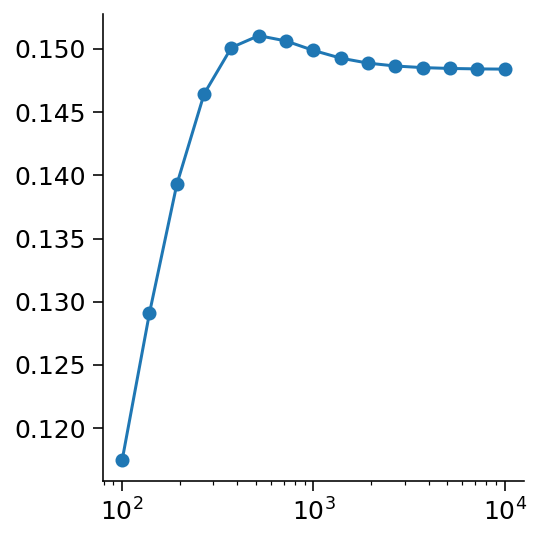

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 719
Max Corr: 0


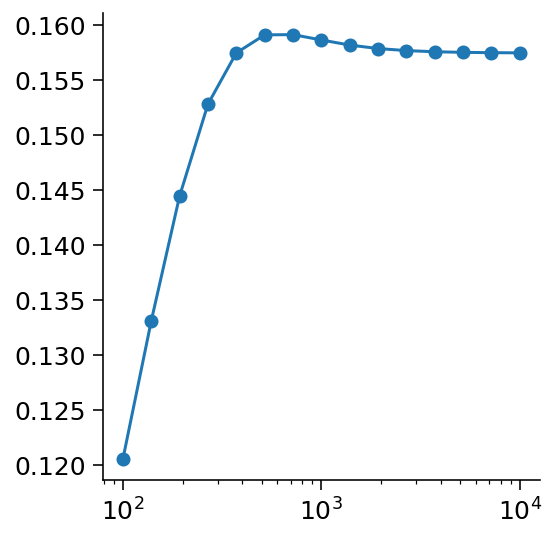

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 517
Max Corr: 0


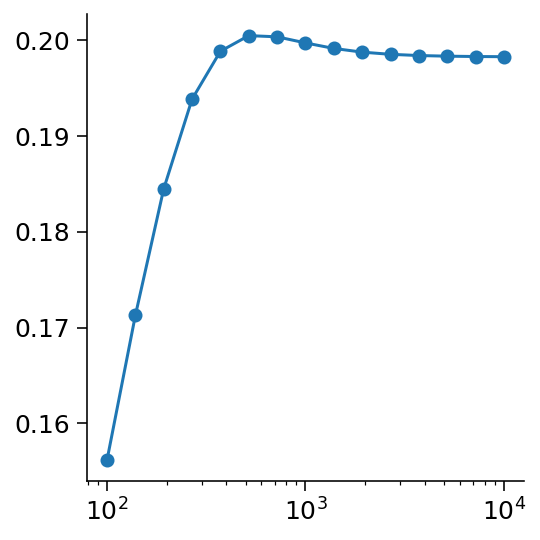

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 517
Max Corr: 0


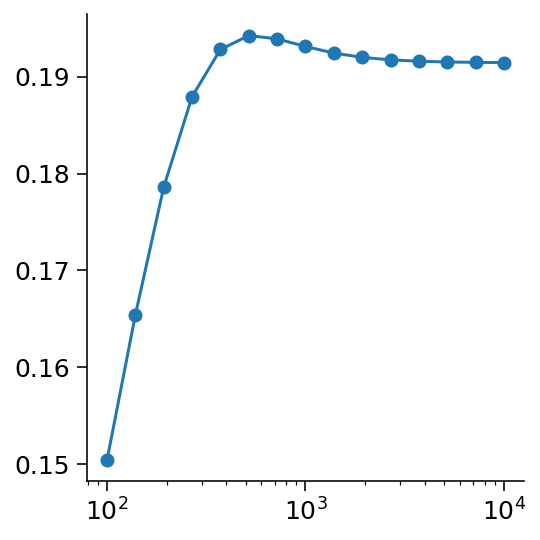

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 517
Max Corr: 0


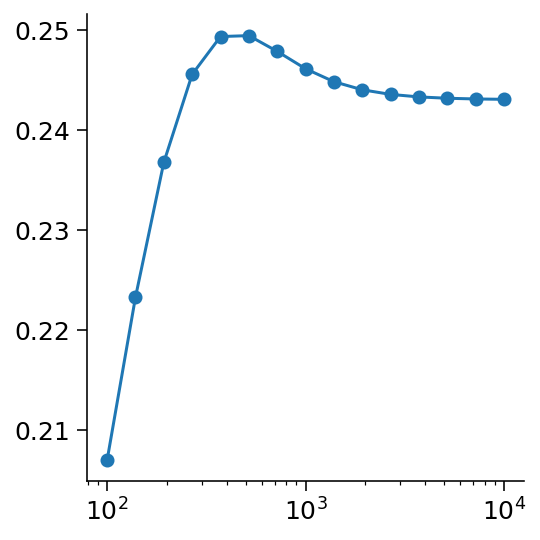

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 719
Max Corr: 0


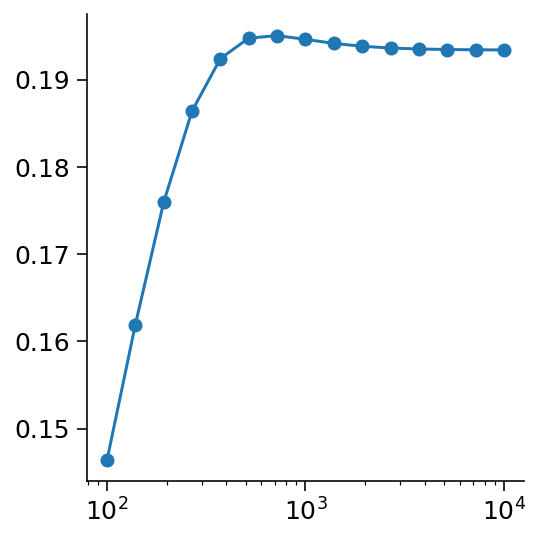

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 1389
Max Corr: 0


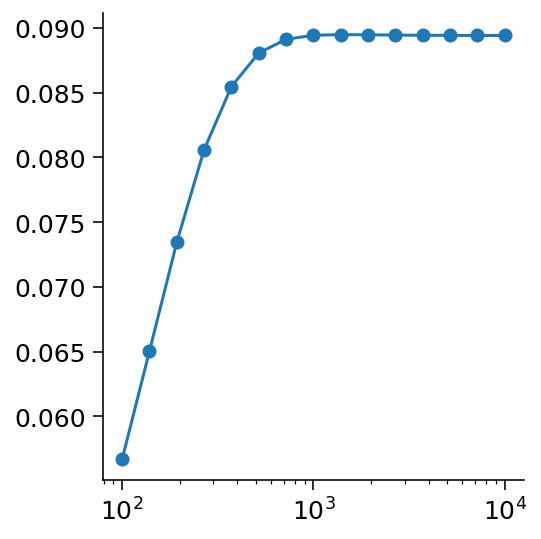

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 372
Max Corr: 0


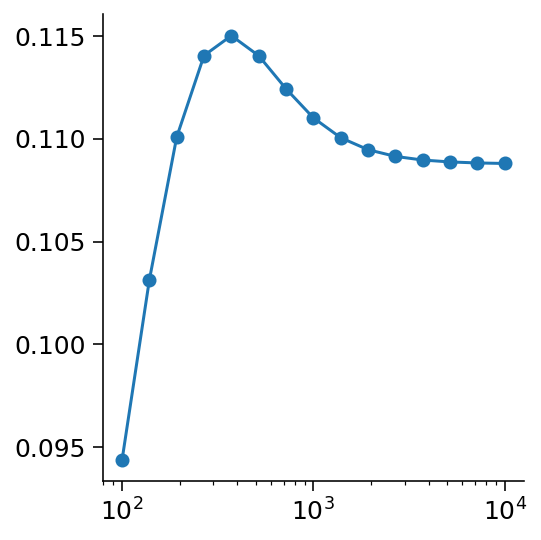

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 138
Max Corr: 0


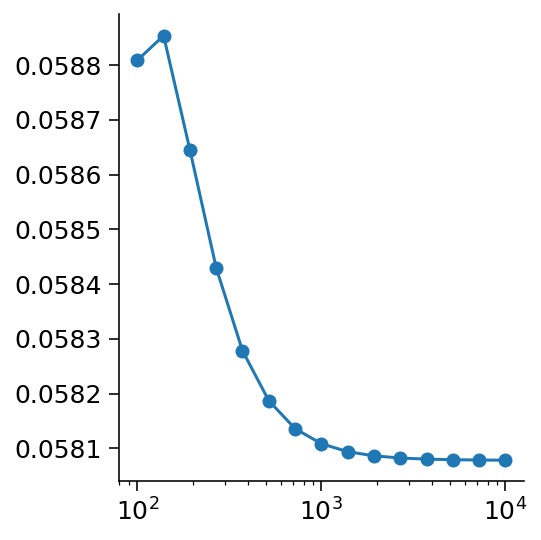

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 100
Max Corr: 0


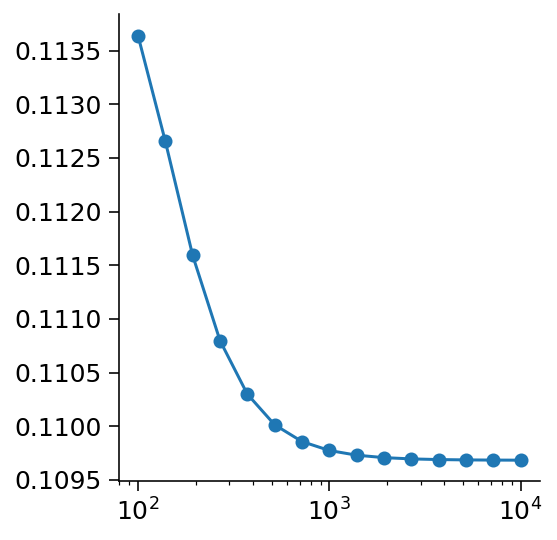

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 100
Max Corr: 0


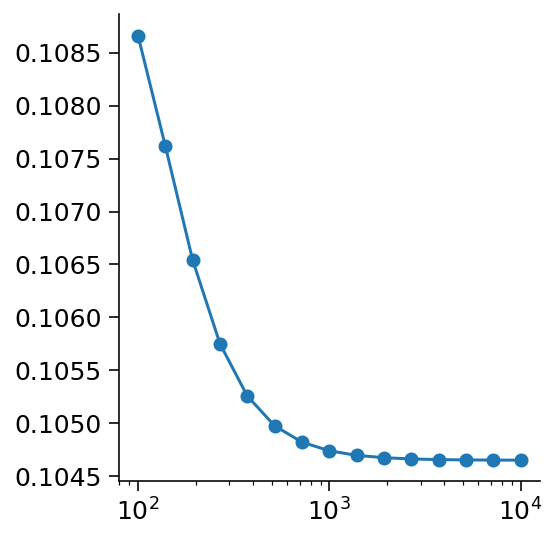

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 138
Max Corr: 0


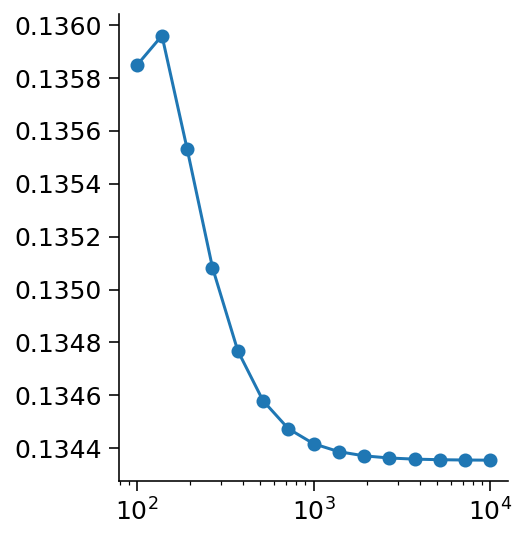

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 100
Max Corr: 0


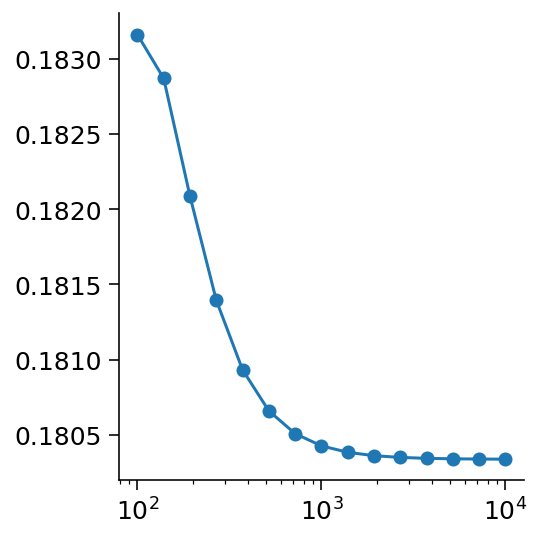

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 138
Max Corr: 0


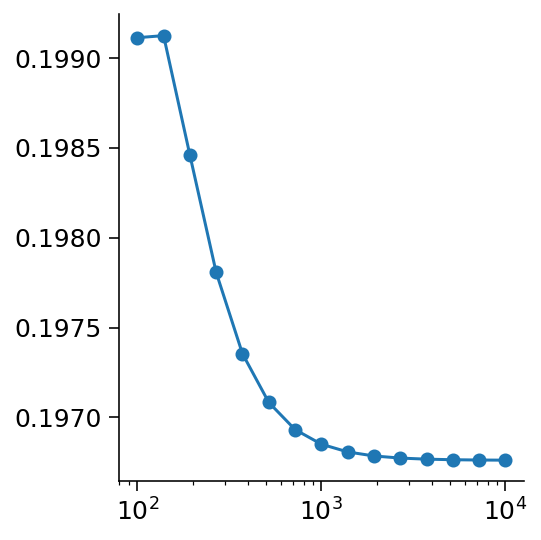

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 100
Max Corr: 0


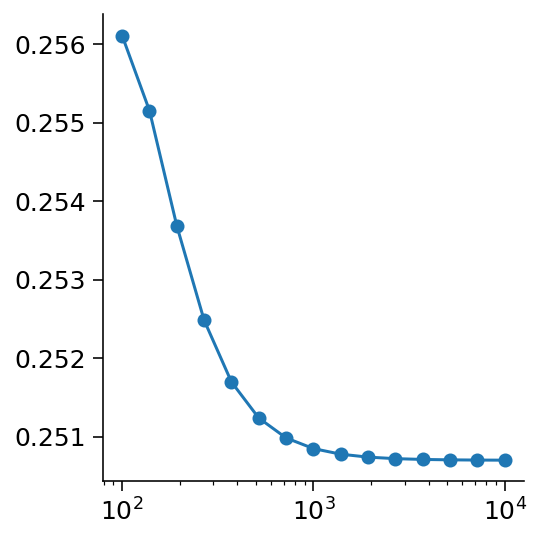

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 100
Max Corr: 0


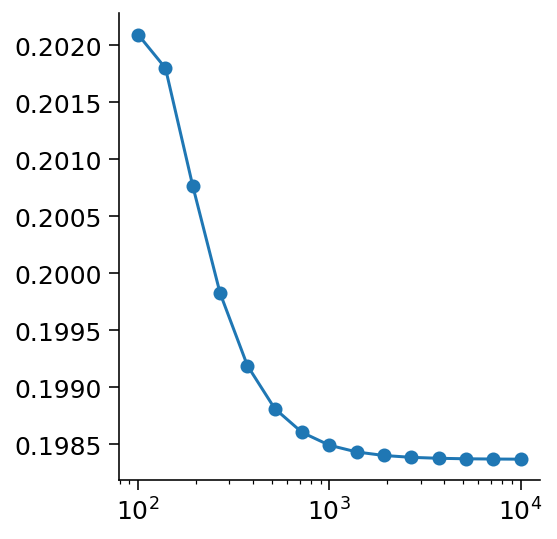

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 517
Max Corr: 0


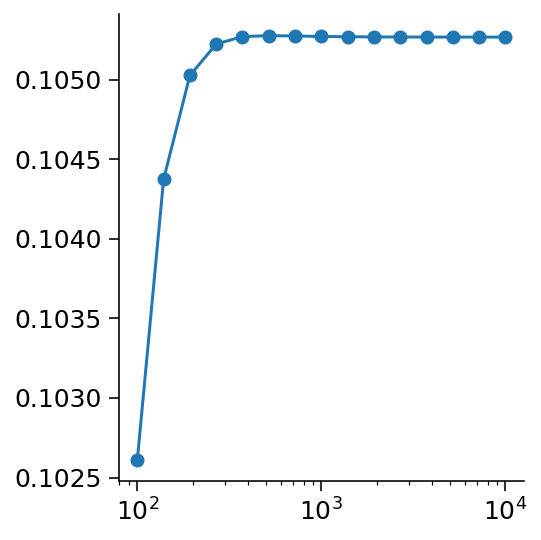

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 100
Max Corr: 0


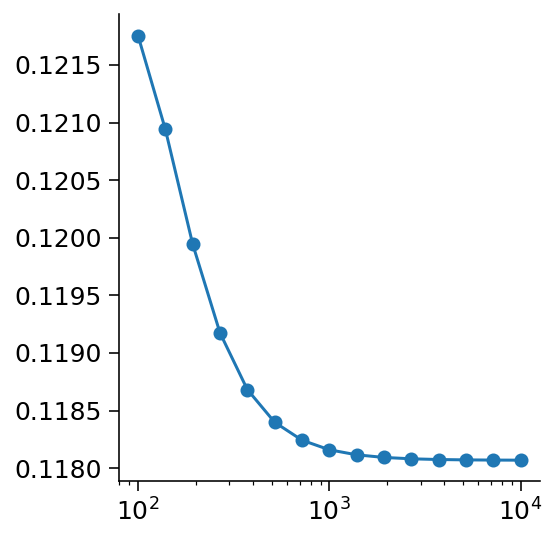

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_9
----------------------------------------------------------------------------


In [ ]:
#@title sub02
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub02"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting sub:  sub03
Starting ROI:  WB  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1389
Max Corr: 0


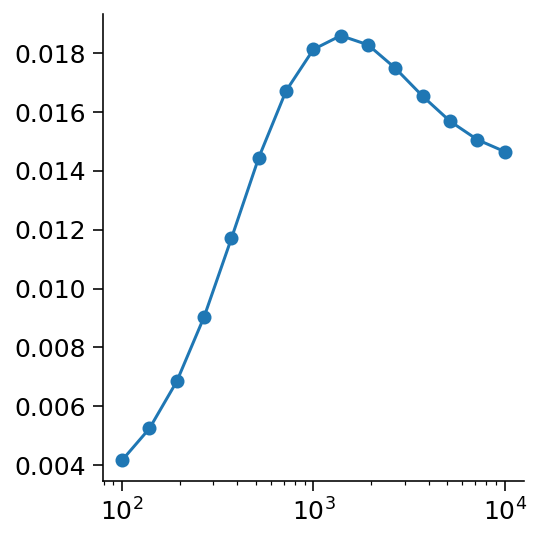

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 7196
Max Corr: 0


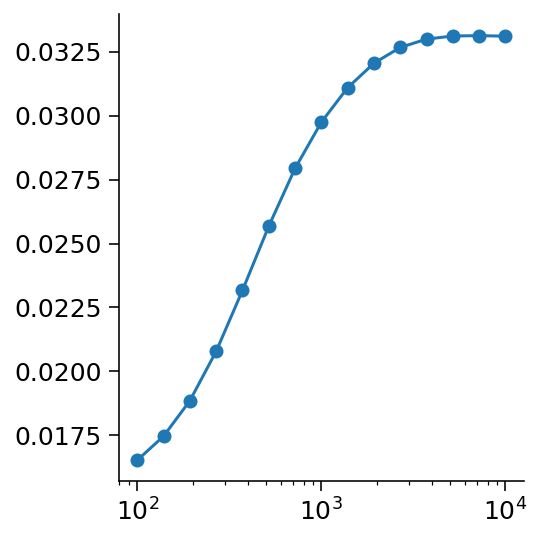

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 2682
Max Corr: 0


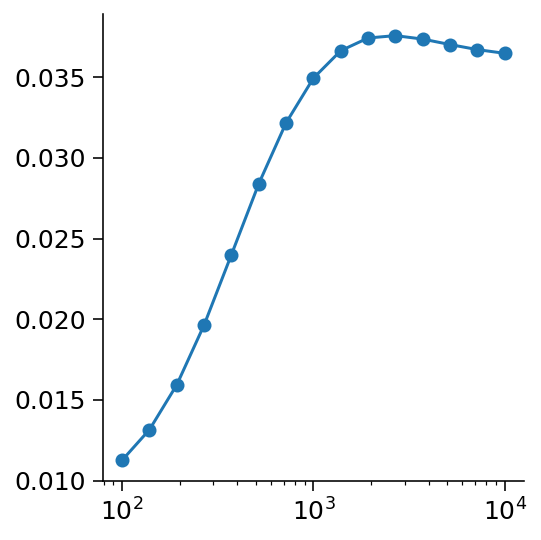

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


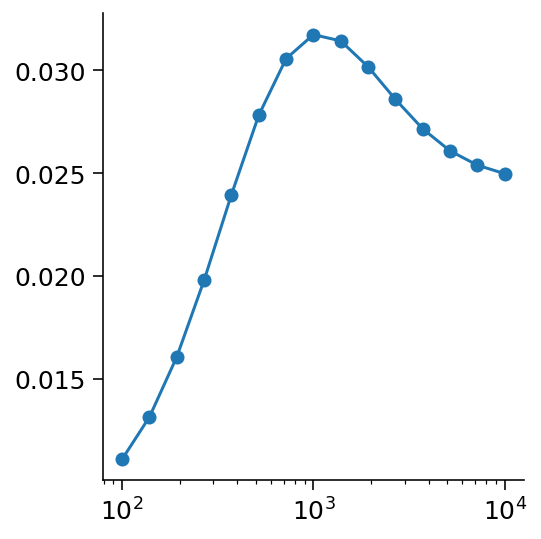

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 10000
Max Corr: 0


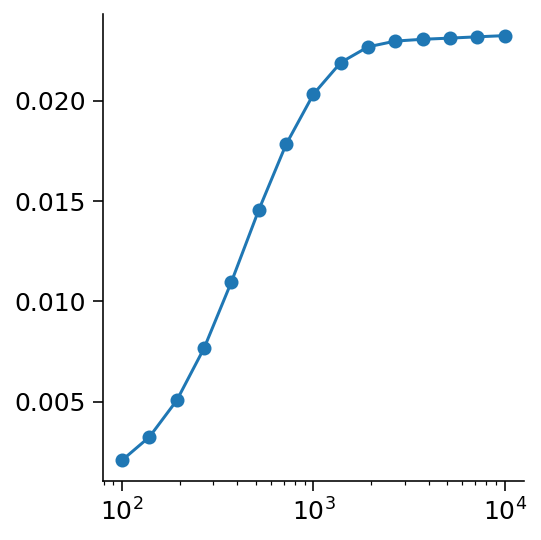

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1389
Max Corr: 0


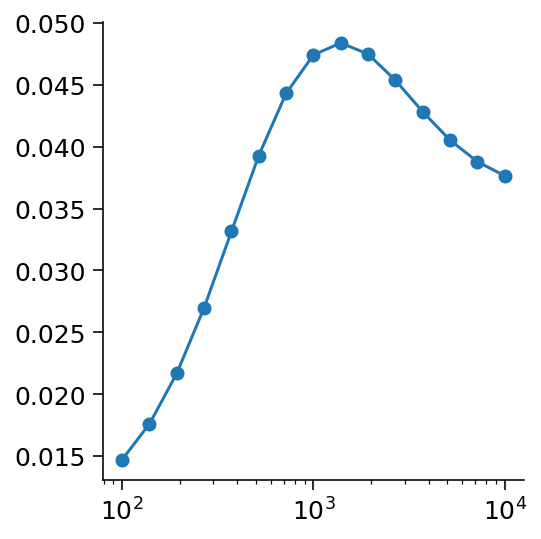

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 2682
Max Corr: 0


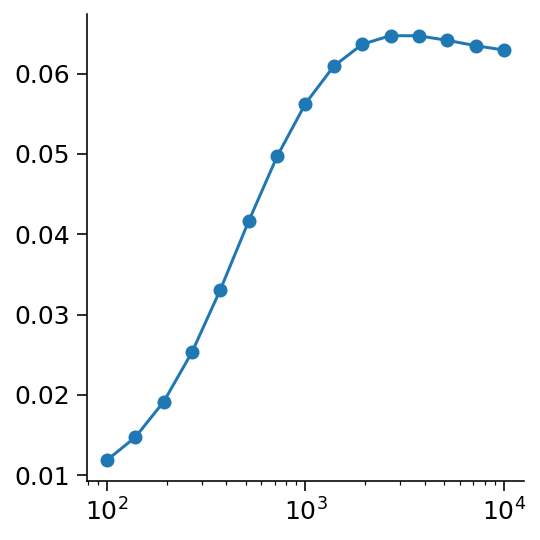

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


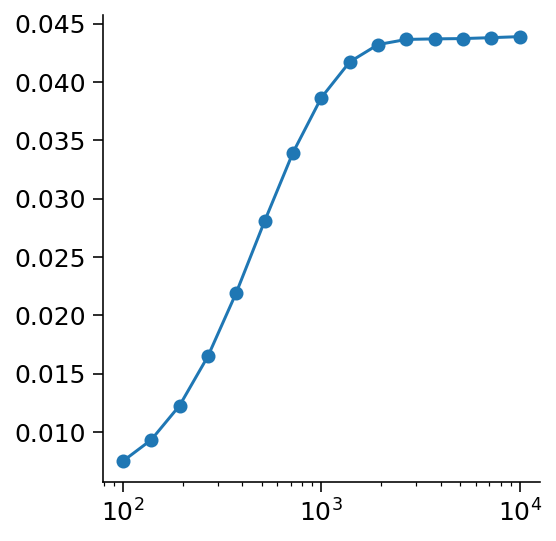

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


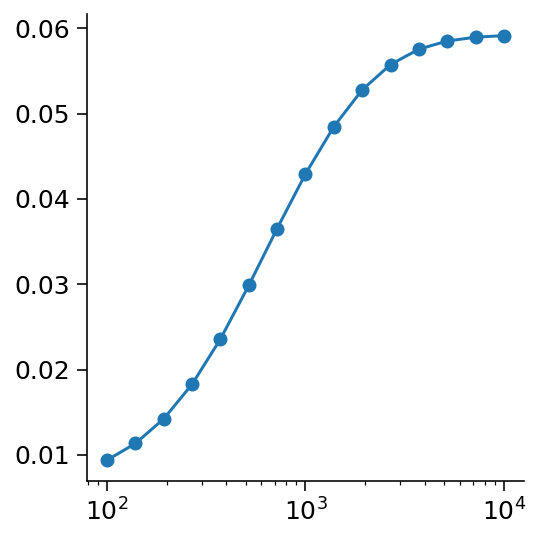

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1000
Max Corr: 0


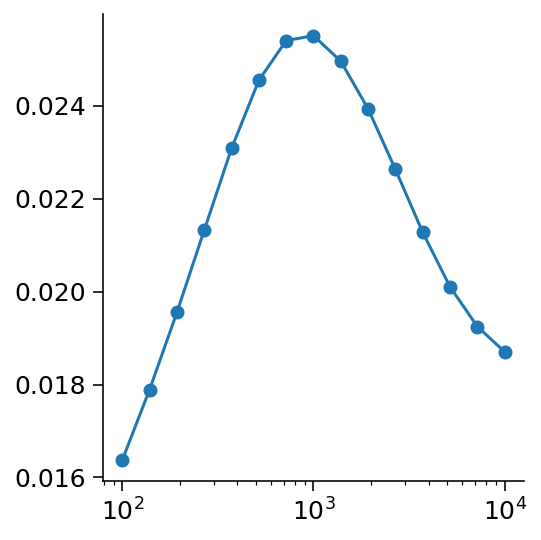

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


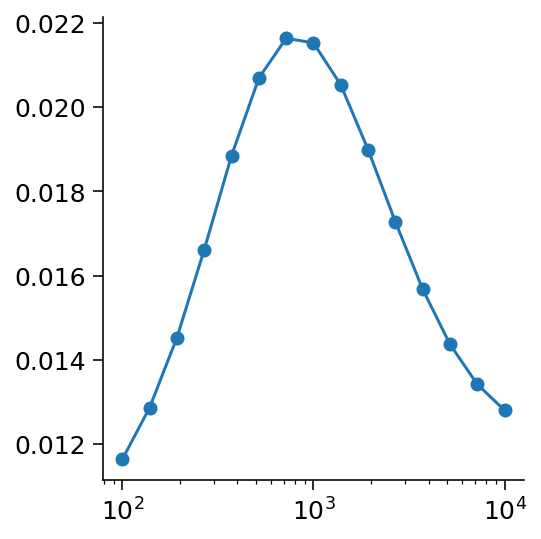

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


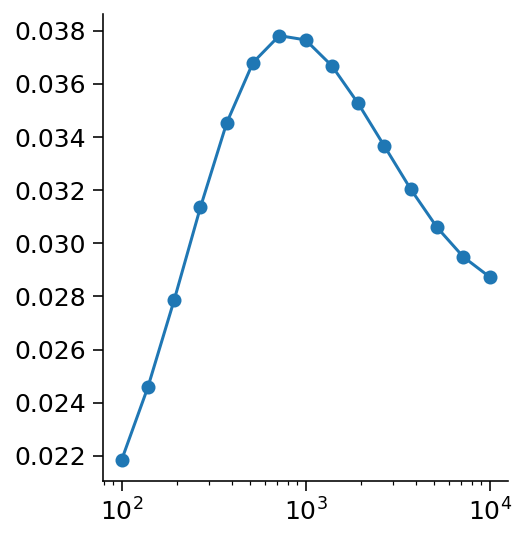

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


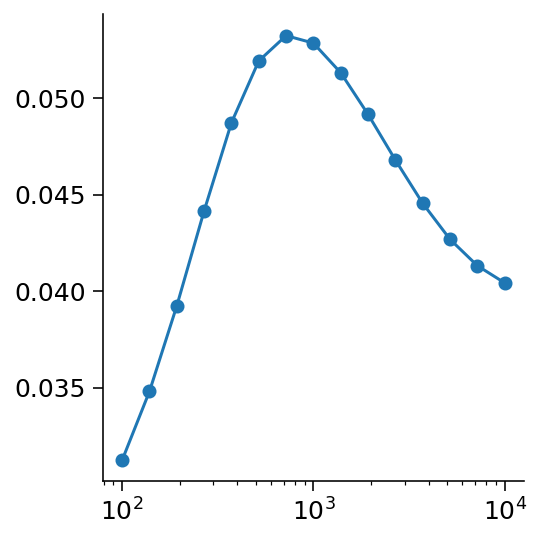

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 719
Max Corr: 0


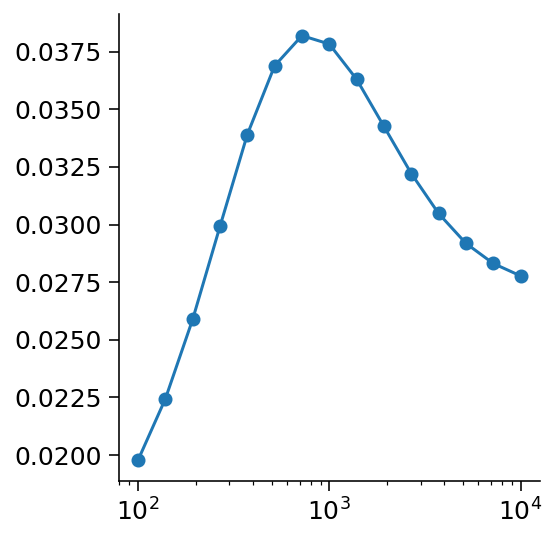

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1000
Max Corr: 0


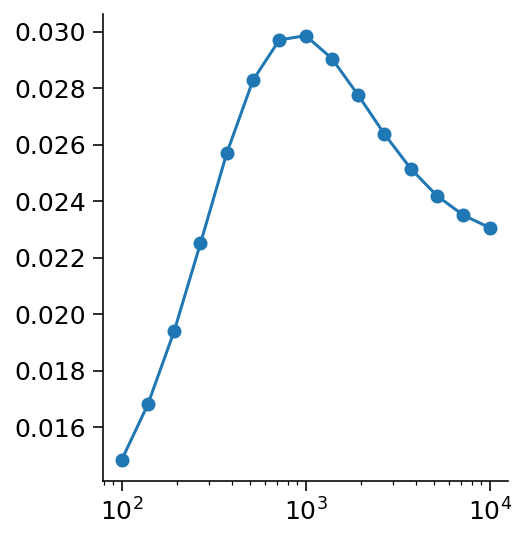

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


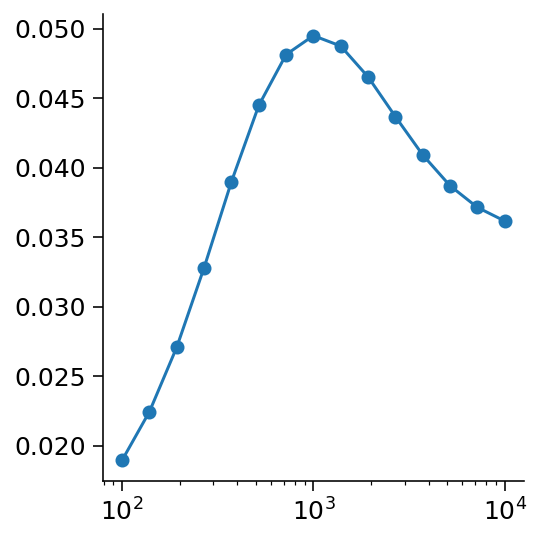

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1389
Max Corr: 0


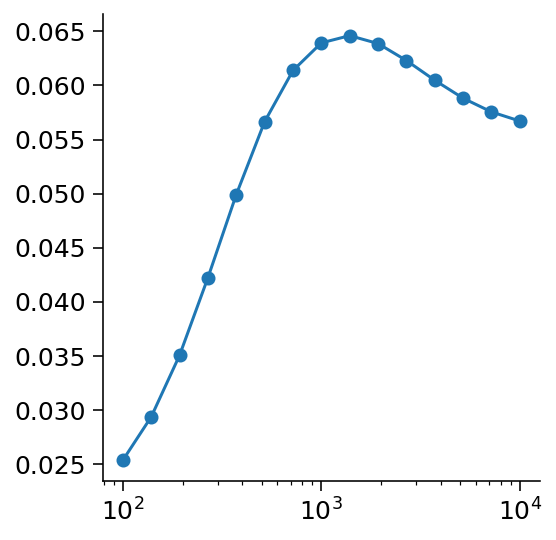

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


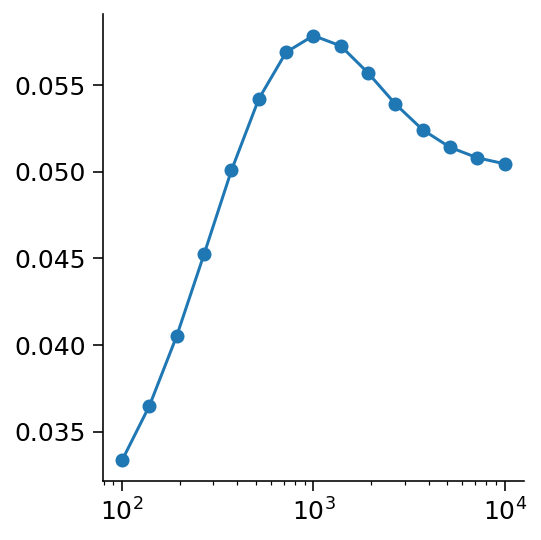

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 5179
Max Corr: 0


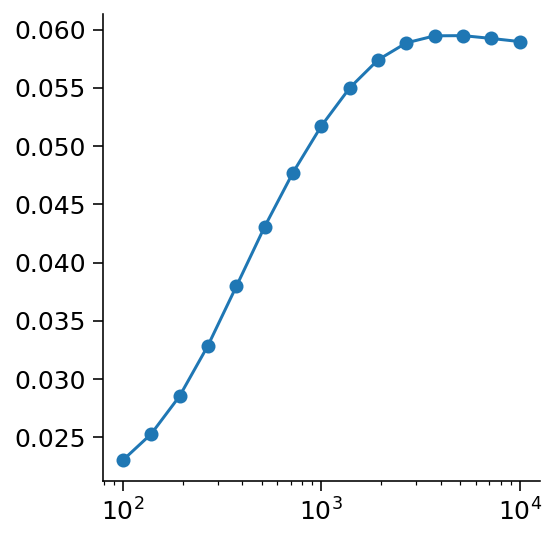

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


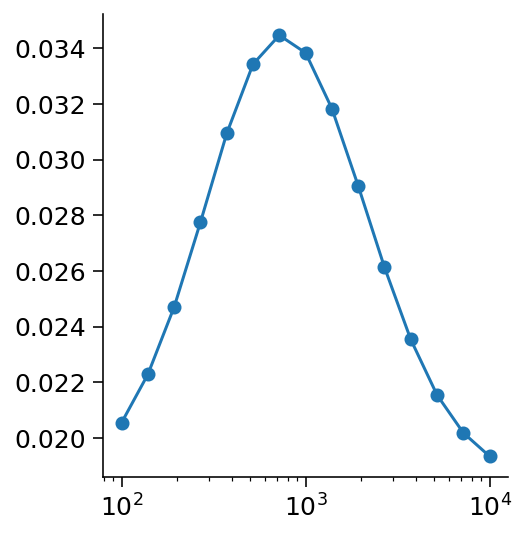

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


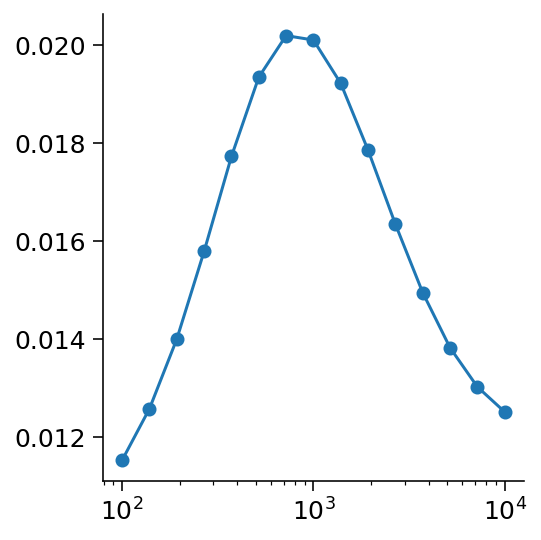

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


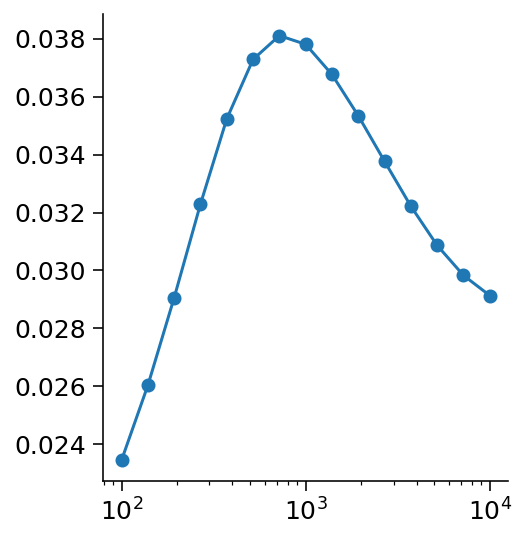

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


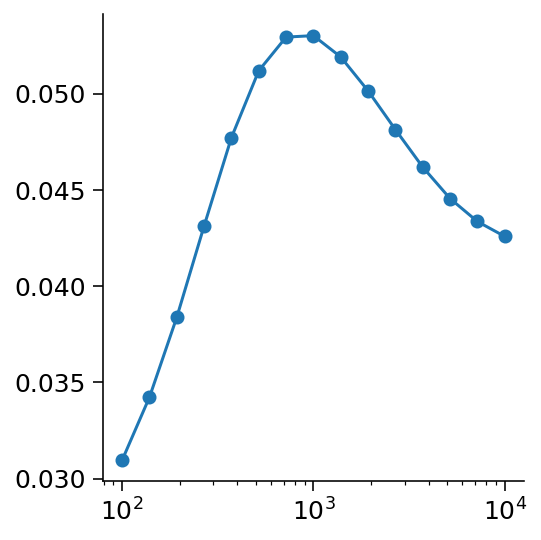

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 719
Max Corr: 0


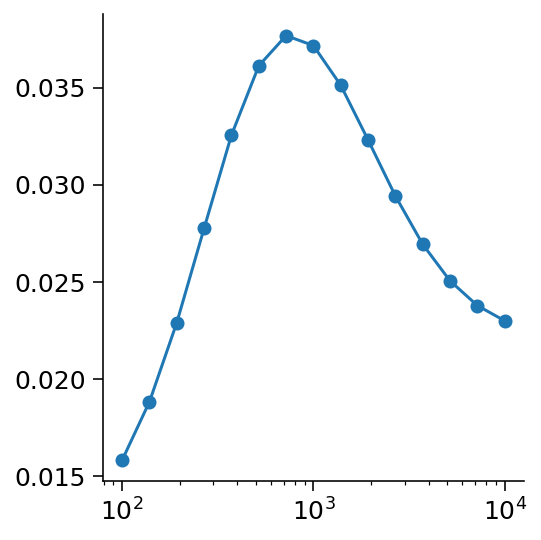

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


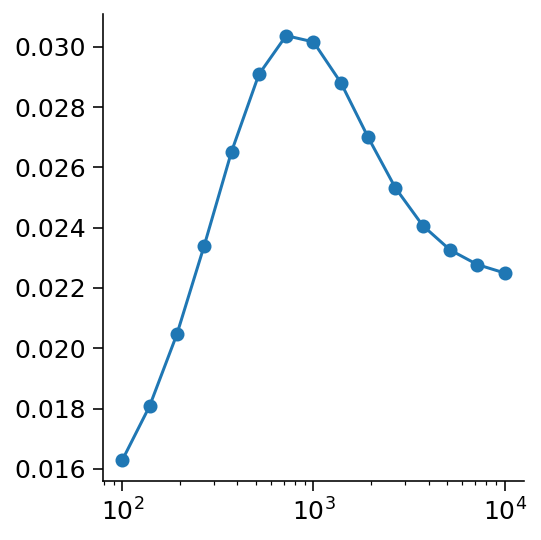

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


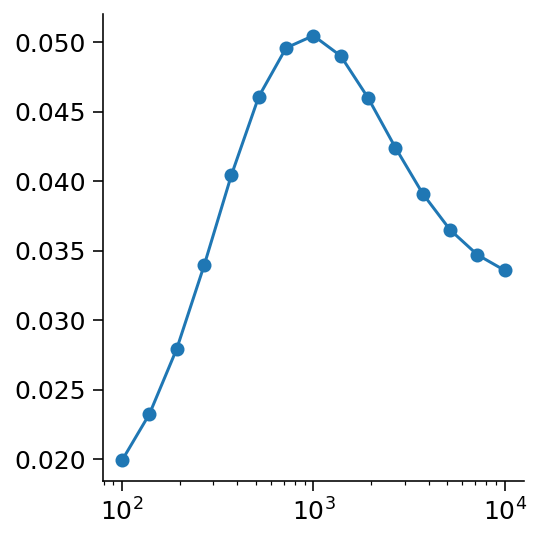

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1389
Max Corr: 0


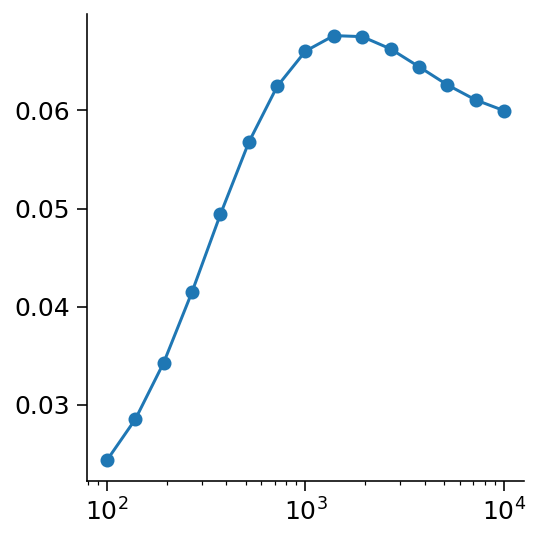

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


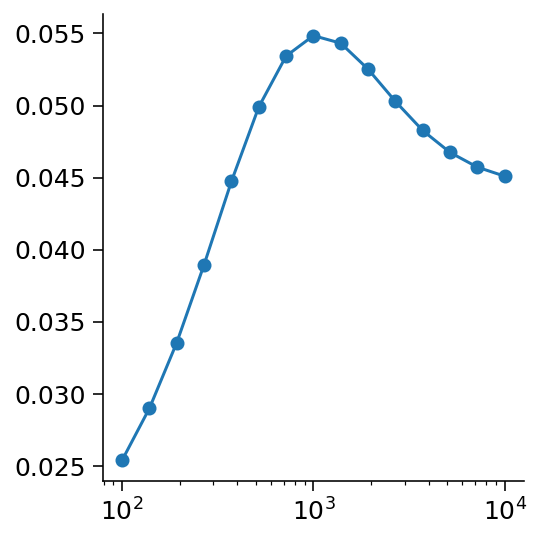

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 3727
Max Corr: 0


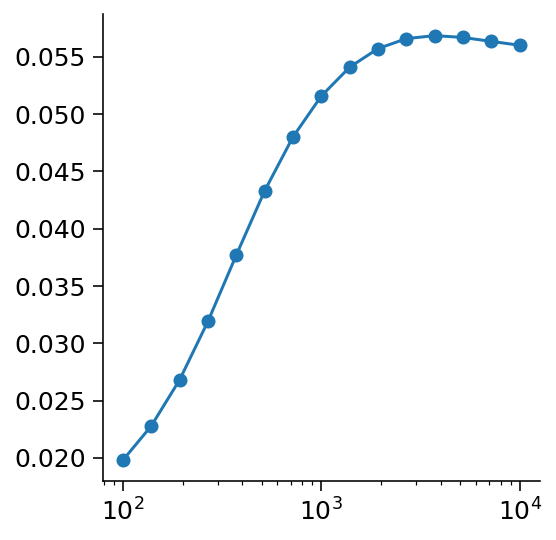

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


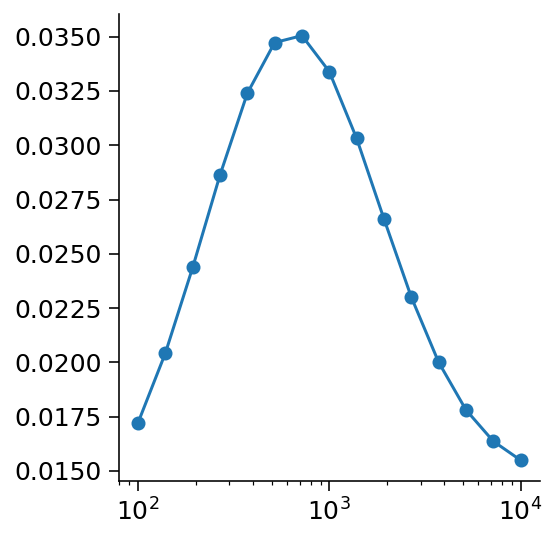

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


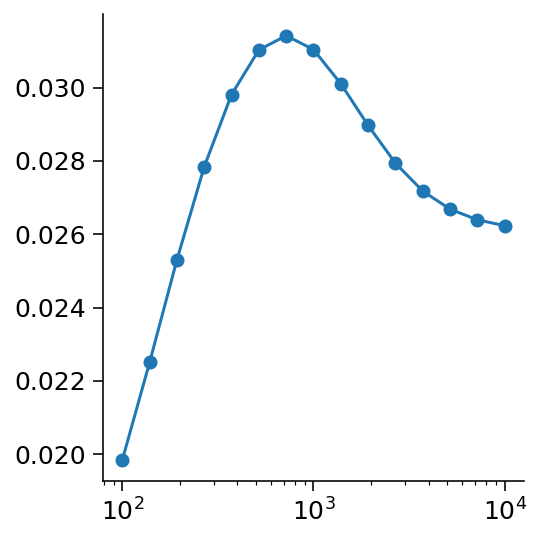

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 517
Max Corr: 0


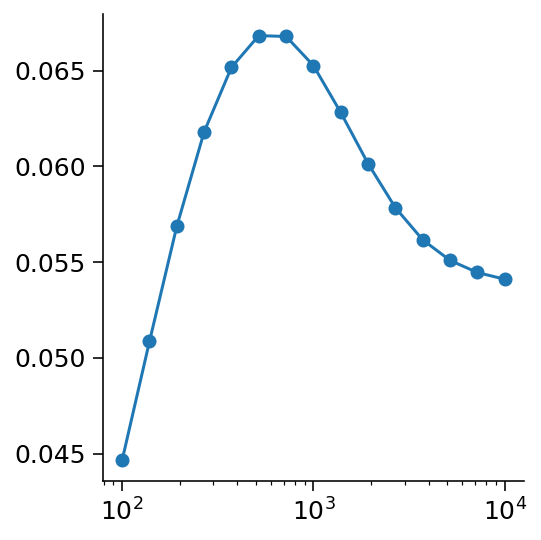

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


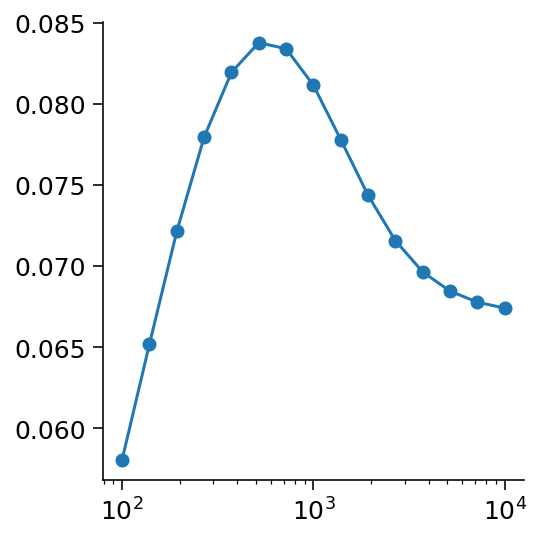

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


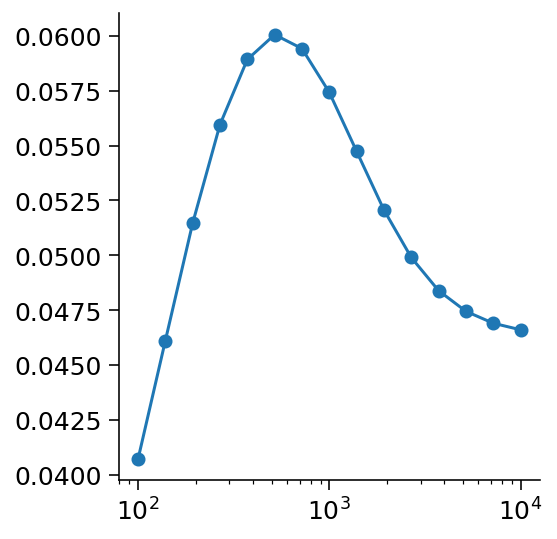

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


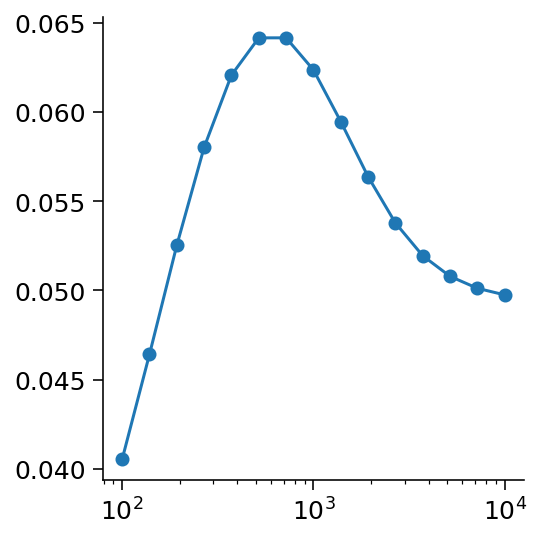

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


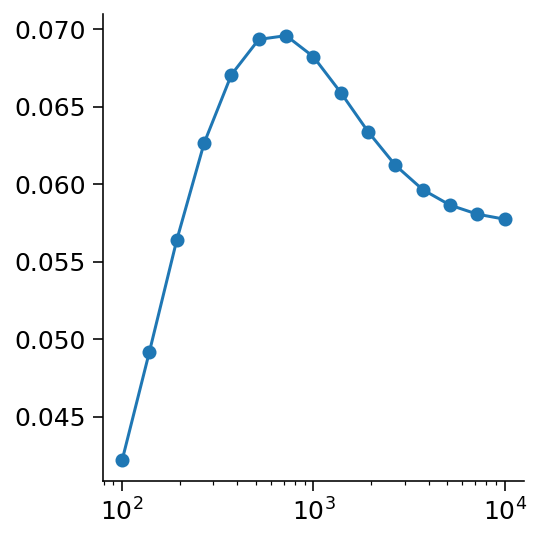

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1000
Max Corr: 0


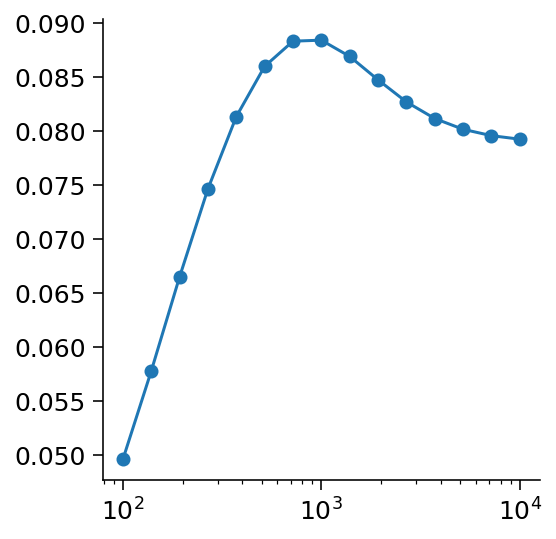

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 517
Max Corr: 0


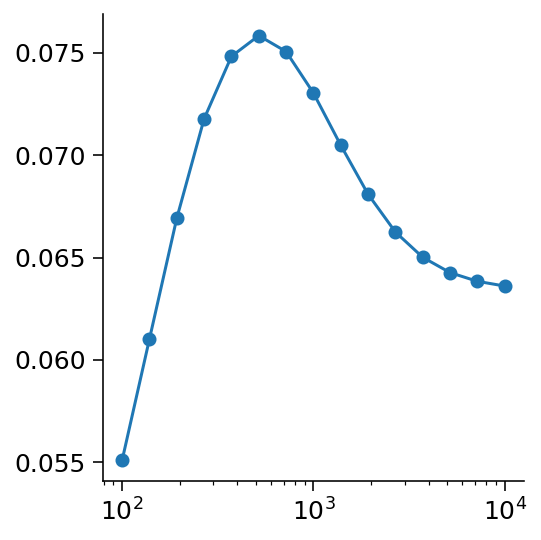

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 1389
Max Corr: 0


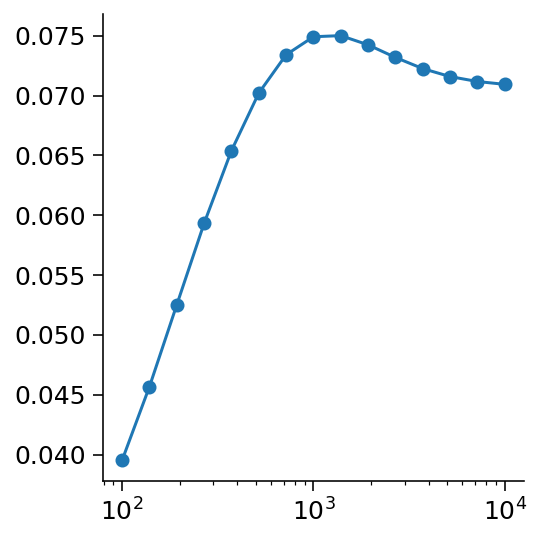

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


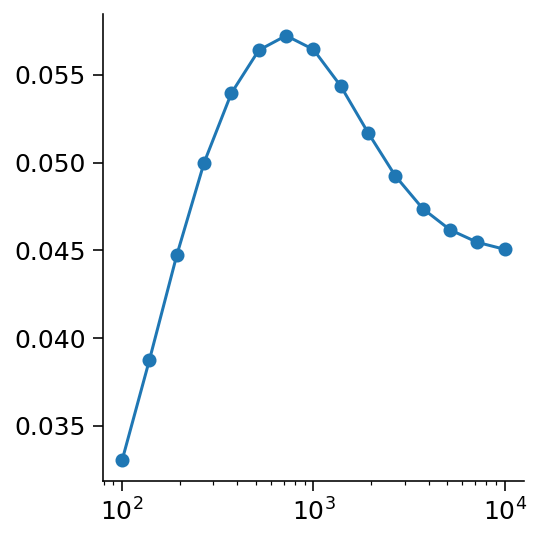

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


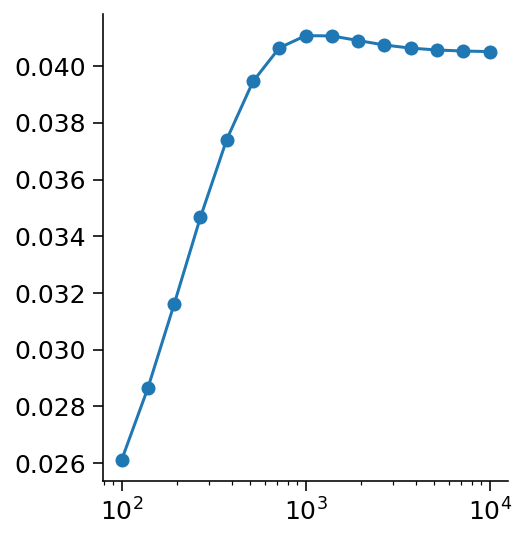

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


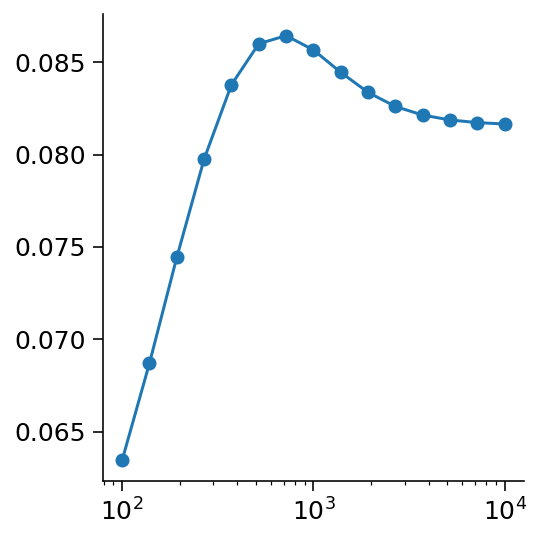

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


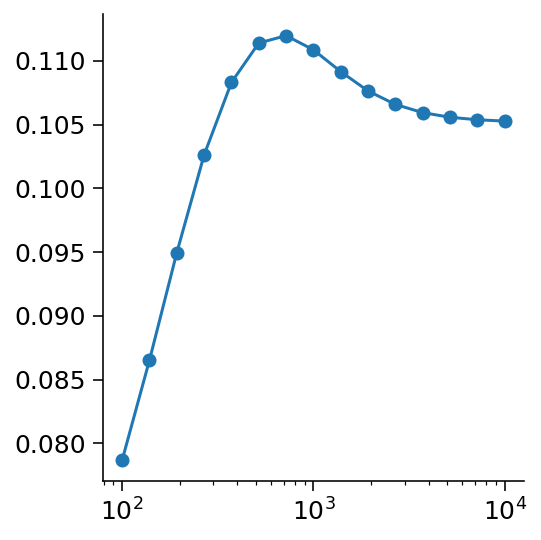

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


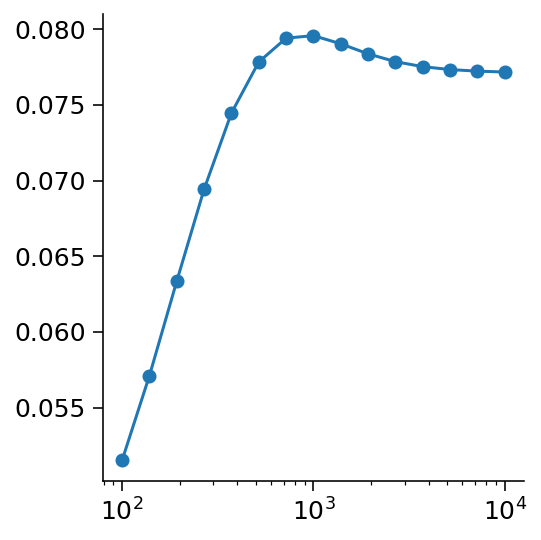

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1000
Max Corr: 0


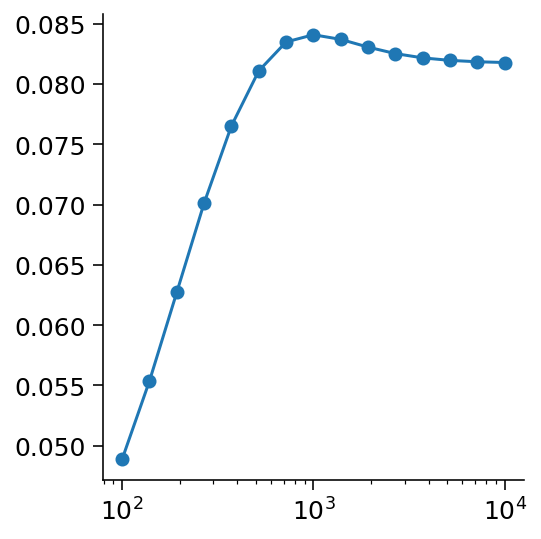

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1389
Max Corr: 0


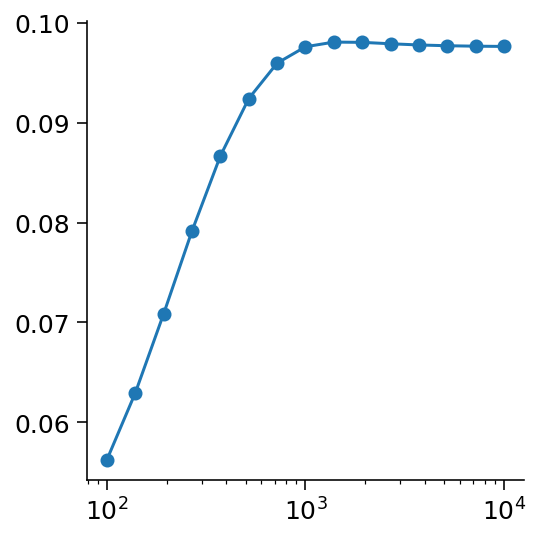

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1930
Max Corr: 0


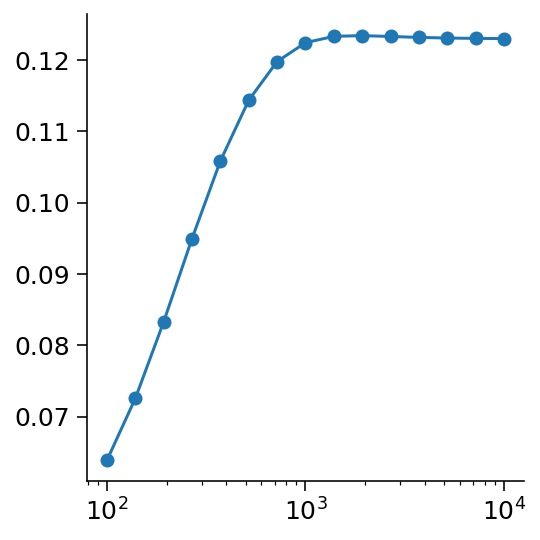

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1389
Max Corr: 0


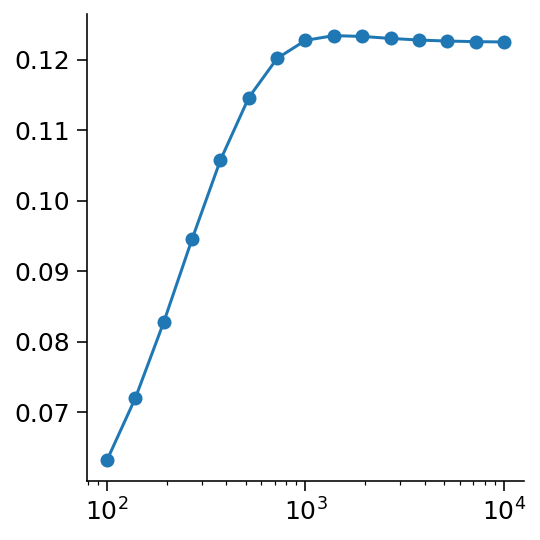

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 5179
Max Corr: 0


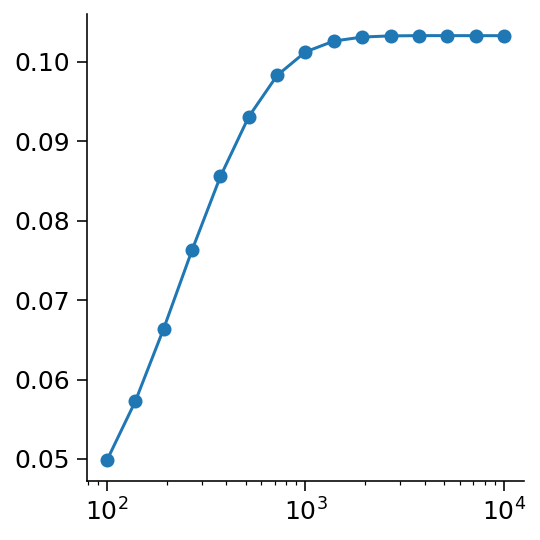

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1930
Max Corr: 0


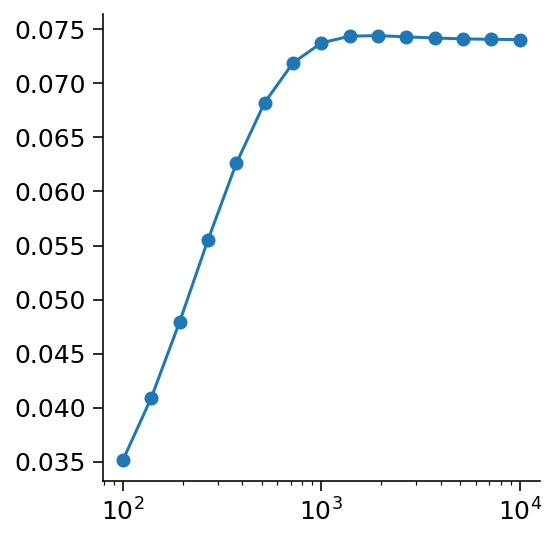

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 2682
Max Corr: 0


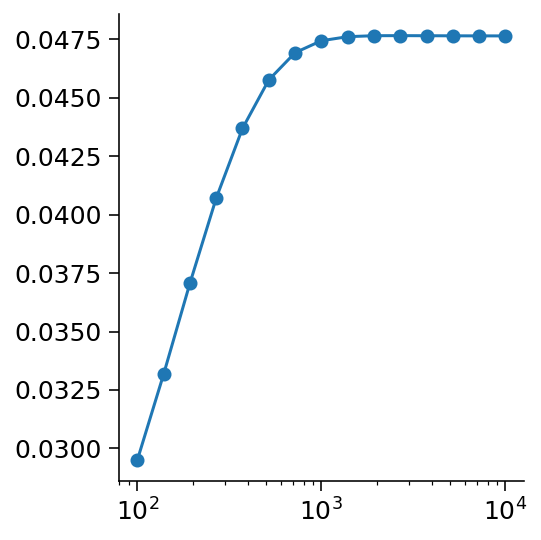

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1389
Max Corr: 0


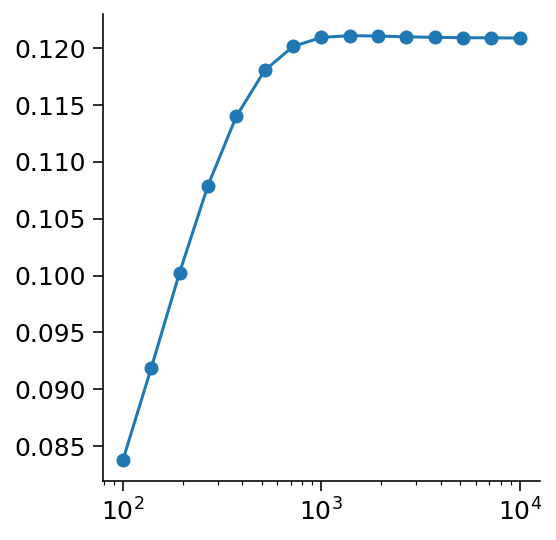

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


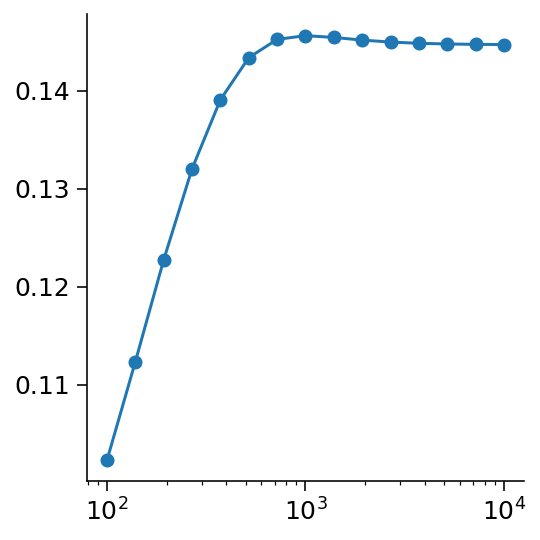

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1930
Max Corr: 0


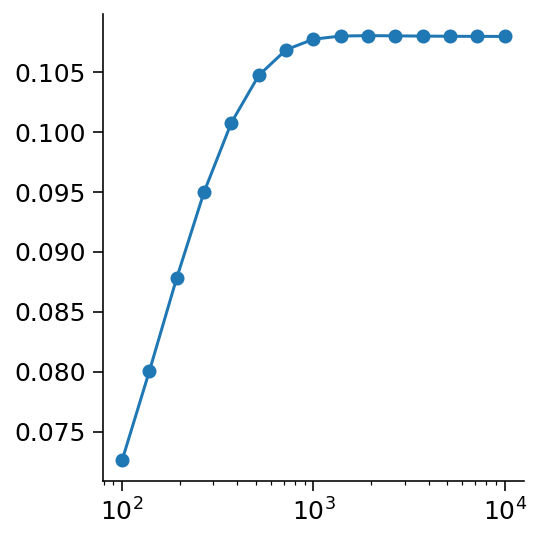

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 1930
Max Corr: 0


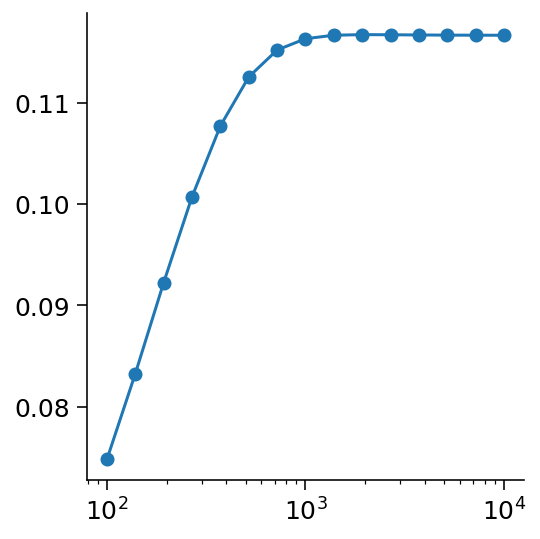

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 2682
Max Corr: 0


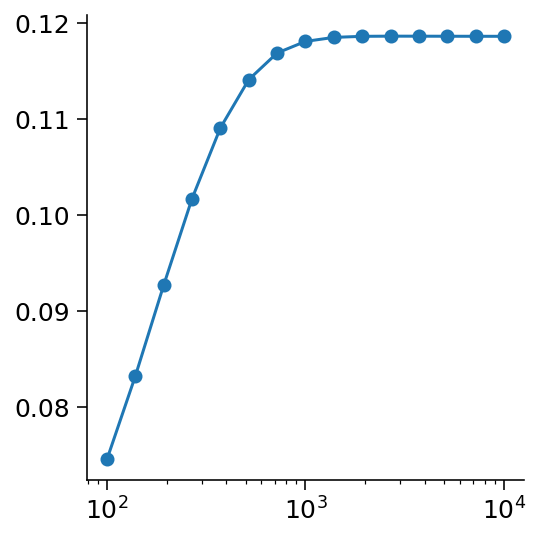

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1389
Max Corr: 0


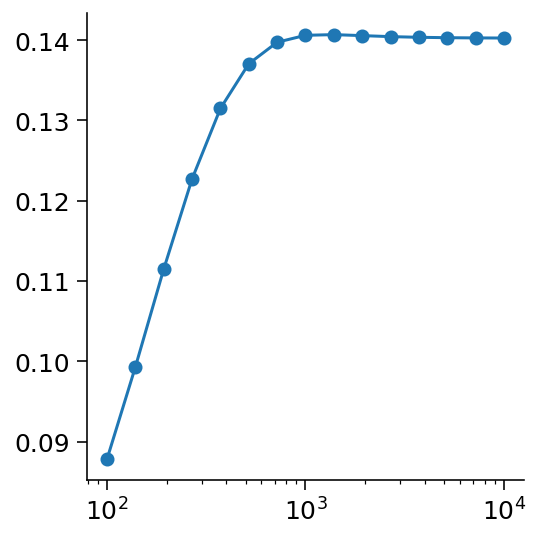

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


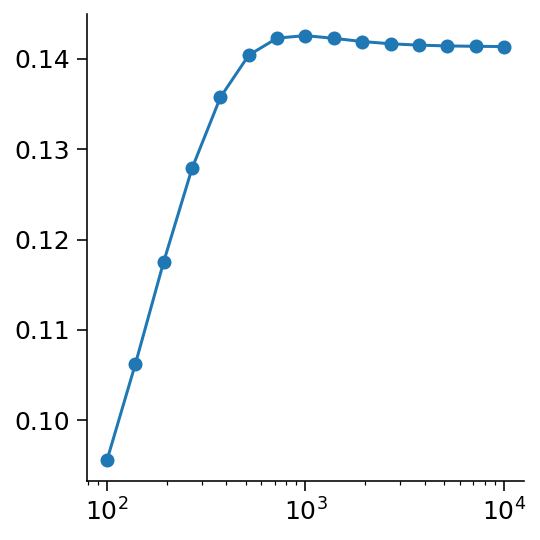

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 1930
Max Corr: 0


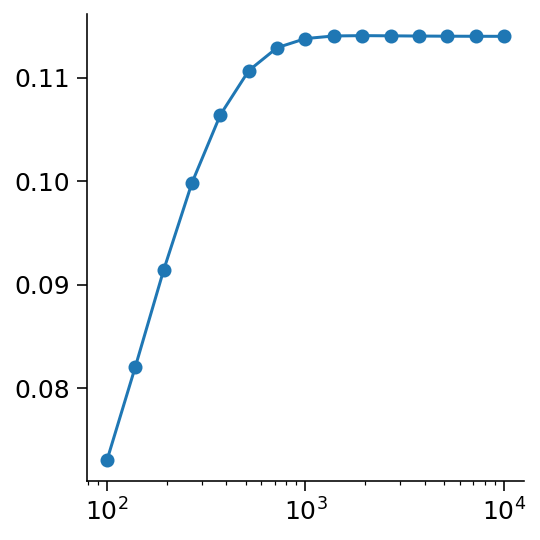

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1000
Max Corr: 0


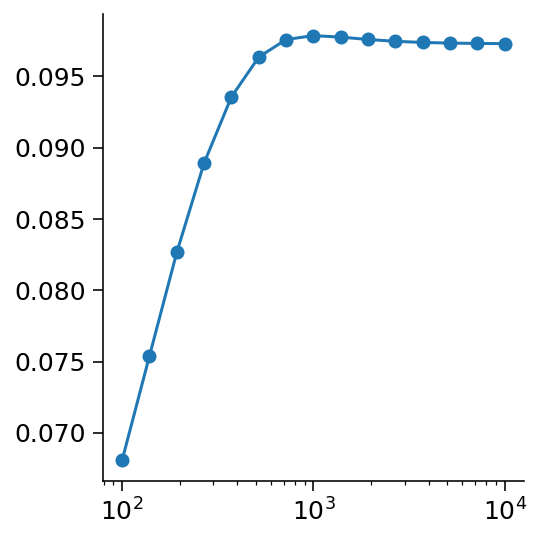

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


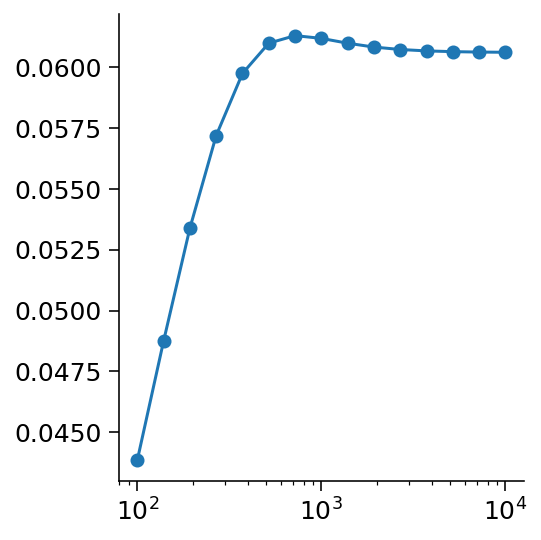

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


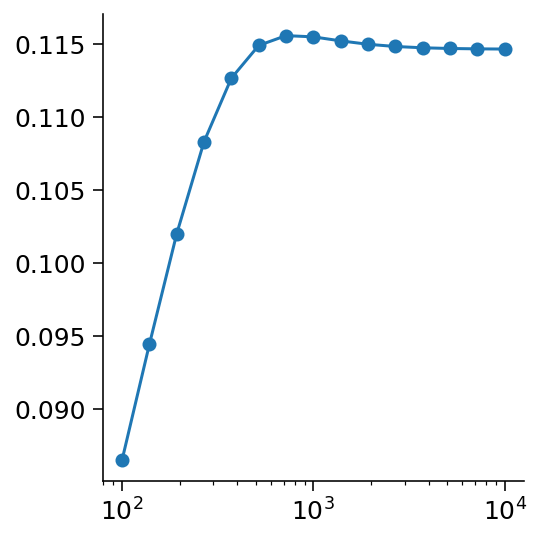

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


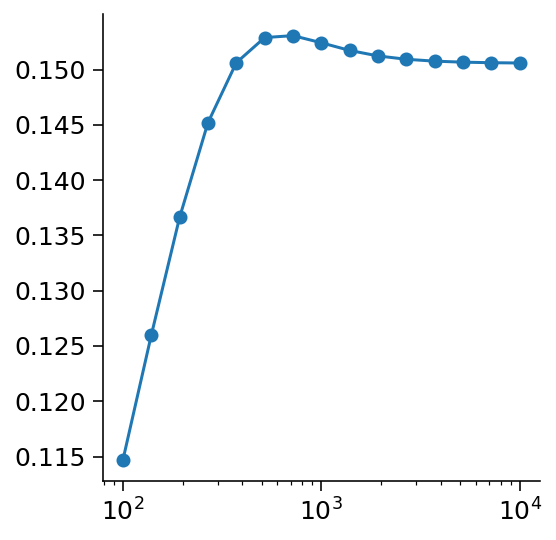

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1000
Max Corr: 0


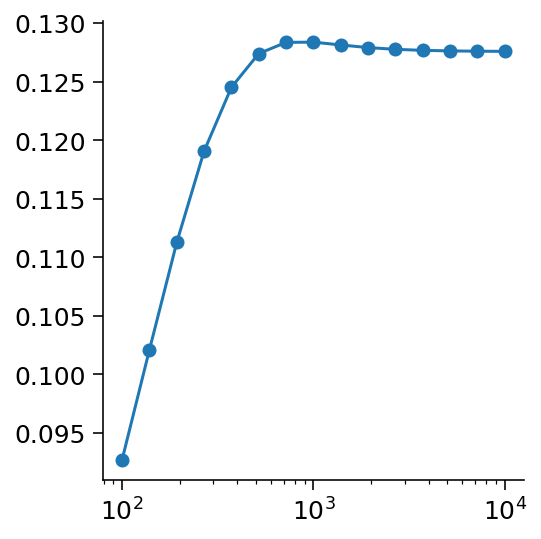

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


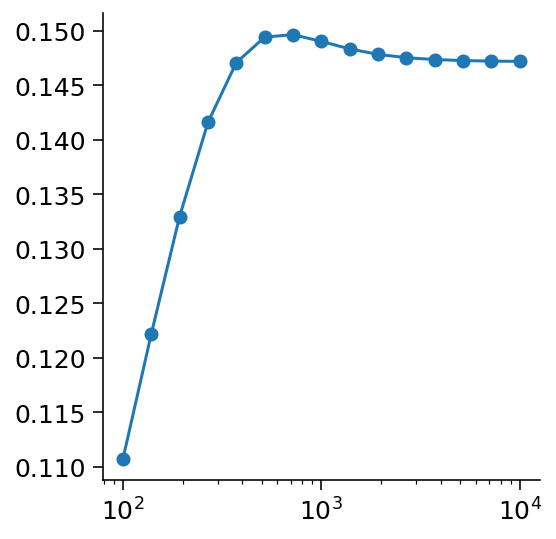

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


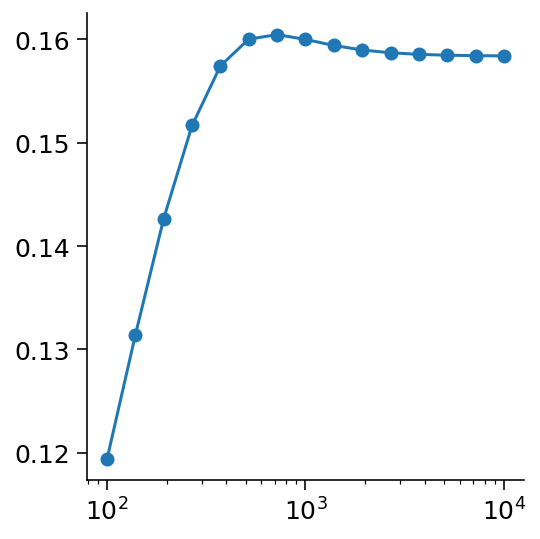

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 517
Max Corr: 0


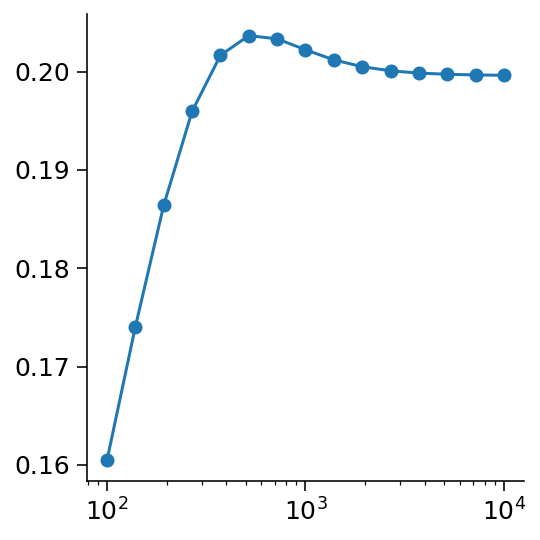

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 517
Max Corr: 0


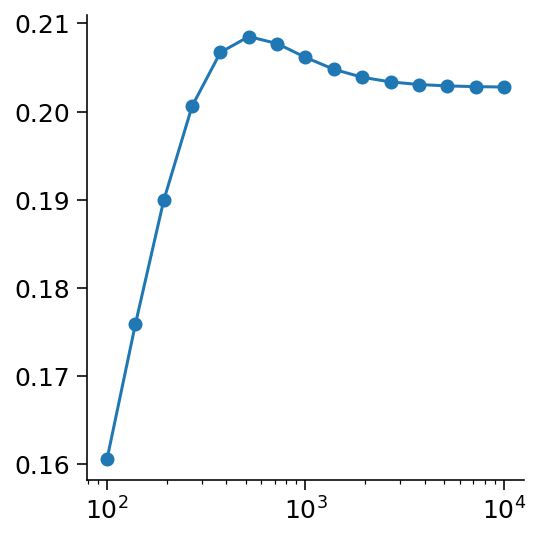

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 719
Max Corr: 0


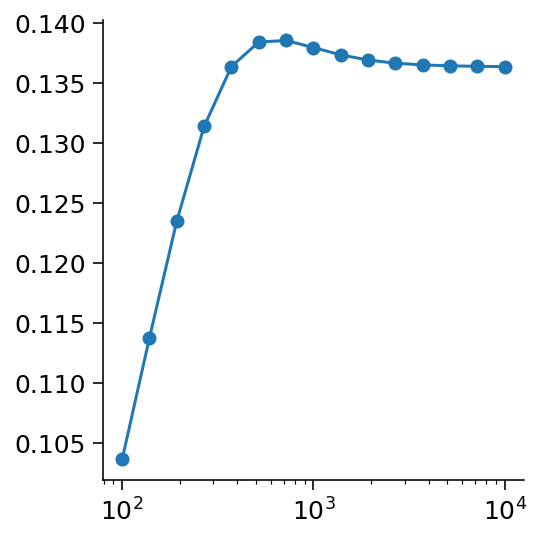

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


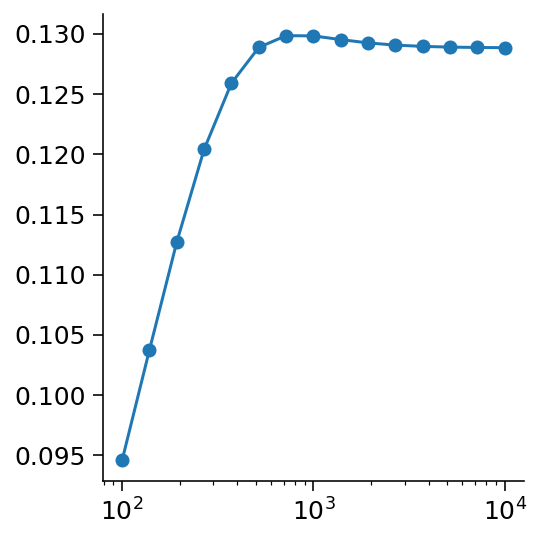

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1389
Max Corr: 0


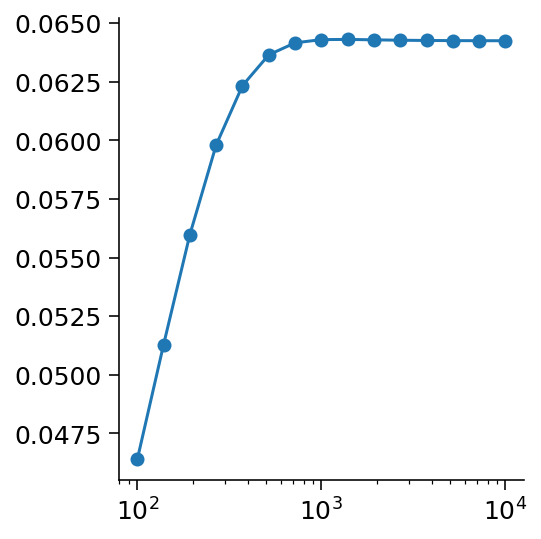

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


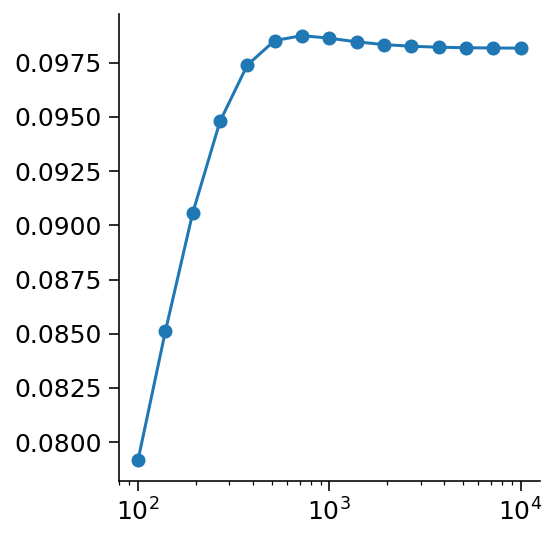

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


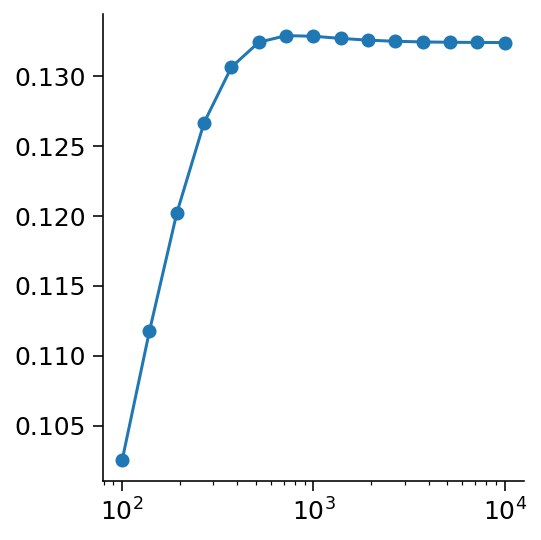

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1389
Max Corr: 0


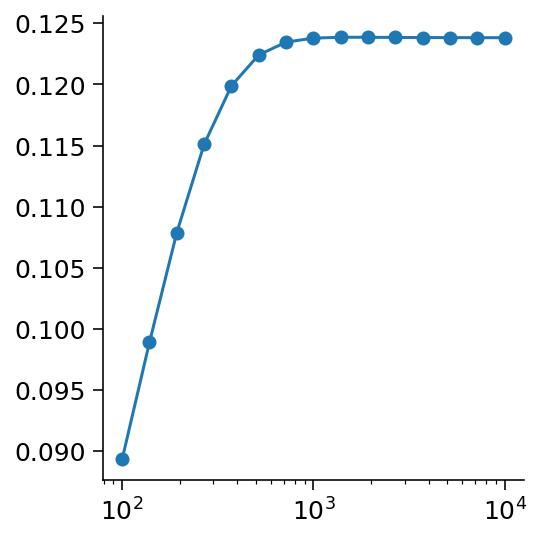

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


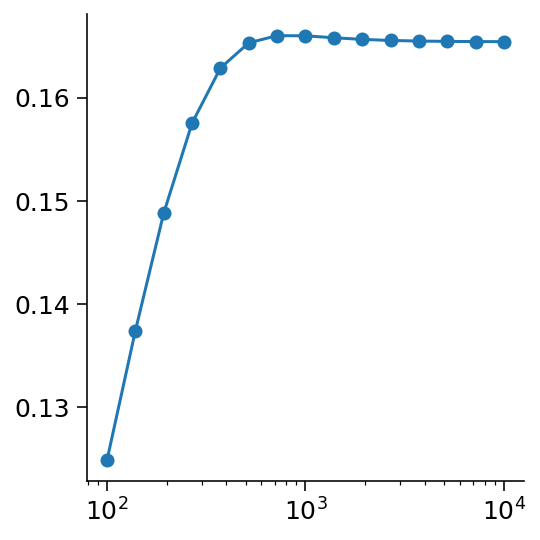

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


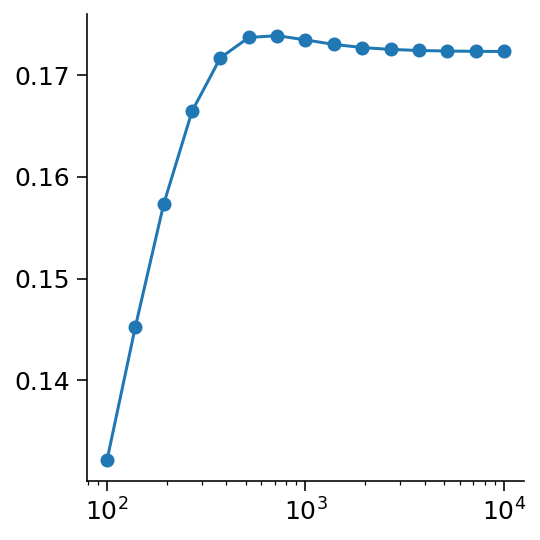

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 517
Max Corr: 0


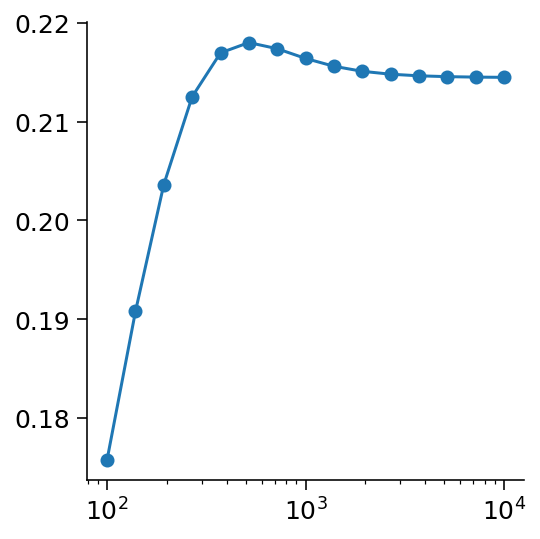

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 517
Max Corr: 0


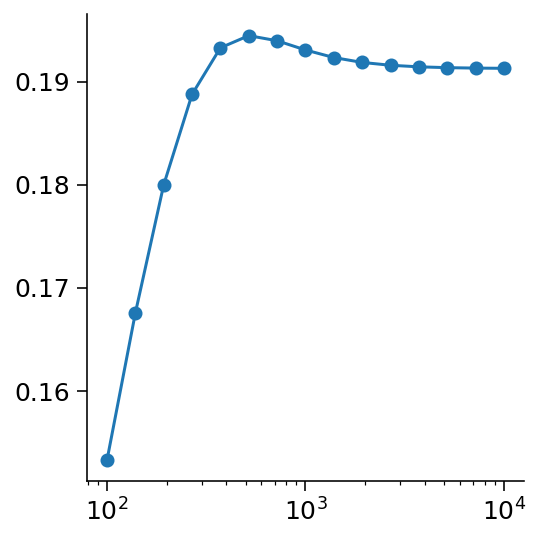

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 719
Max Corr: 0


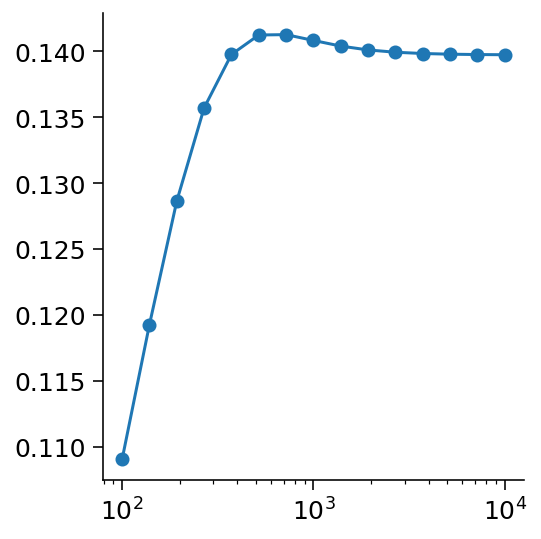

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


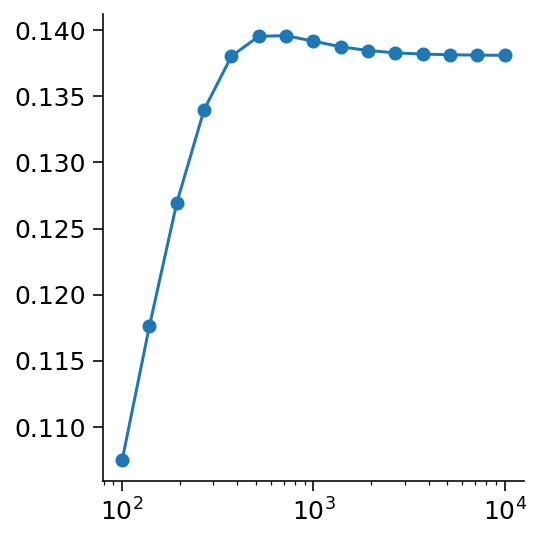

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 193
Max Corr: 0


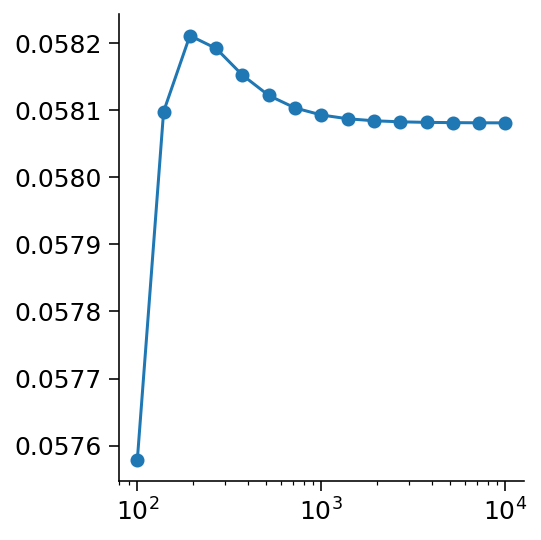

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 100
Max Corr: 0


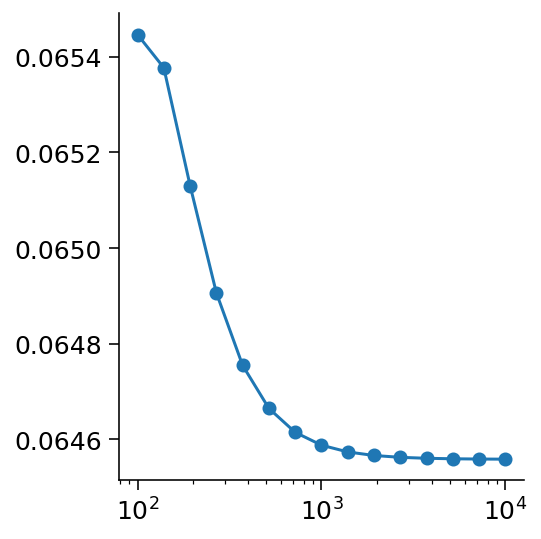

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 100
Max Corr: 0


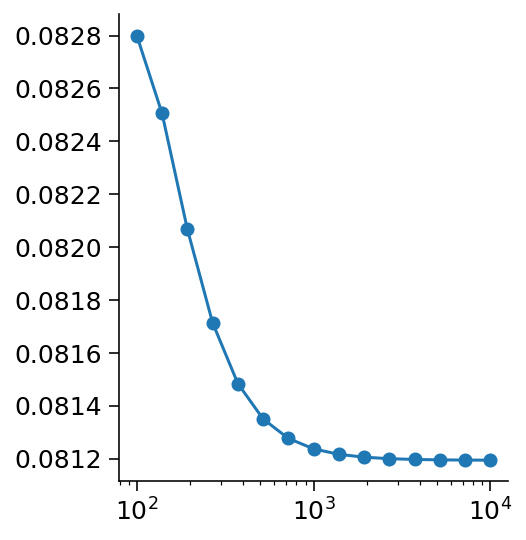

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 193
Max Corr: 0


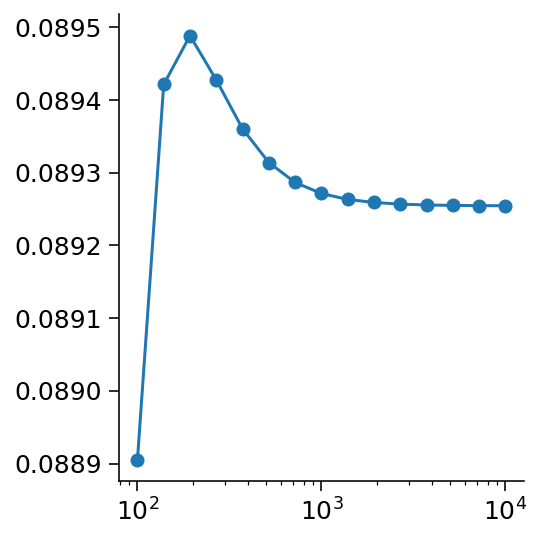

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 138
Max Corr: 0


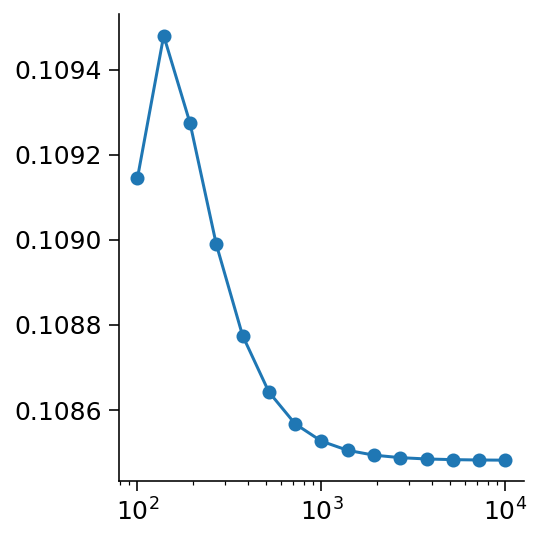

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 138
Max Corr: 0


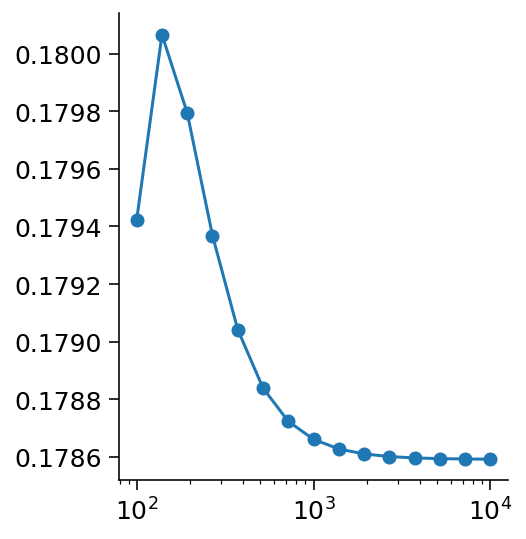

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 138
Max Corr: 0


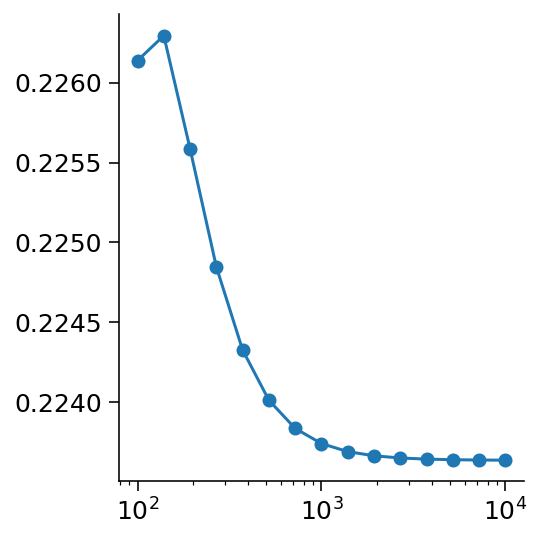

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 138
Max Corr: 0


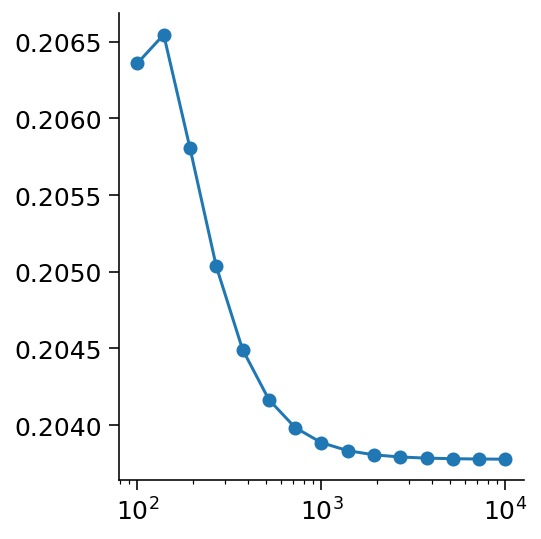

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 138
Max Corr: 0


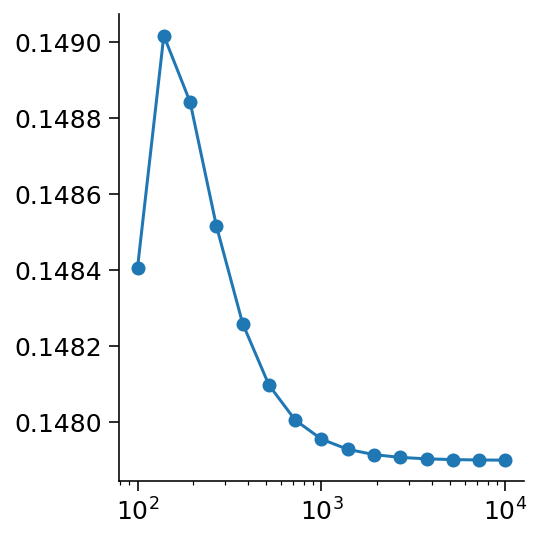

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 138
Max Corr: 0


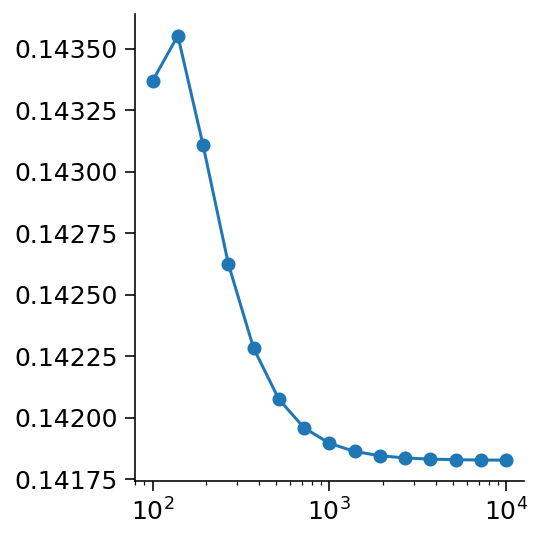

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_9
----------------------------------------------------------------------------


In [ ]:
#@title sub03
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub03"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub04
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub04"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub05
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub05"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting sub:  sub06
Starting ROI:  WB  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


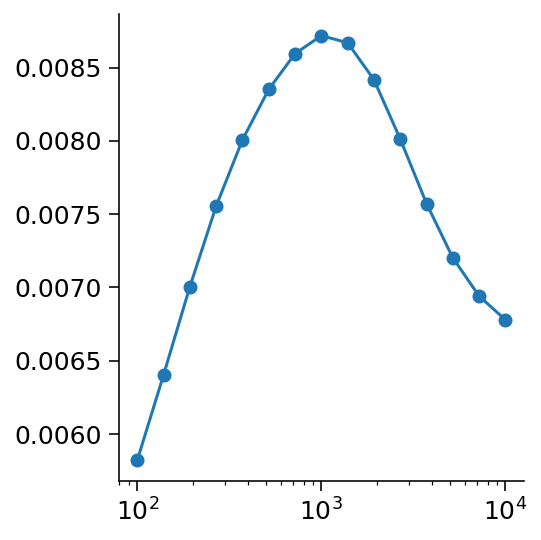

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 5179
Max Corr: 0


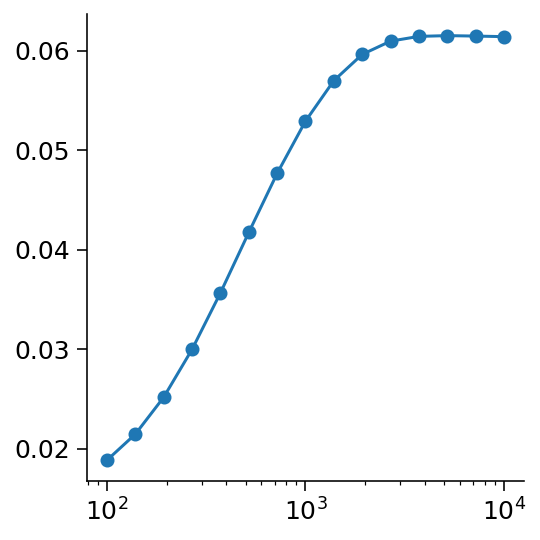

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 2682
Max Corr: 0


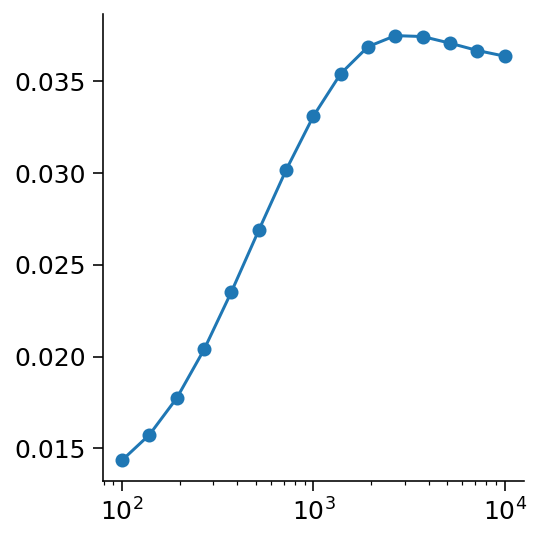

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 1389
Max Corr: 0


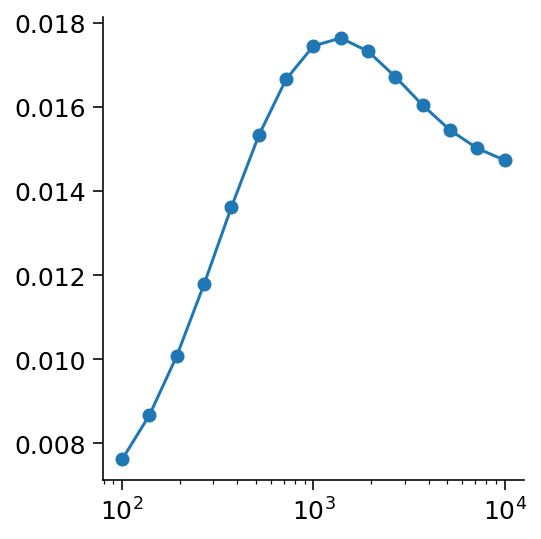

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 10000
Max Corr: 0


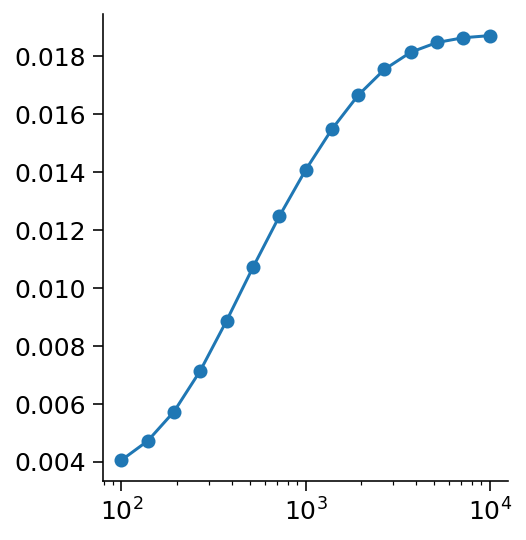

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1930
Max Corr: 0


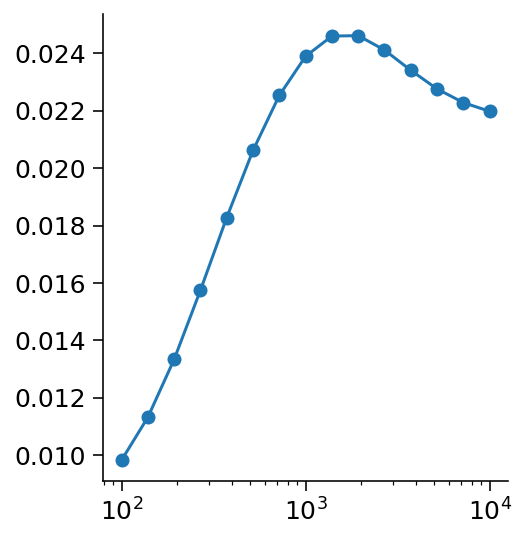

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


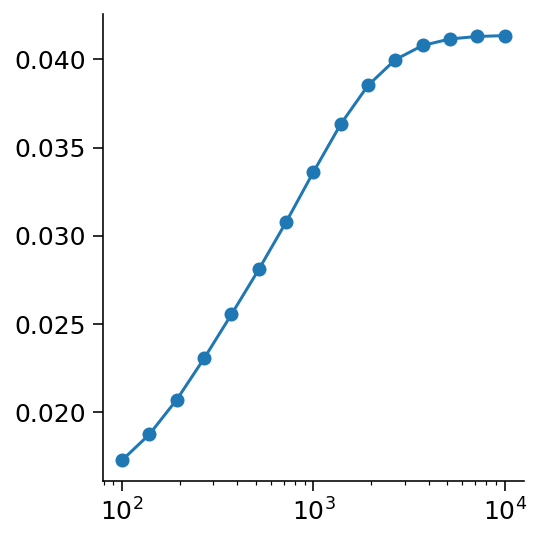

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


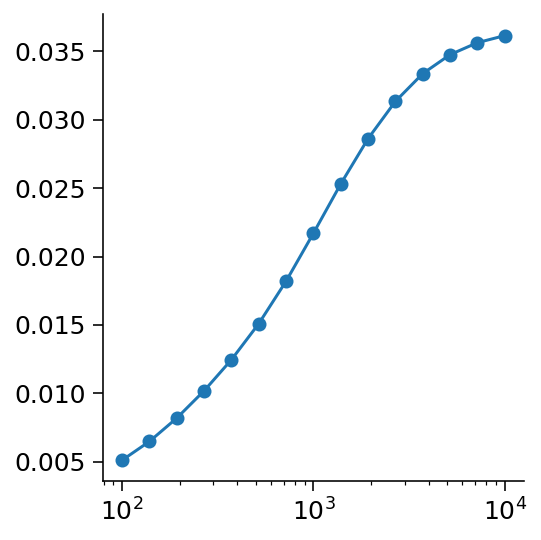

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


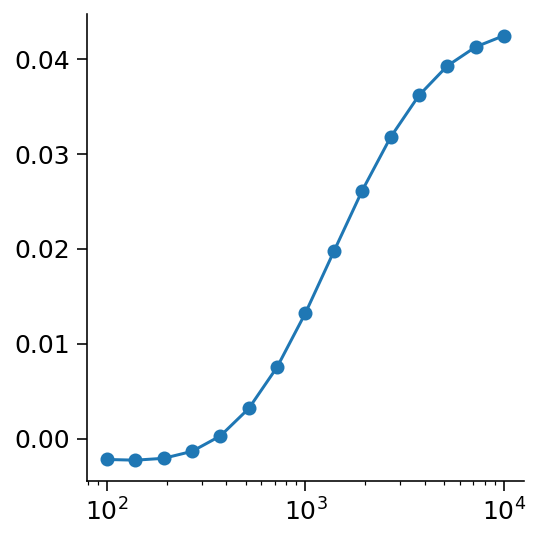

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1930
Max Corr: 0


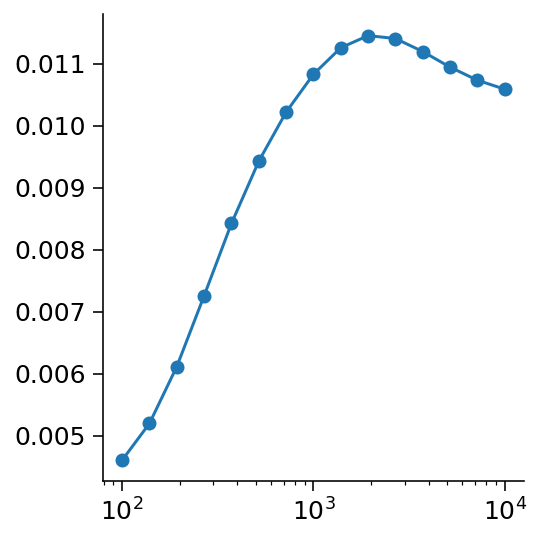

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_1
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 372
Max Corr: 0


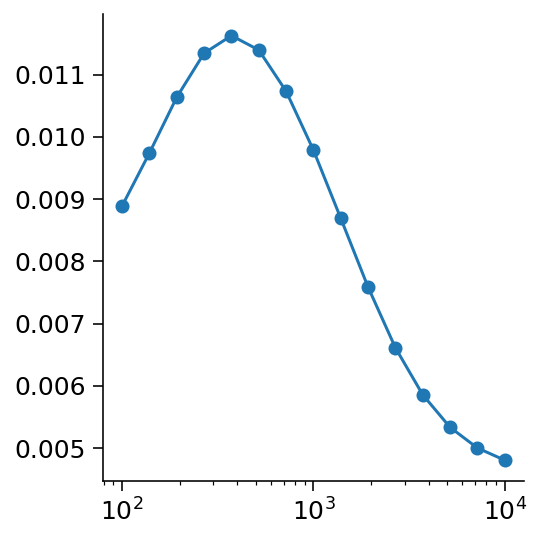

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


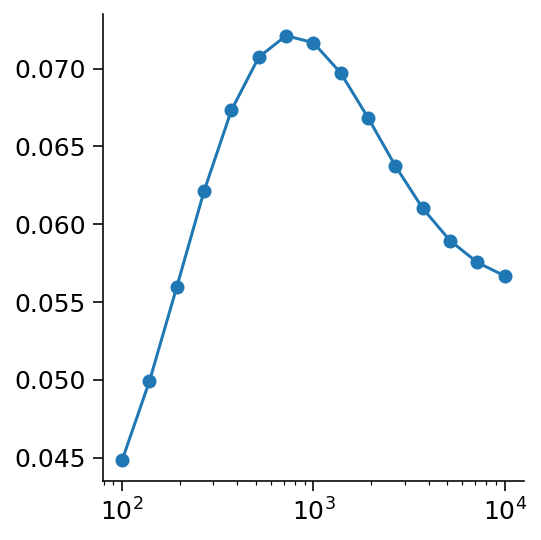

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


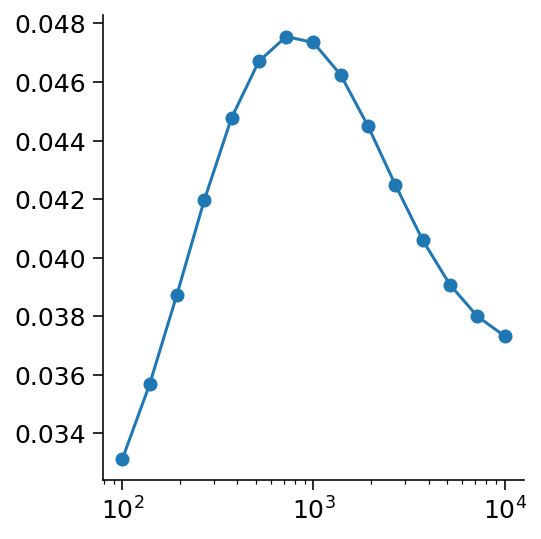

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


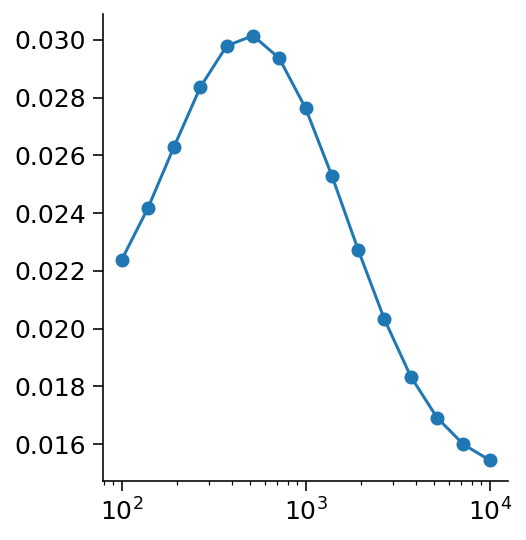

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


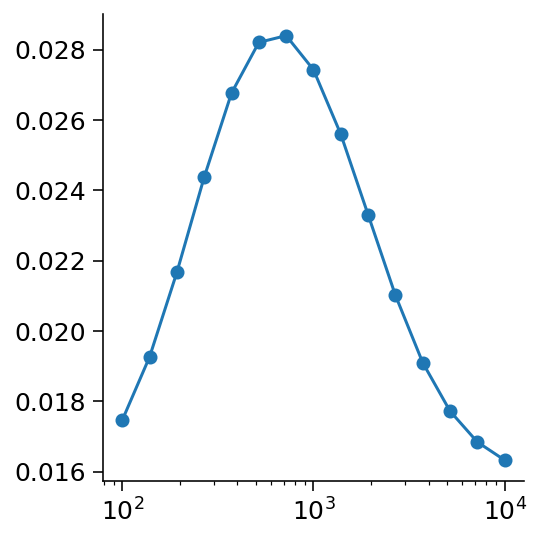

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


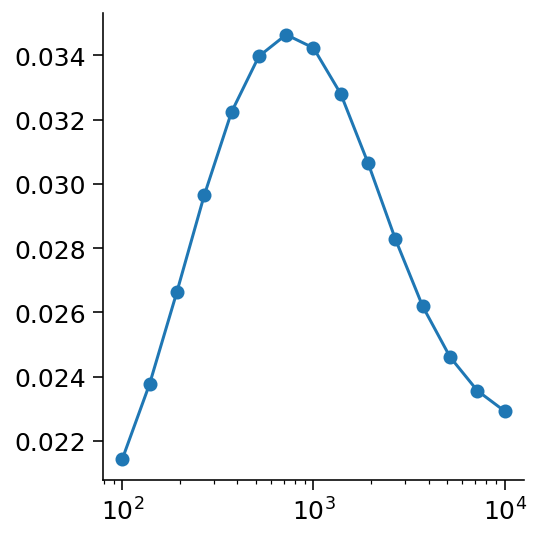

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1389
Max Corr: 0


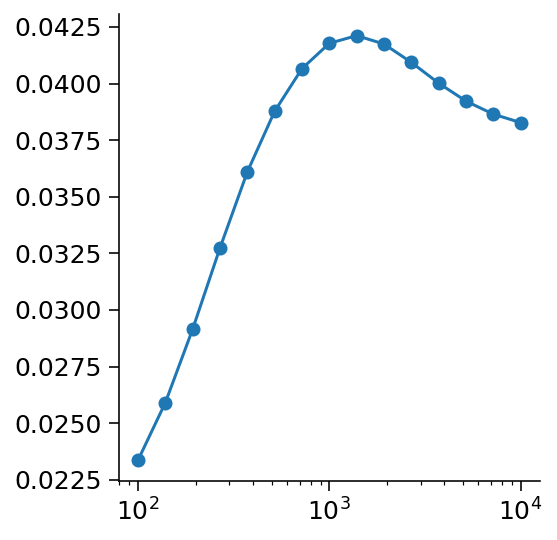

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1930
Max Corr: 0


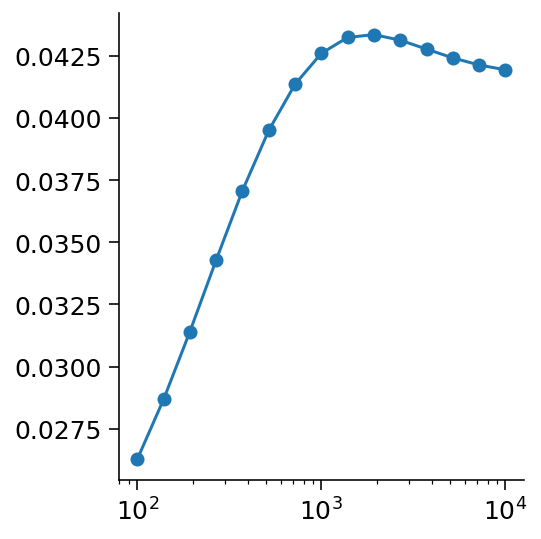

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


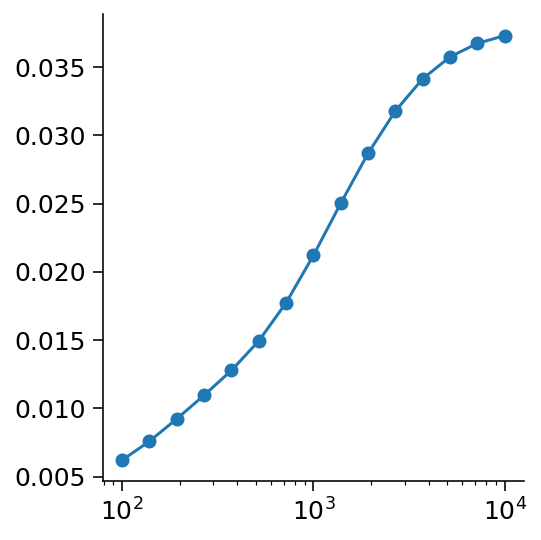

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 517
Max Corr: 0


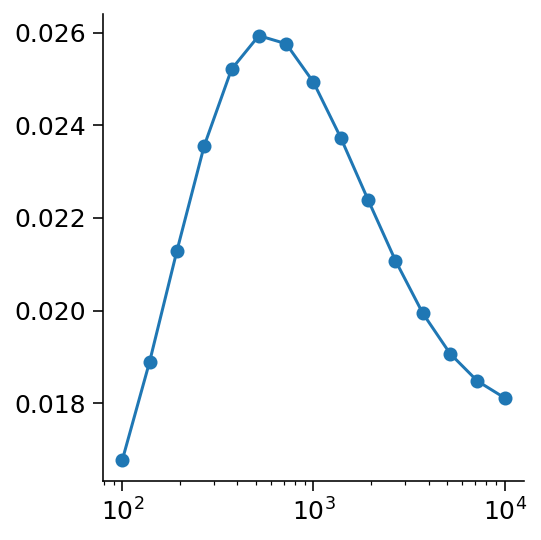

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_2
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 372
Max Corr: 0


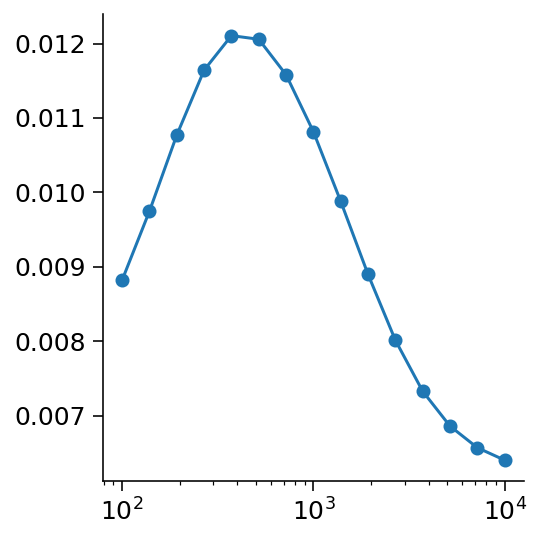

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1000
Max Corr: 0


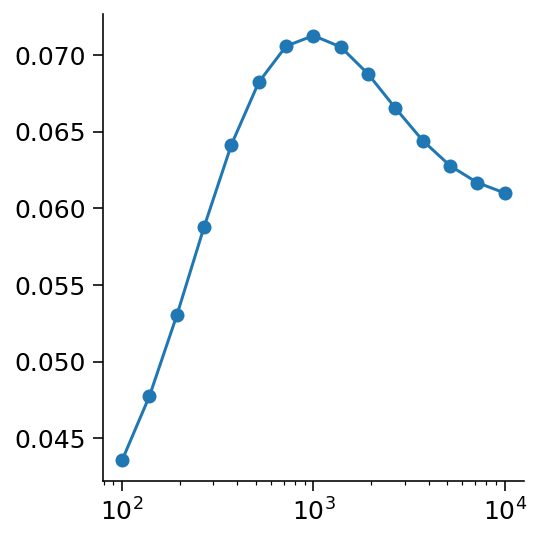

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 1000
Max Corr: 0


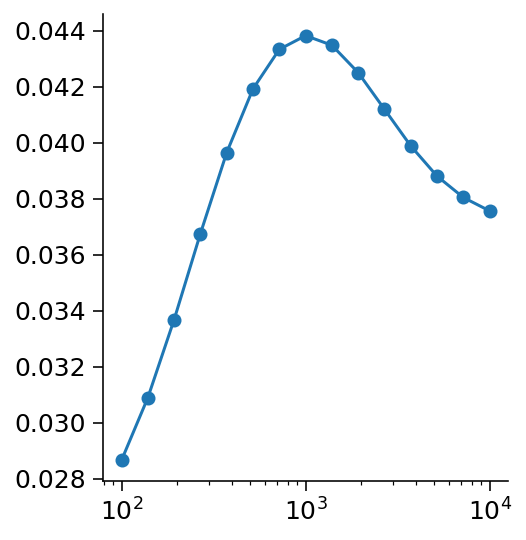

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


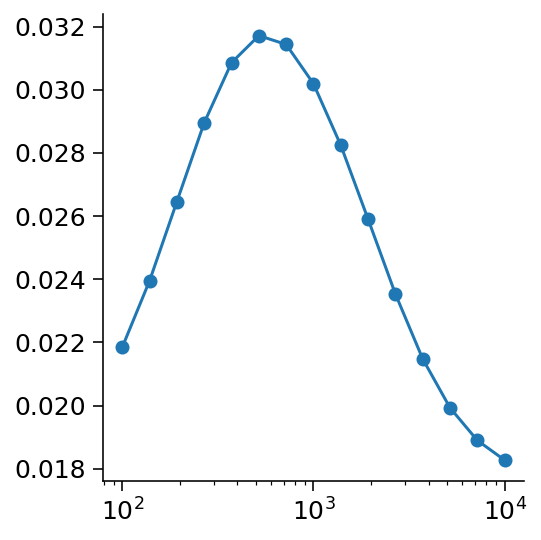

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


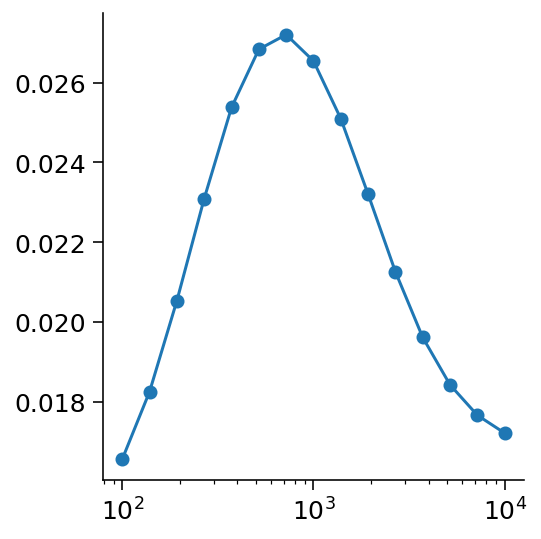

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


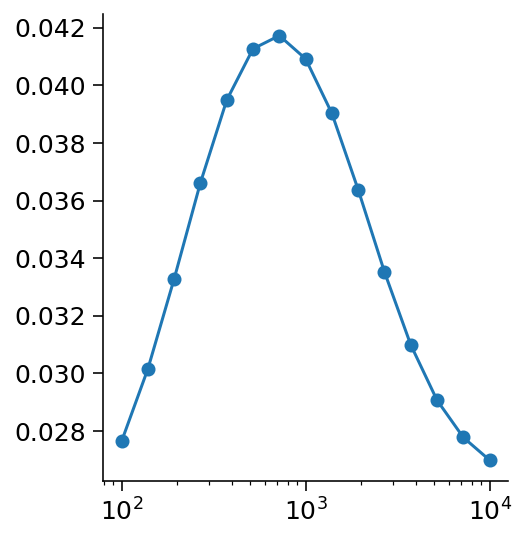

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1930
Max Corr: 0


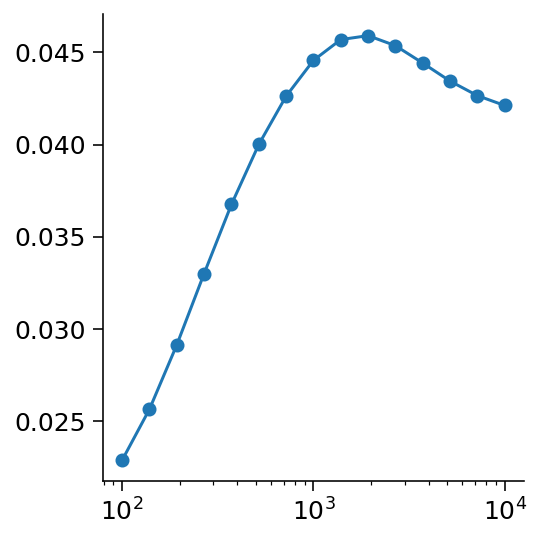

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 2682
Max Corr: 0


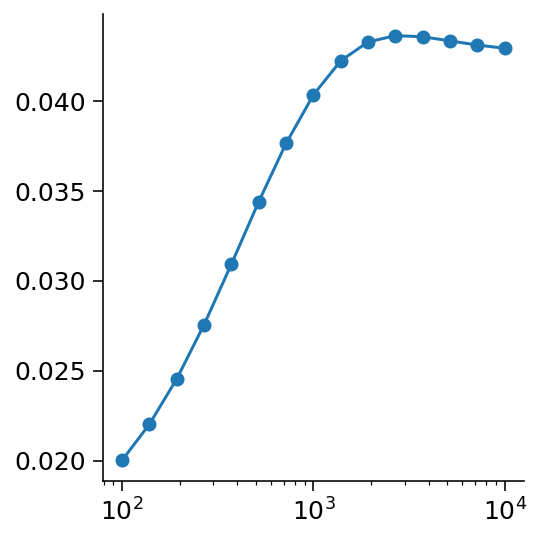

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


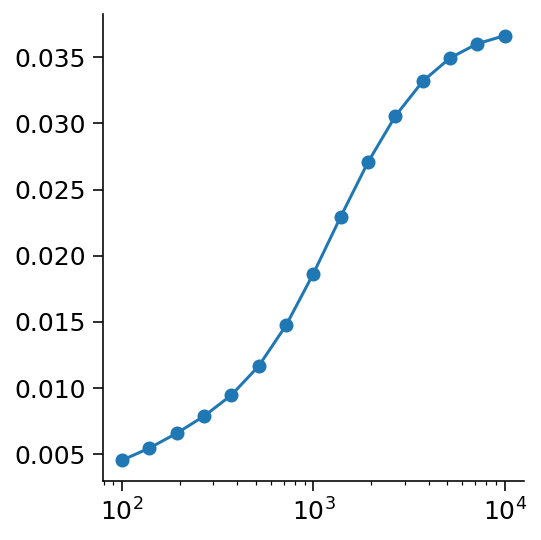

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


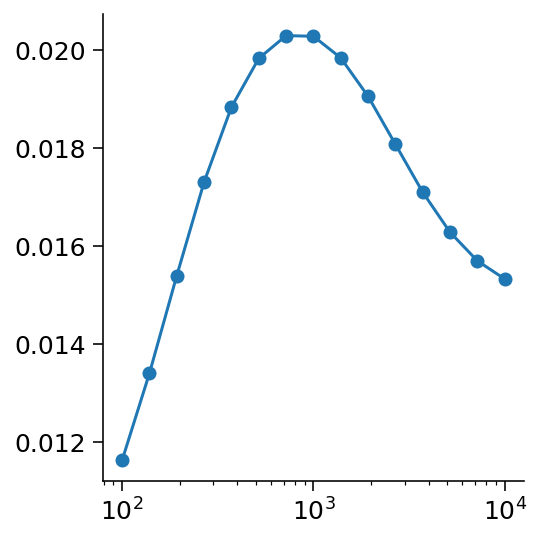

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_3
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


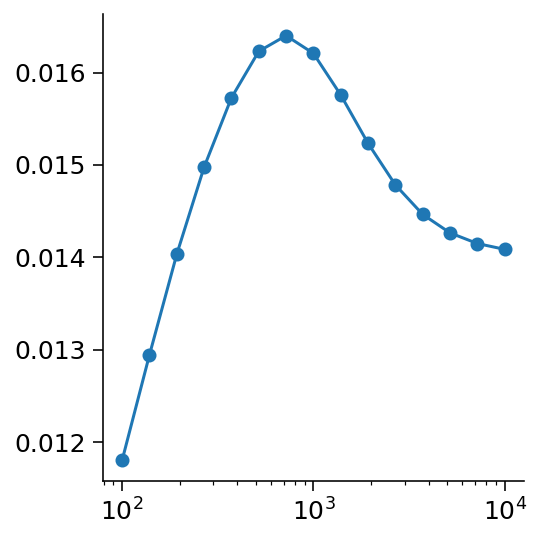

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 719
Max Corr: 0


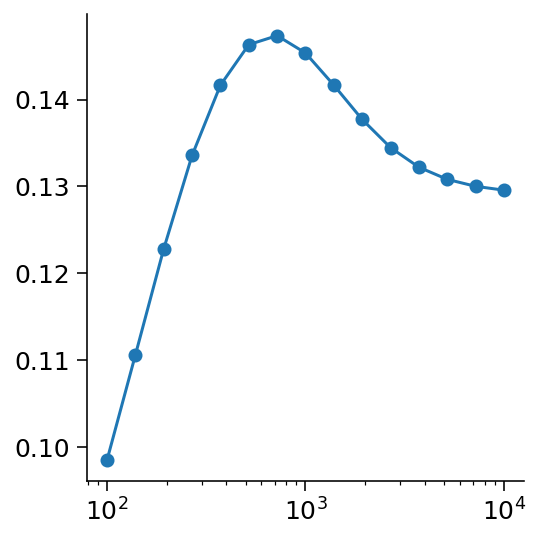

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


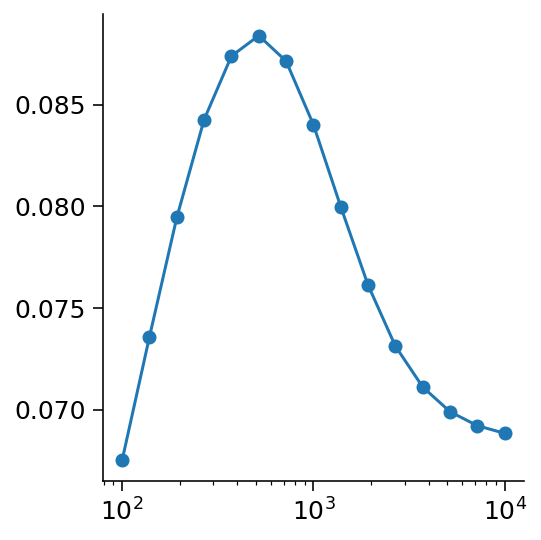

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 372
Max Corr: 0


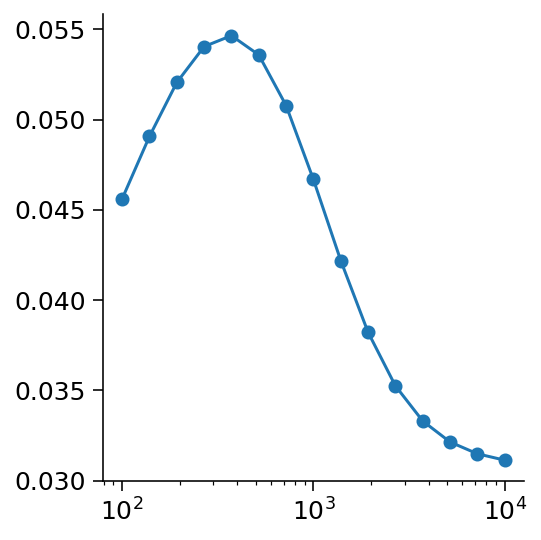

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 372
Max Corr: 0


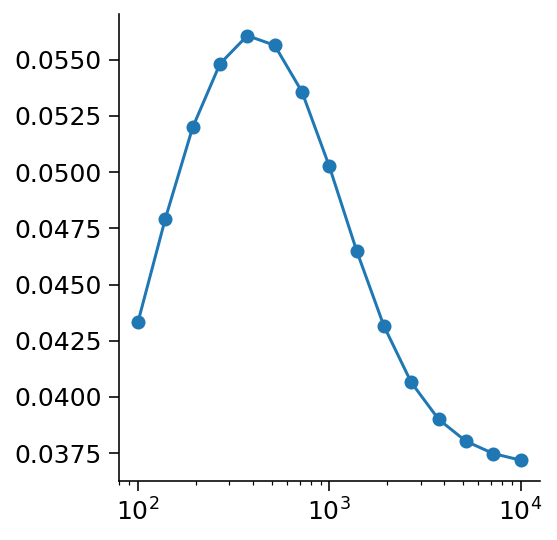

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 719
Max Corr: 0


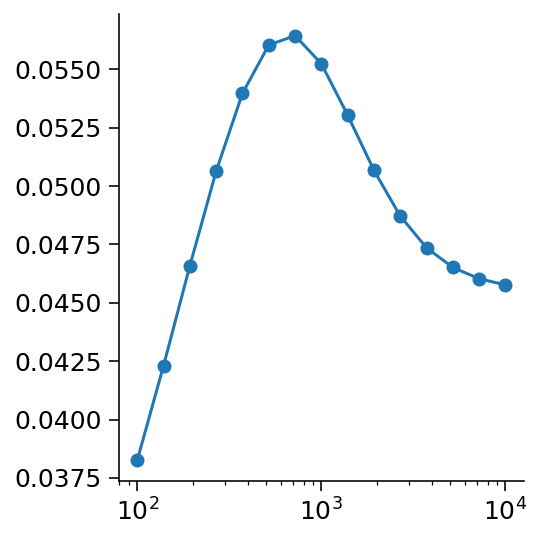

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1000
Max Corr: 0


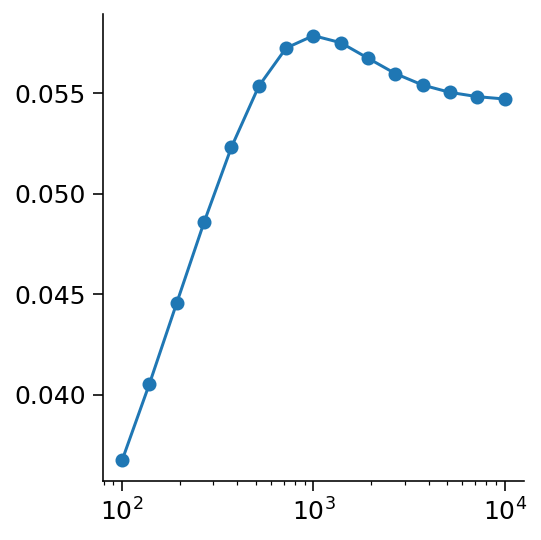

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


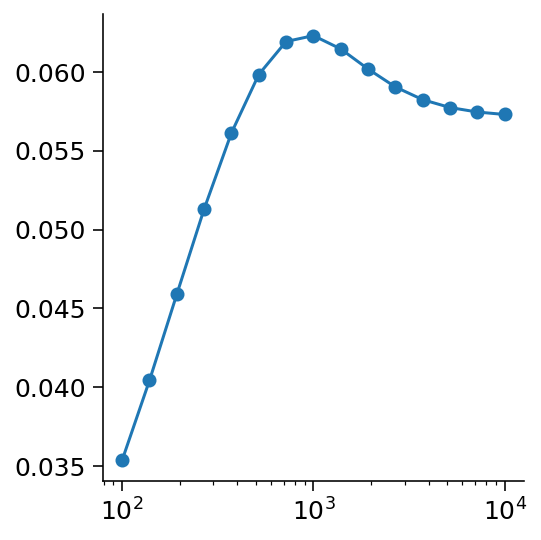

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


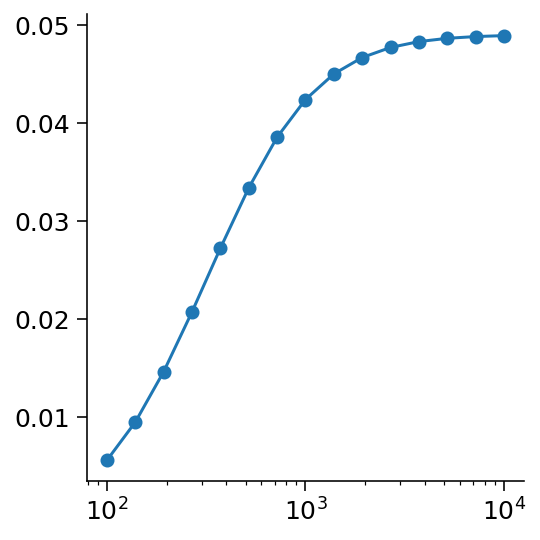

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 1000
Max Corr: 0


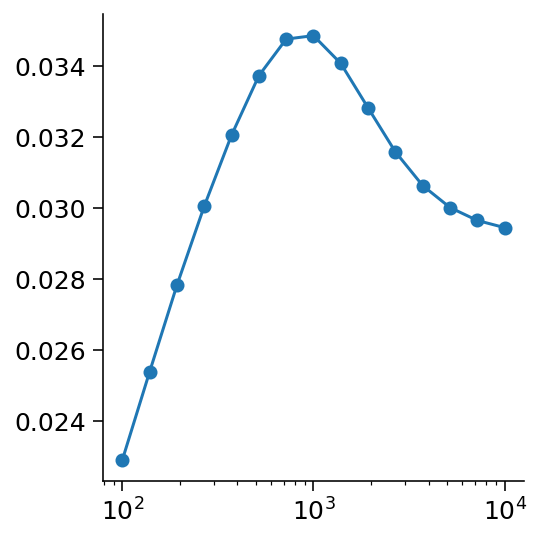

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_4
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


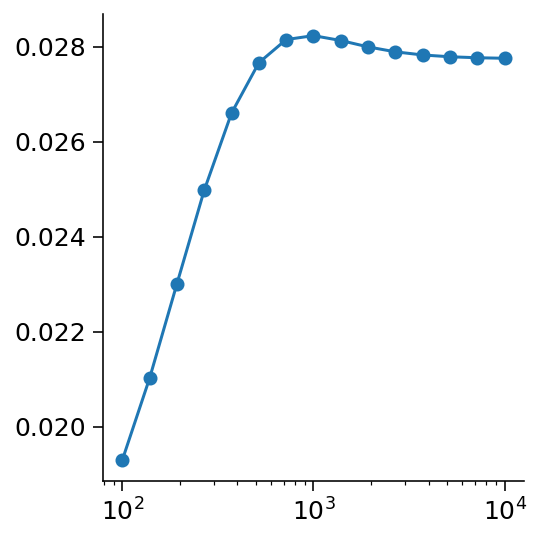

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1000
Max Corr: 0


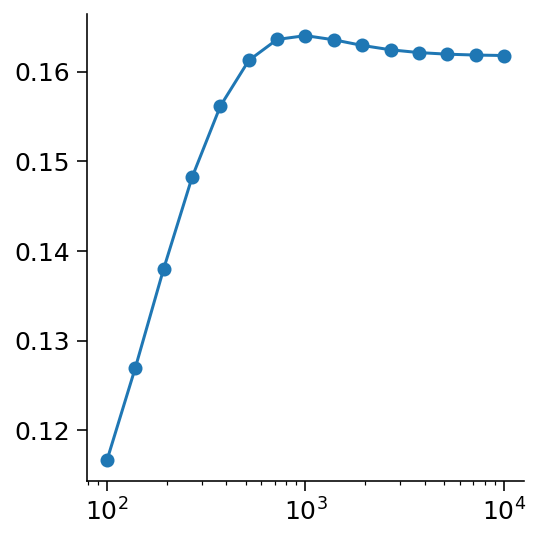

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


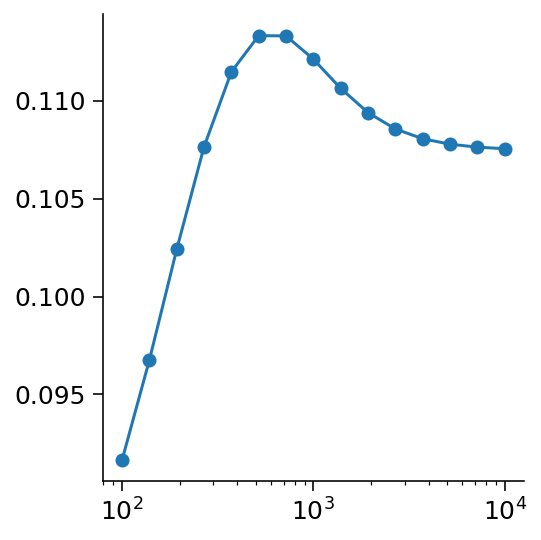

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


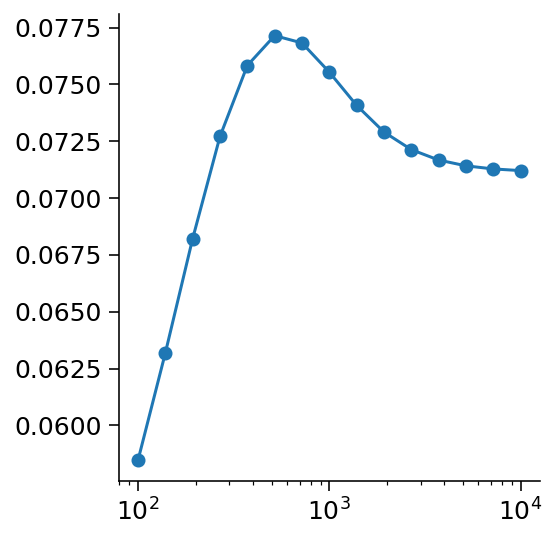

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


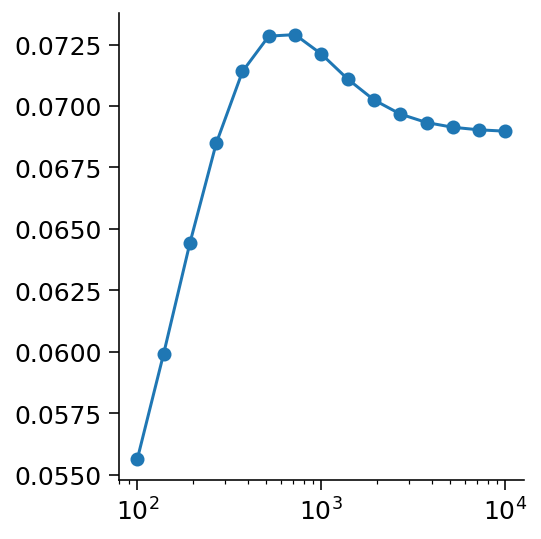

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1389
Max Corr: 0


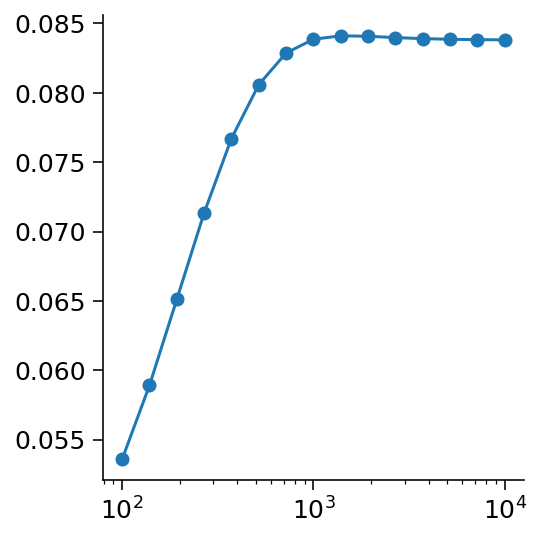

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


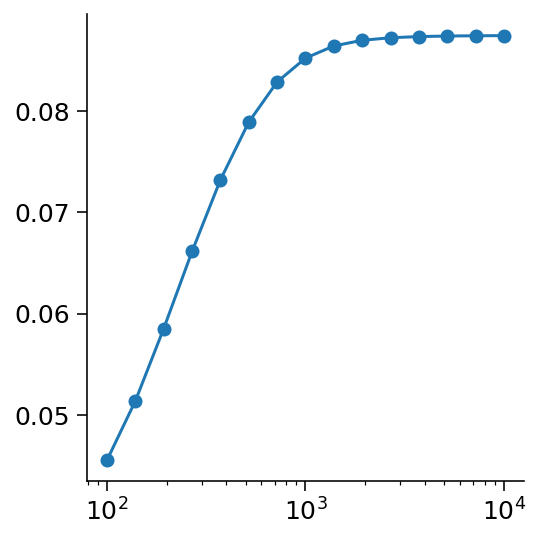

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


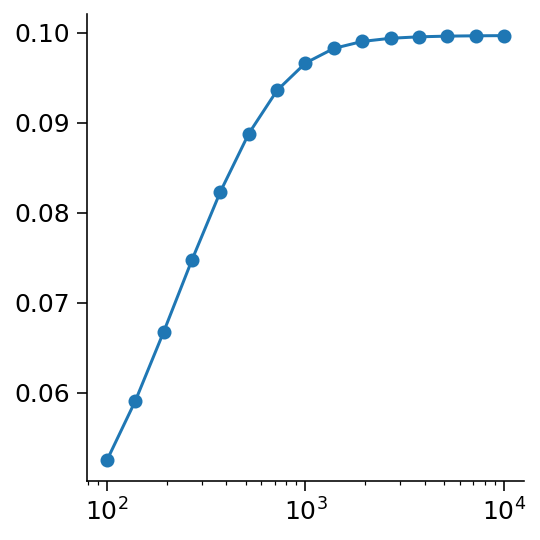

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


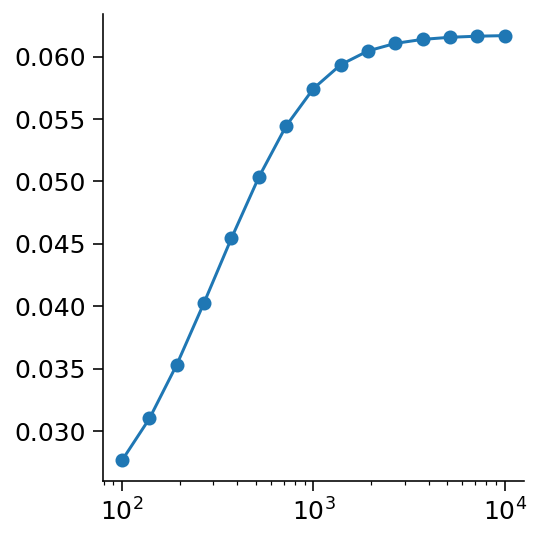

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 10000
Max Corr: 0


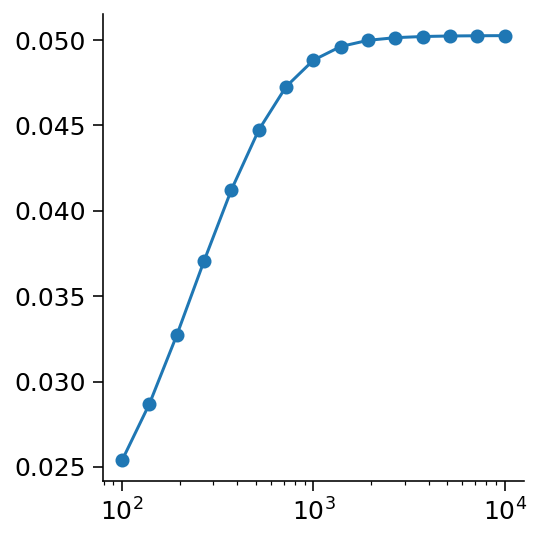

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_5
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1000
Max Corr: 0


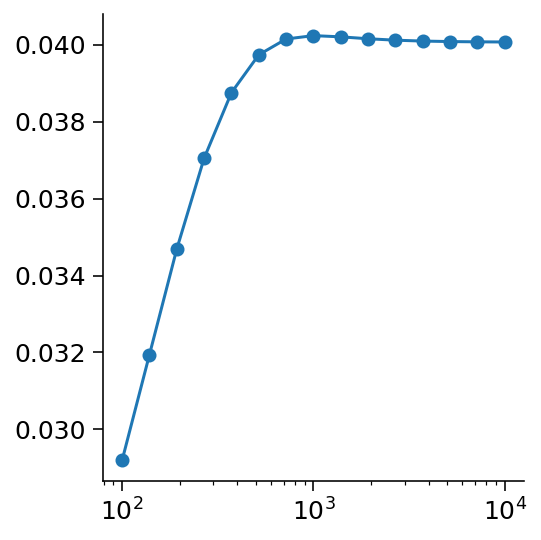

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 1000
Max Corr: 0


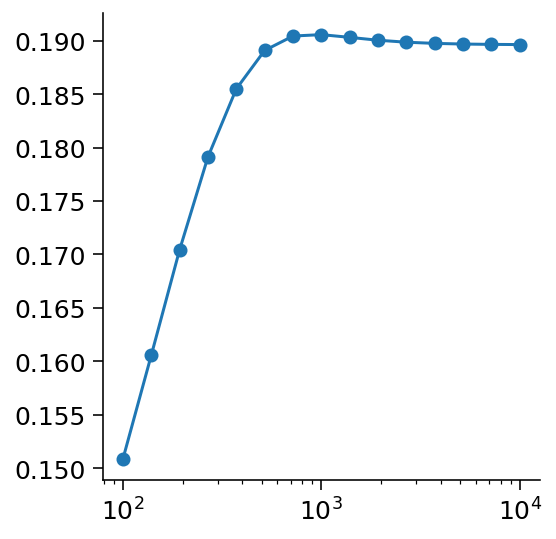

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 719
Max Corr: 0


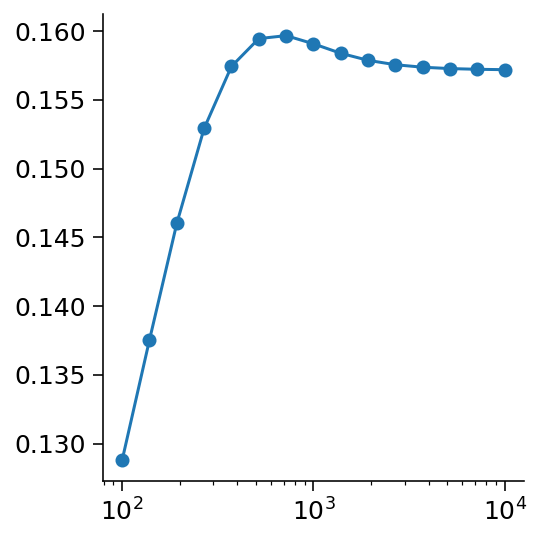

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 719
Max Corr: 0


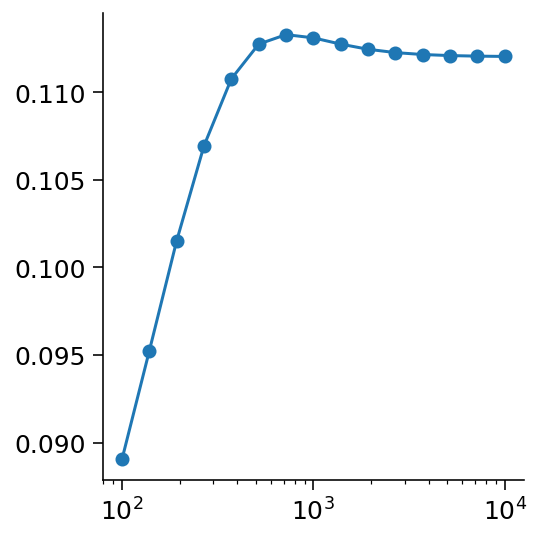

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 2682
Max Corr: 0


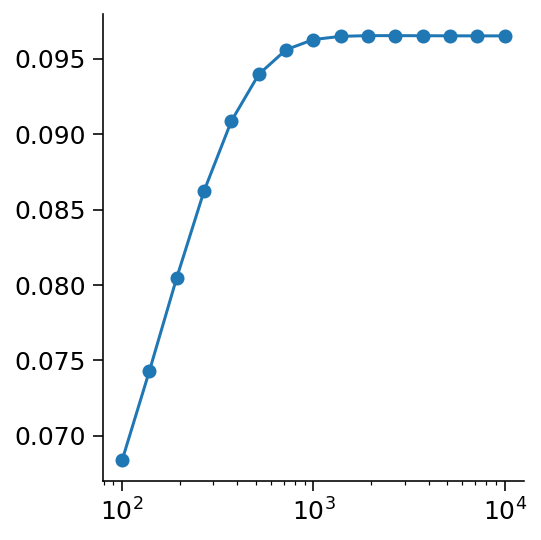

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1389
Max Corr: 0


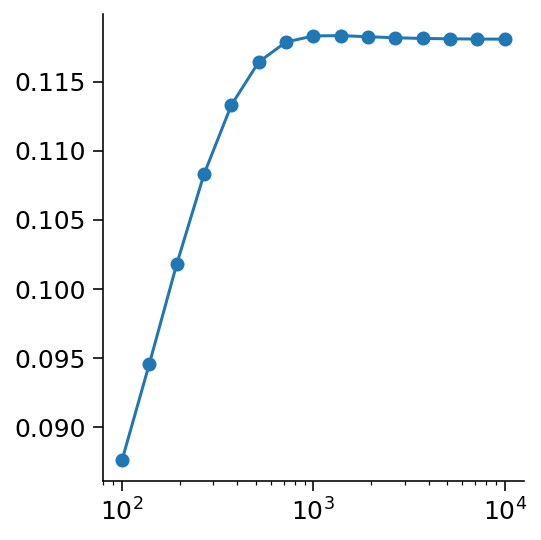

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 10000
Max Corr: 0


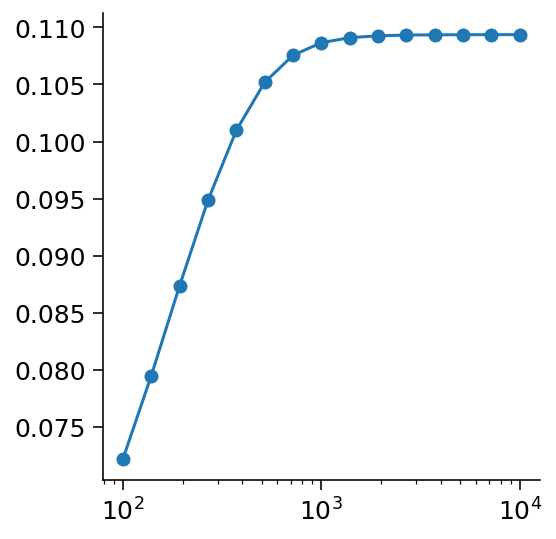

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 10000
Max Corr: 0


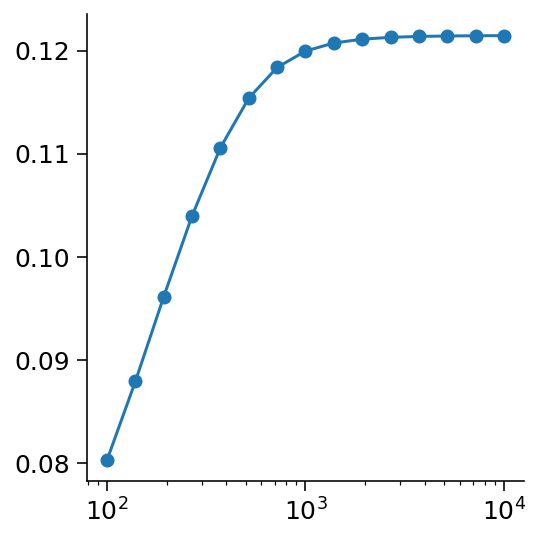

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


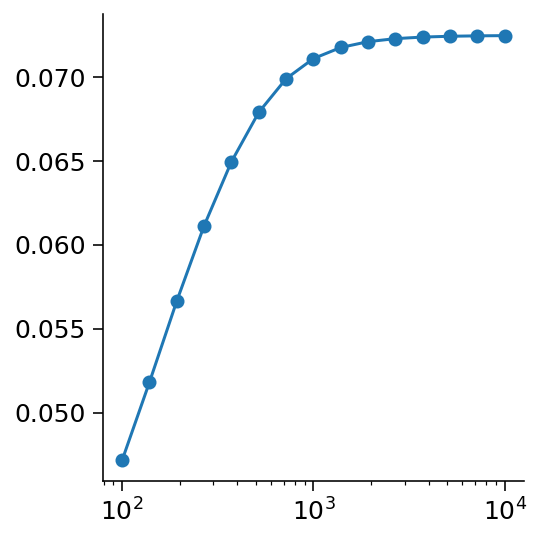

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 10000
Max Corr: 0


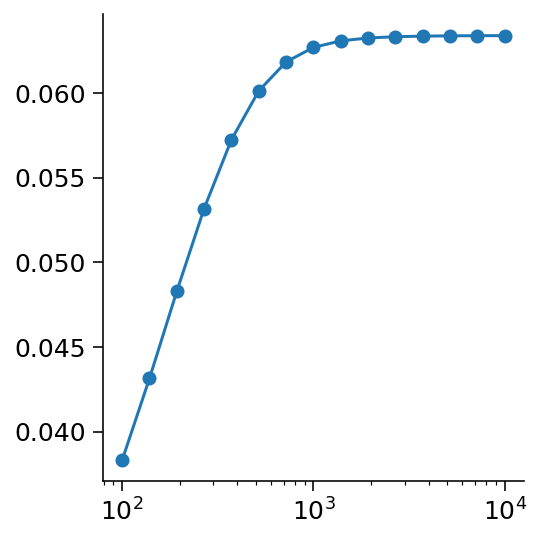

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_6
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 1389
Max Corr: 0


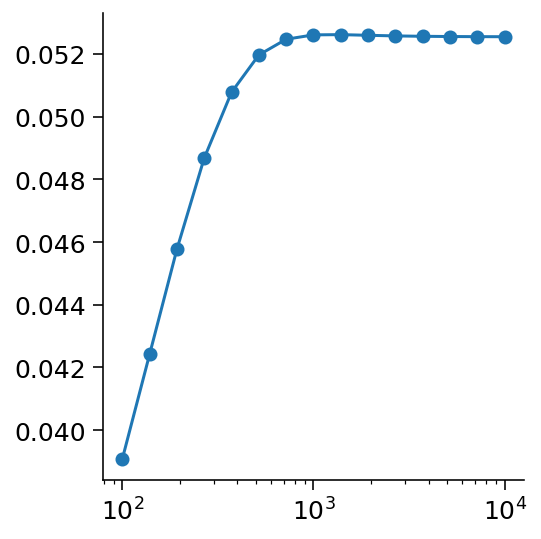

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 372
Max Corr: 0


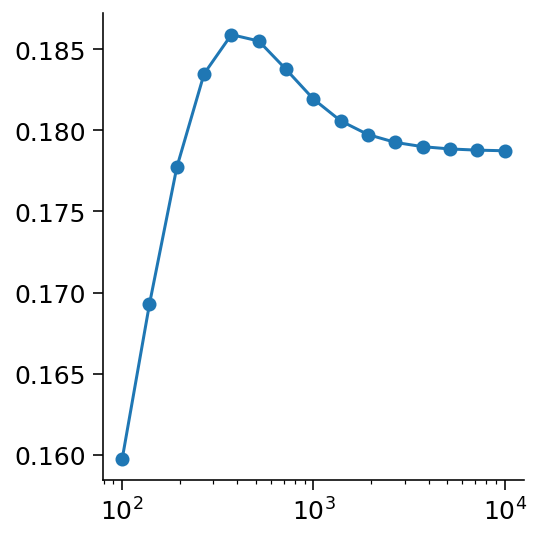

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 372
Max Corr: 0


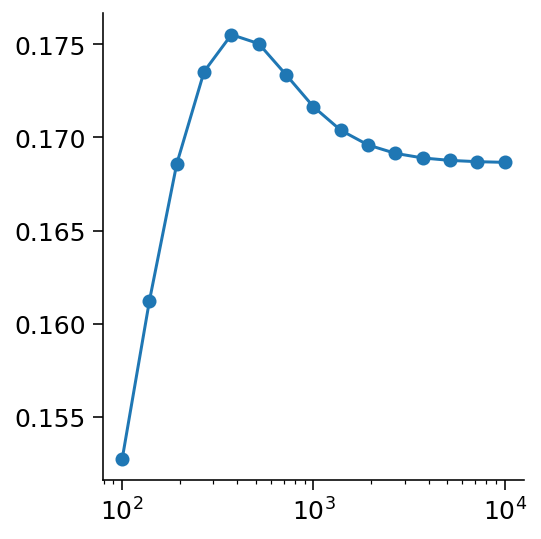

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


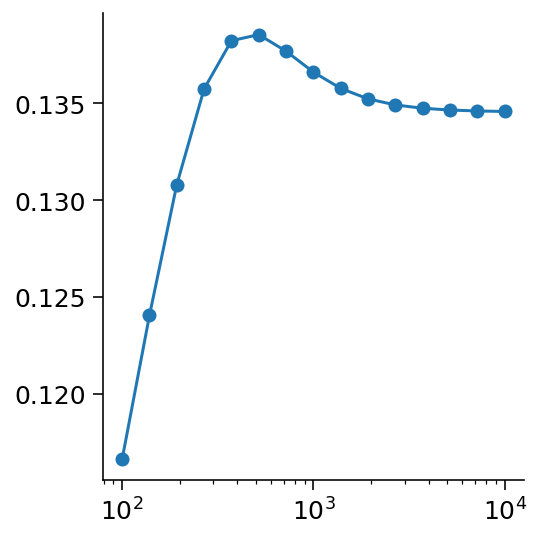

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 517
Max Corr: 0


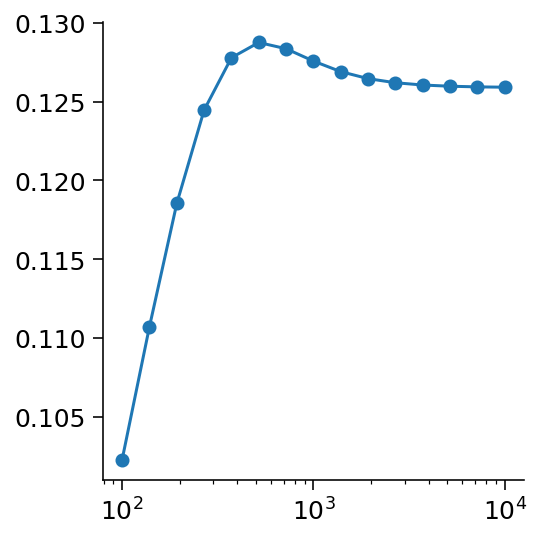

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 1000
Max Corr: 0


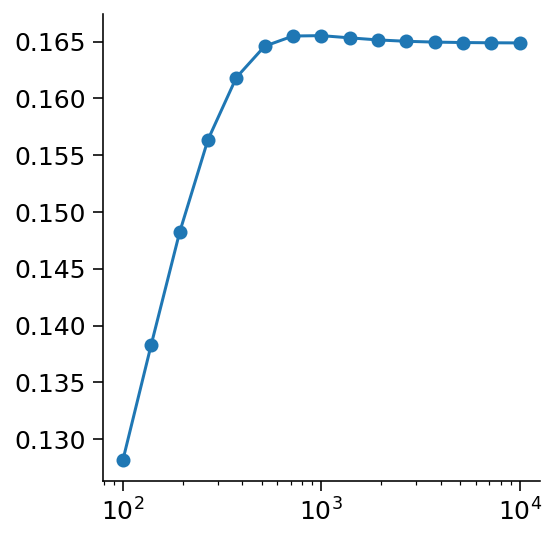

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 1000
Max Corr: 0


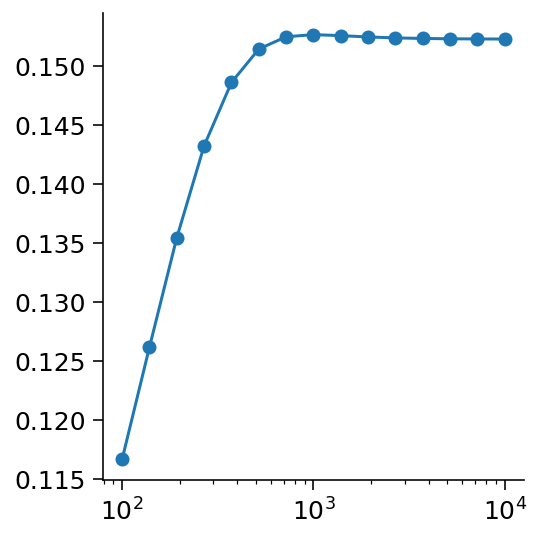

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 1000
Max Corr: 0


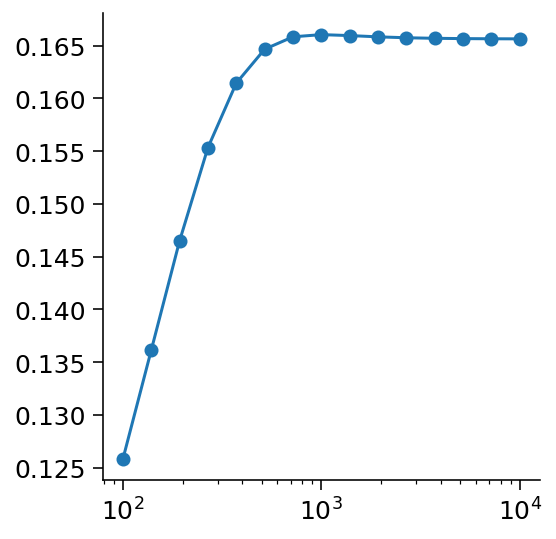

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 10000
Max Corr: 0


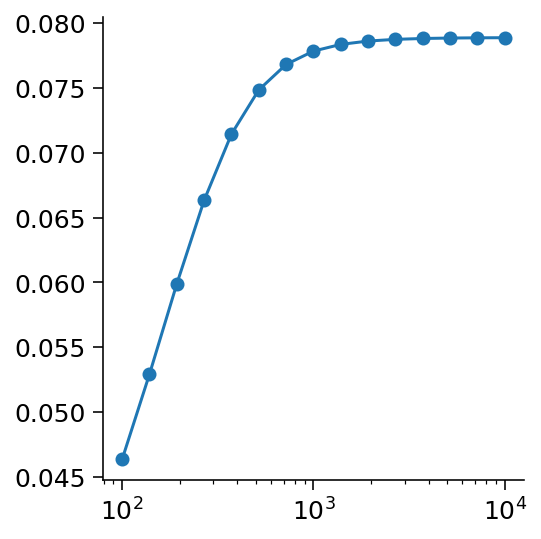

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


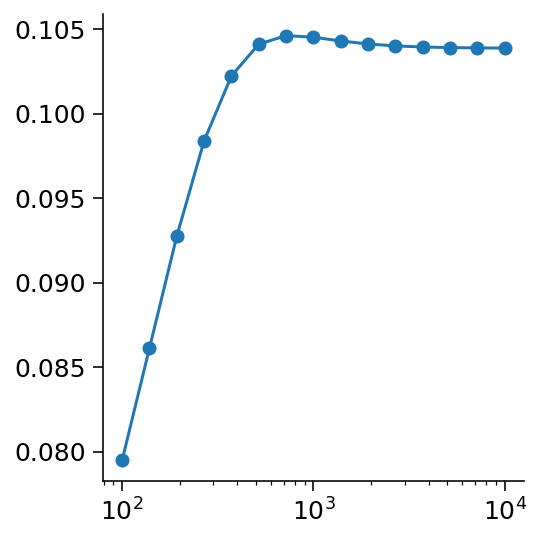

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_7
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 719
Max Corr: 0


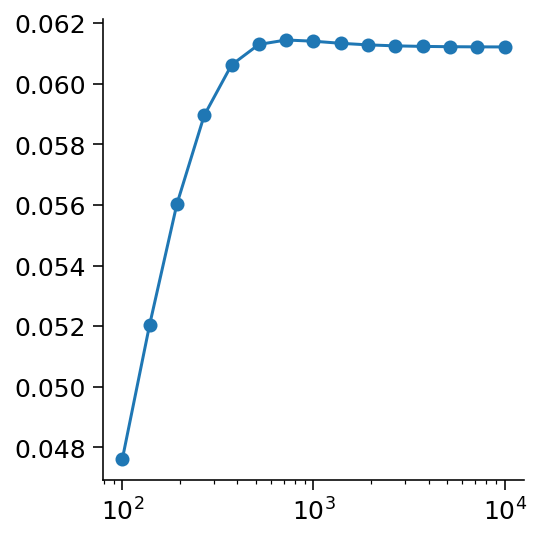

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 517
Max Corr: 0


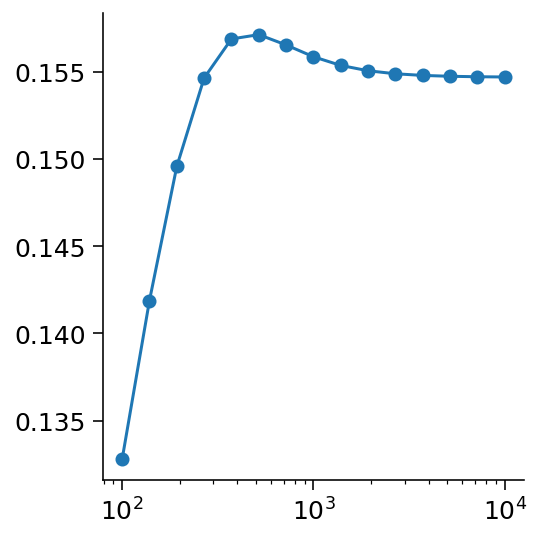

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 517
Max Corr: 0


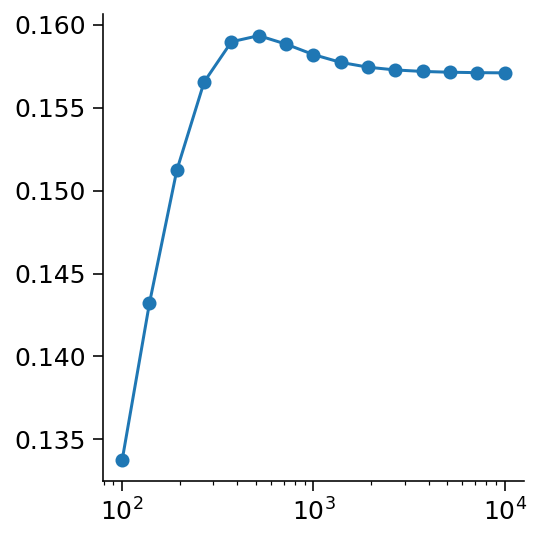

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 517
Max Corr: 0


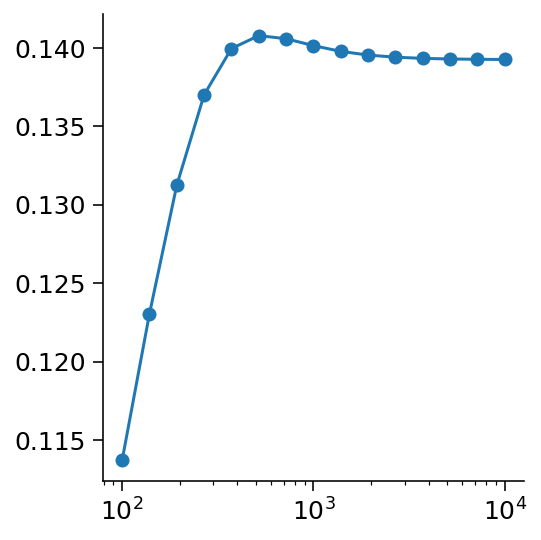

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 719
Max Corr: 0


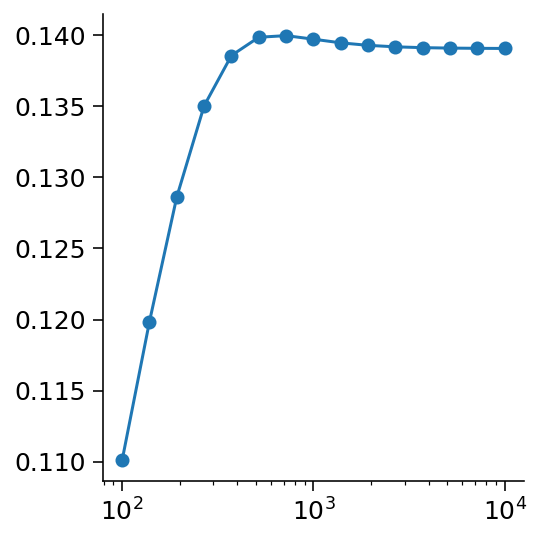

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 517
Max Corr: 0


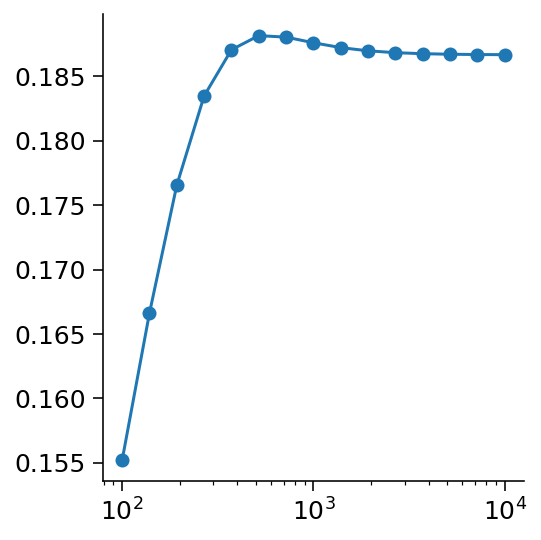

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 517
Max Corr: 0


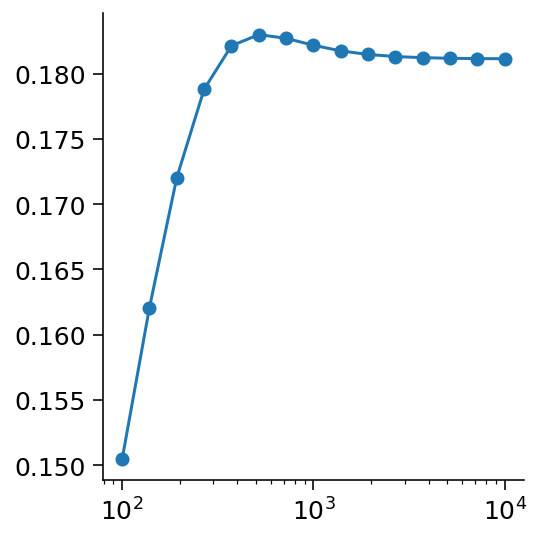

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 517
Max Corr: 0


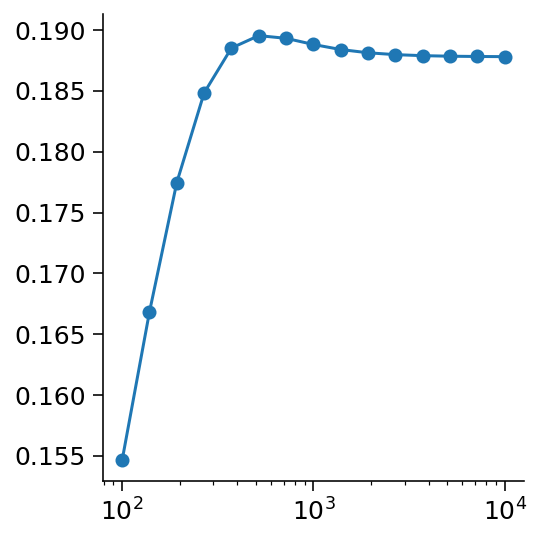

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 719
Max Corr: 0


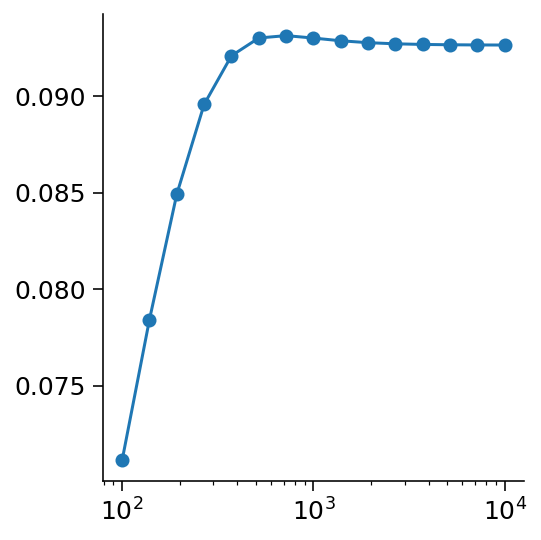

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 719
Max Corr: 0


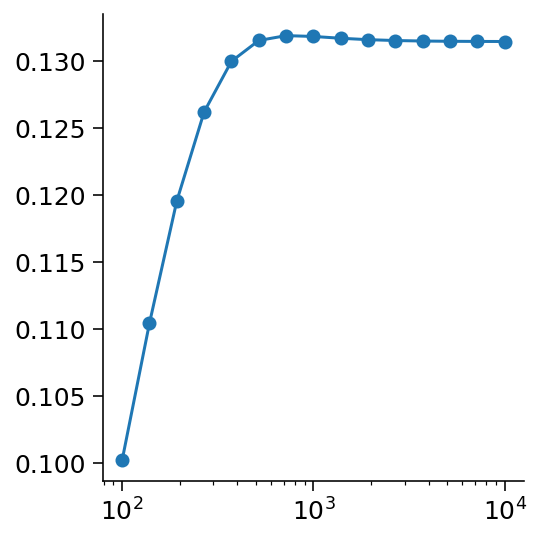

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_8
----------------------------------------------------------------------------
Starting ROI:  WB  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WB
Best lambda: 138
Max Corr: 0


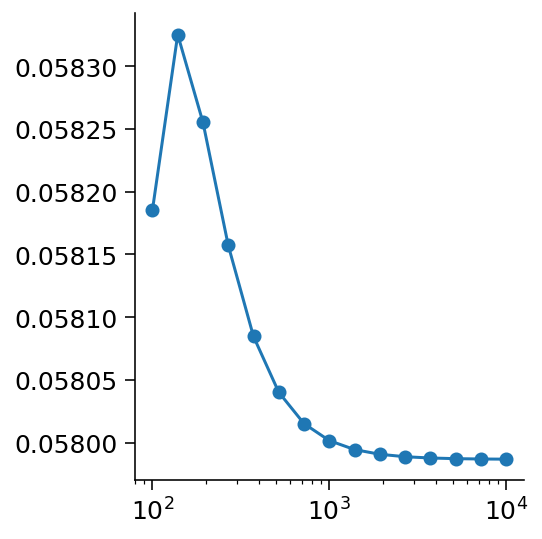

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  WB  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V1  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V1
Best lambda: 100
Max Corr: 0


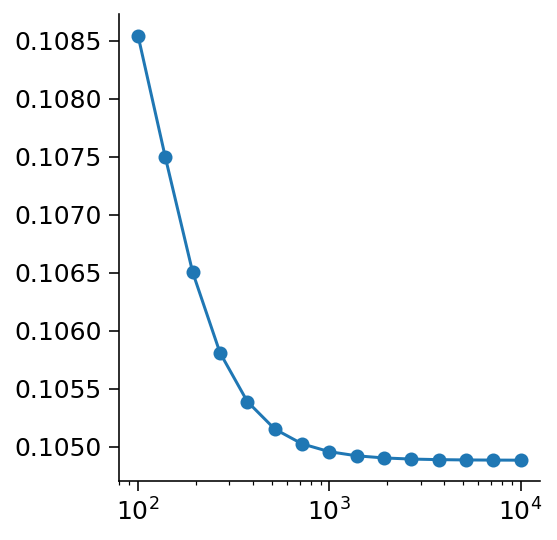

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V1  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V2  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V2
Best lambda: 100
Max Corr: 0


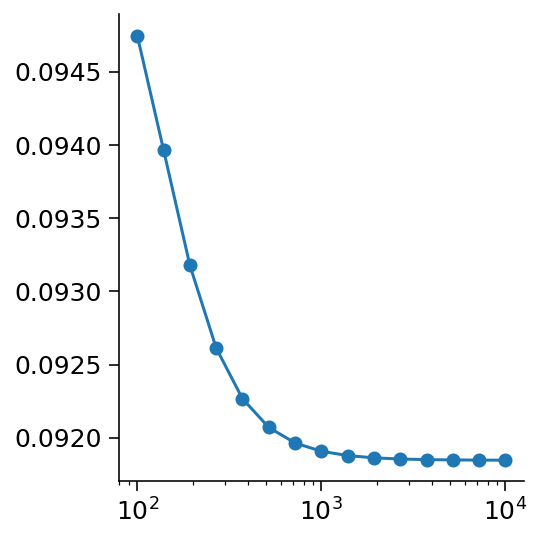

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V2  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V3  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V3
Best lambda: 100
Max Corr: 0


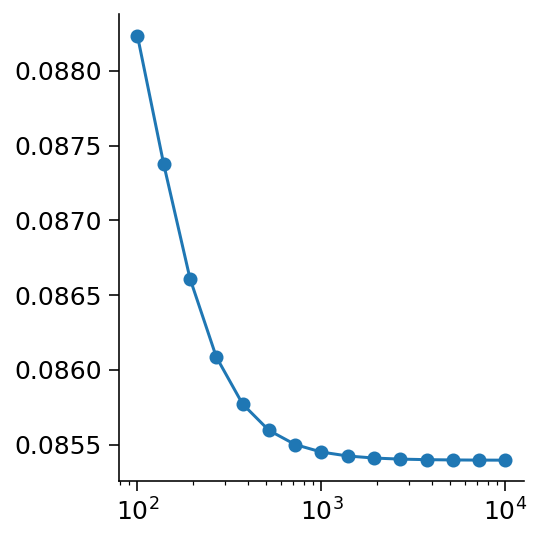

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V3  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  V4  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V4
Best lambda: 100
Max Corr: 0


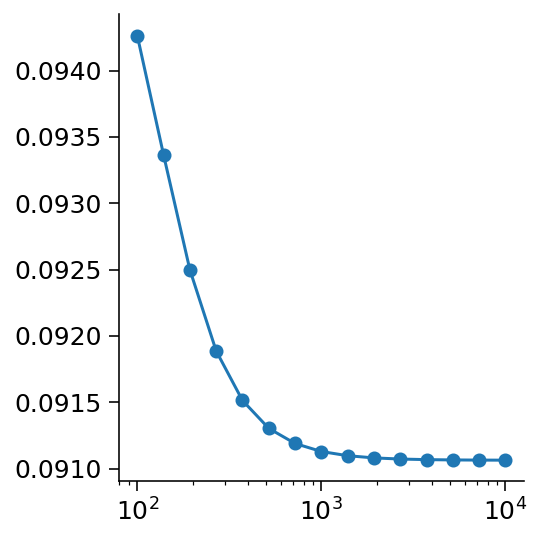

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  V4  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  LOC  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOC
Best lambda: 100
Max Corr: 0


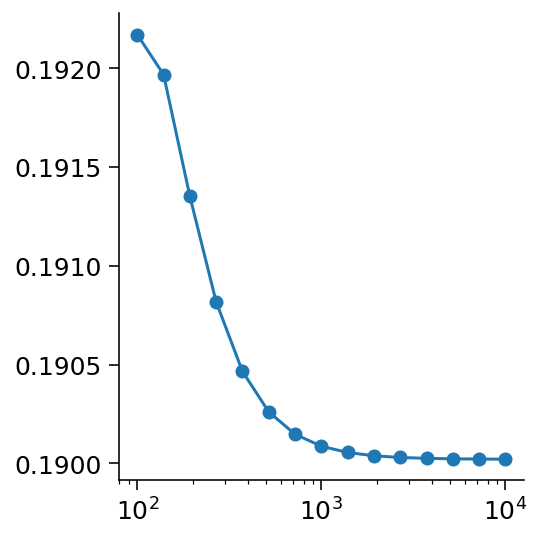

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  LOC  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  EBA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EBA
Best lambda: 100
Max Corr: 0


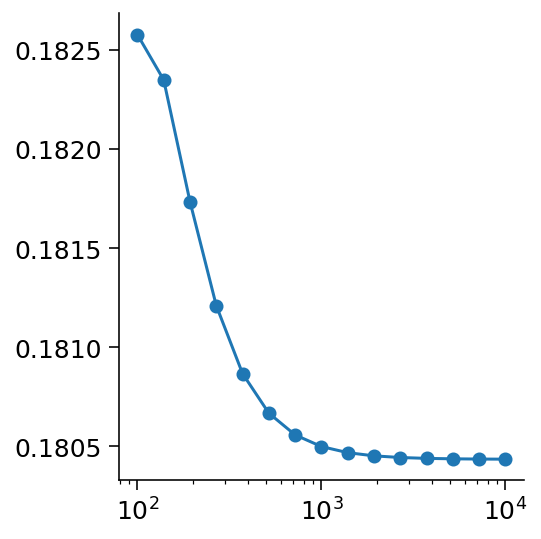

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  EBA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  FFA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FFA
Best lambda: 138
Max Corr: 0


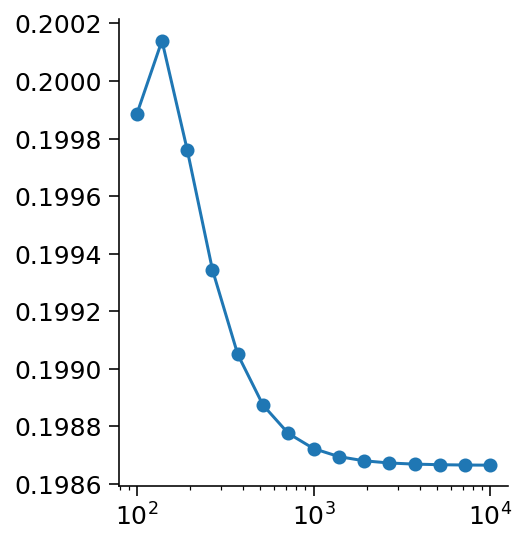

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  FFA  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  STS  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STS
Best lambda: 138
Max Corr: 0


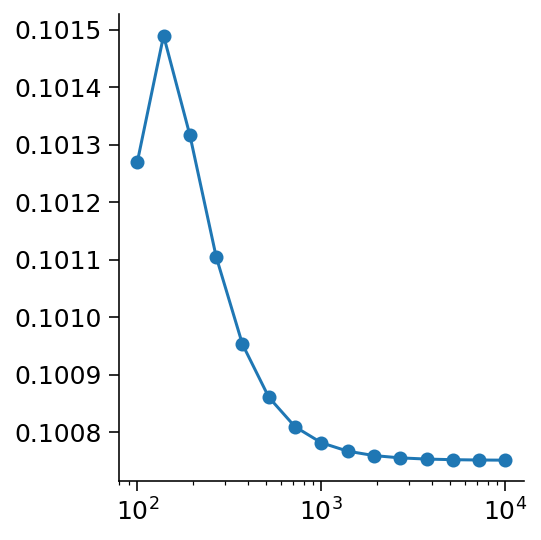

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  STS  layer:  layer_9
----------------------------------------------------------------------------
Starting ROI:  PPA  layer:  layer_9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPA
Best lambda: 10000
Max Corr: 0


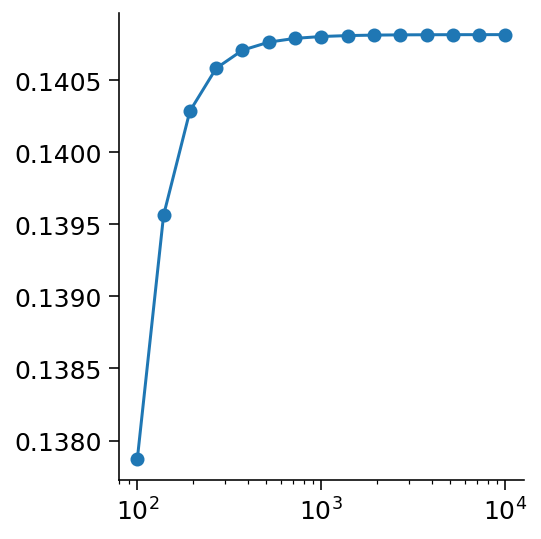

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Completed ROI:  PPA  layer:  layer_9
----------------------------------------------------------------------------


In [ ]:
#@title sub06
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub06"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 15 # 
nchunks = 45

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub07
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub07"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 5, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 30 # 
nchunks = 25

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub08
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub08"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub09
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub09"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title sub10
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8", "layer_9",]

subs  = ["sub10"]

fmri_dir = '/content/participants_data_v2021'
activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/Output'

tab = widgets.TabBar(layers, location='top')
grid = widgets.Grid(5, 5)
alphas = np.logspace(2, 4, 15) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 15 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 15

for sub in subs:
  # logging.basicConfig(filename=f'{sub}.log', encoding='utf-8', level=logging.DEBUG)
  print ("Starting sub: ",sub)
  for layer in layers:
    for grid_ind, ROI in enumerate(ROIs):

      results_dir = os.path.join(prediction_dir, layer, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
      print ("Starting ROI: ", ROI, " layer: ",layer)
      
      wt, corrs, valphas, allRcorrs, valinds, bestalpha = perform_encoding(activations_dir, fmri_dir, results_dir, sub, layer, ROI, grid, grid_ind, tab, alphas, nboots, chunklen, nchunks)
      
      show_lams(tab, layer, grid, grid_ind, alphas, allRcorrs, bestalpha, corrs)
      
      # visualise_act(corrs)
      print ("Completed ROI: ", ROI, " layer: ",layer)
      print("----------------------------------------------------------------------------")

In [ ]:
sns.kdeplot(corrs,bw_adjust=.4)
plt.axvline(0, color='r', linestyle='solid')
